# 08_BuoyDrift_MarApr_Analysis
Analysis of winds, buoy drift during opening events
11/15/2023


### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from common_imports import *

sys.path.append('./scripts/')
from LIB_SIDExbuoy import open_buoy_data, calc_velocity

font = {'size'   : 10}
FS = 10
matplotlib.rc('font', **font)

# Define analysis period

In [2]:
#==========================================================================================
start_date = datetime(year = 2021, month = 3, day = 1, hour = 0, minute=0)
end_date = datetime(year = 2021, month = 4, day = 30, hour = 23, minute=0)
#==========================================================================================

# Open buoy coordinate data

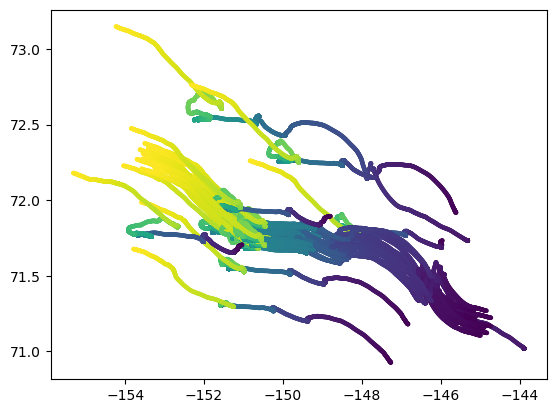

In [3]:
buoy_ds = xr.open_dataset('./data/BuoyCoordinates_cln_v0.nc')
buoy_ds.close()
buoy_ds['time'] = pd.to_datetime(buoy_ds.time.values)


#=======================================================================
# add 30 mins to either end of date range since desiring hourly steps from 30min data
TI = start_date - timedelta(minutes=30)
TF = end_date + timedelta(minutes=30)
#=======================================================================

# #=======================================================================
# TI = datetime(year=2021, month=2, day=28, hour=23, minute=30)
# TF = datetime(year=2021, month=5, day=31, hour=0, minute=30)
# #=======================================================================
timess = pd.to_datetime(buoy_ds.sel(time=slice(TI, TF)).time.values)
buoy_time = buoy_ds.time.values
buoy_IDs = buoy_ds.buoyID.values

days_since_TI = (timess - timess[0]).total_seconds() / (60 * 60 * 24)

for buoy in buoy_ds.buoyID.values:
    plt.scatter(buoy_ds.longitude.sel(buoyID=buoy).sel(time=slice(TI, TF)), 
                buoy_ds.latitude.sel(buoyID=buoy).sel(time=slice(TI, TF)),
                c=days_since_TI, s=5)

### Calculate velocities over analysis period

 - time range: 2021-03-01 00:00:00 thru 2021-04-30 23:00:00
 - dt = 0 days 01:00:00


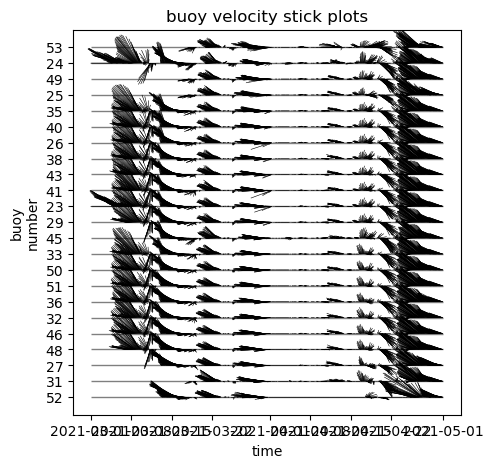

In [4]:
#===========================================================
# velocity component flag (speeds over this replaced with nans as nonphysical)
velflag = 60*units('cm')/units('s')

STEP = 2
#===========================================================

# buoys west of lead, but further west or north of lead than others
buoys_NW = ['24','53']
# buoys west of lead
buoys_W = ['29', '23', '41', '43', '38', '26', '40', '35', '25', '49']#'30',
# buoys east of lead
buoys_E = ['27','48', '46', '32', '36', '51', '50',  '33','45',]#'28',
# south and far east buoys that open later as different lead opens
buoys_SE = ['52','31']

#===========================================================
ordered_IDs = buoys_SE + buoys_E + buoys_W + buoys_NW
#===========================================================


fig, ax = plt.subplots(figsize = (5,5))

all_speeds = np.array([])
all_us = np.array([])
all_vs = np.array([])
all_dirs = np.array([])

# add 30 mins to either end of date range since desiring hourly steps from 30min data
TI = start_date - timedelta(minutes=30)
TF = end_date + timedelta(minutes=30)

for bb, buoy in enumerate(ordered_IDs):
    
    # grab buoy data
    #---------------
    lon_track = buoy_ds.longitude.sel(time=slice(TI, TF)).sel(buoyID = buoy).values
    lat_track = buoy_ds.latitude.sel(time=slice(TI, TF)).sel(buoyID = buoy).values
    time_track = pd.to_datetime(buoy_ds.time.sel(time=slice(TI, TF)).values)

    # calculate velocity
    #-------------------
    u, v, time, dx, dy, dist = calc_velocity(lon_track = lon_track, lat_track = lat_track, 
                                                 time_track = time_track, step = STEP)
    
    # ice drift direction
    ice_dir = metpy.calc.wind_direction(u, v, convention='from')
    
    # flag unphysical velocities
    v_flag = np.sqrt(u**2+v**2) > velflag
    u[v_flag] = np.nan
    v[v_flag] = np.nan
    ice_dir[v_flag] = np.nan
    
    # save all data
    all_speeds = np.append(all_speeds, np.sqrt(u**2+v**2))
    all_us = np.append(all_us, u)
    all_vs = np.append(all_vs, v)
    all_dirs = np.append(all_dirs, ice_dir)
        
    # plotting
    #---------
    # stick plot
    ax.hlines(bb, start_date, end_date, colors='k', linewidths=1, alpha=0.5, zorder=-1)
    ax.quiver(time, bb+np.zeros(len(time)), u, v, color='k', scale=400, width=0.0015, headwidth=0)
    
    
ax.set_ylabel('buoy\nnumber')
ax.set_xlabel('time')
ax.set_title('buoy velocity stick plots')
ax.set_yticks(np.arange(len(ordered_IDs)))
ax.set_yticklabels(ordered_IDs)


# regrid buoy data for meshgridding
#----------------------------------
time_grid, num_grid = np.meshgrid(time, np.arange(len(buoy_IDs)))
speeds_regrid = np.reshape(all_speeds, ( len(buoy_IDs), int(len(all_speeds)/len(buoy_IDs))))
us_regrid = np.reshape(all_us, ( len(buoy_IDs), int(len(all_speeds)/len(buoy_IDs))))
vs_regrid = np.reshape(all_vs, ( len(buoy_IDs), int(len(all_speeds)/len(buoy_IDs))))
dirs_regrid = np.reshape(all_dirs, ( len(buoy_IDs), int(len(all_speeds)/len(buoy_IDs))))
speed_regrid = np.sqrt(us_regrid**2+vs_regrid**2)

print(f' - time range: {time[0]} thru {time[-1]}\n - dt = {time[1]-time[0]}')

## Open coastal open area file

2021-03-01T00:00:00.000000000 --- 2021-04-30T00:00:00.000000000


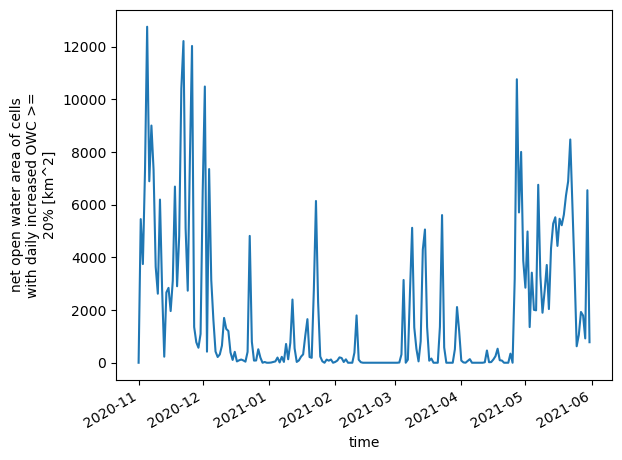

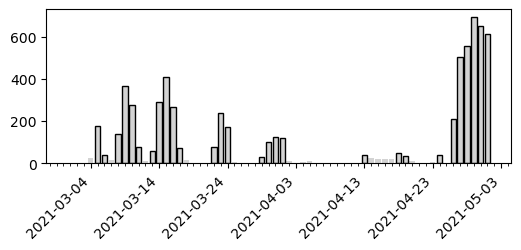

In [5]:
ds_open = xr.open_dataset('./data/SBS_open_area_v4.nc')
ds_open.close()

# create strings to crop time
start_string = f'{start_date.year}-{str(start_date.month).zfill(2)}-{str(start_date.day).zfill(2)}T00:00:00.000000000'
end_string = f'{end_date.year}-{str(end_date.month).zfill(2)}-{str(end_date.day).zfill(2)}T00:00:00.000000000'


print(f'{start_string} --- {end_string}')

ds_open_crop = ds_open.sel(time=slice(start_string, end_string))
open_area = ds_open_crop.oa.values
open_area_g20 = ds_open_crop.oa_g20.values
extent_g20 = ds_open_crop.ext_g20.values
open_area_g10 = ds_open_crop.oa_g10.values
d_open_area = ds_open_crop.doa.values
open_area_inc20 = ds_open_crop.oa_inc_g20.values
open_area_dates = pd.to_datetime(ds_open_crop.time.values)

num_oa_g20 = ds_open_crop.N_oa_g20.values
num_oa_g10 = ds_open_crop.N_oa_g10.values

ds_open.oa_inc_g20.plot()



ds_open_crop = ds_open.sel(time=slice('2021-03-01T00:00:00.000000000', '2021-05-01T00:00:00.000000000'))
fig, ax = plt.subplots(figsize=(6,2))
ax.bar(ds_open_crop.time.values, ds_open_crop.N_oa_g20.values, facecolor='lightgray')
cond = ds_open_crop.N_oa_g20.values > 1000/(6.25*6.25)
ax.bar(ds_open_crop.time.values[cond], ds_open_crop.N_oa_g20.values[cond], facecolor='None', edgecolor='k')

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.xticks(rotation=45, ha='right');

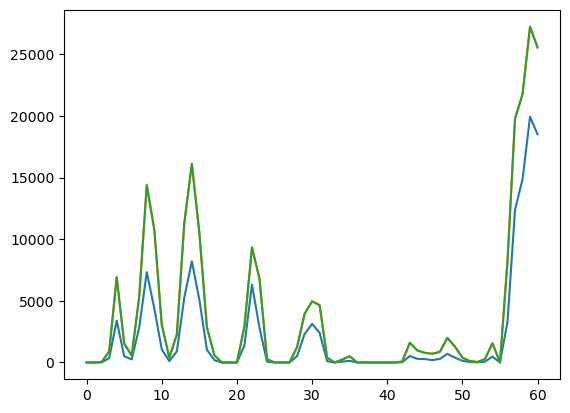

In [176]:
plt.plot(open_area_g20)
plt.plot(extent_g20)
plt.plot(num_oa_g20*6.25*6.25)


### Find dates when new opening occurred and define opening sequences

In [6]:
# specify dates when opening occurred (from notebook 11)
dates_only = [date-timedelta(hours=date.hour) for date in pd.to_datetime(time)]


# open "open area" nc file
# 80% threshold, A = 200 km2, dA/dt > 0
#---------------------------------------
# find date when there are new wide openings
wide_opening_dates = pd.to_datetime(open_area_dates[extent_g20 > 1000].values)
consolidated_dates = pd.to_datetime(open_area_dates[extent_g20 <= 1000].values)
new_opening_dates = pd.to_datetime(open_area_dates[d_open_area > 0].values)
opening_dates = np.array([], dtype='datetime64[ns]')
for date in wide_opening_dates:
#     if date in new_opening_dates:
    opening_dates = np.append(opening_dates, date)
        
        
print(f'{len(open_area_dates)} total dates')
print(f'{len(consolidated_dates)} dates with oa(sic>80) <= threshold')
print(f'{len(wide_opening_dates)} dates with oa(sic>80) > threshold')
print(f'{len(new_opening_dates)} dates with doa > 0')

# opening_dates = opening_dates[opening_dates >= datetime(year=2021, month=3, day=1, hour=0)]
# opening_dates = opening_dates[opening_dates <= datetime(year=2021, month=4, day=30, hour=23)]
# add all hours of each opening day to array  
#-------------------------------------------
open_dates_withhours = np.array([])
for dd, date in enumerate(dates_only):
    if date in wide_opening_dates:
        open_dates_withhours = np.append(open_dates_withhours, time[dd])
        
# partition into opening sequences  
#---------------------------------
open_sequences={}
# fill in first value of list
ss = 0
open_sequences[ss] = [open_dates_withhours[0]]
for ii in range(1,len(open_dates_withhours)):
    # number hours difference between last time in current sequence and current time
    dh = pd.Timedelta(open_dates_withhours[ii]-open_sequences[ss][-1]).total_seconds()/3600
    # if within one hour of last timein sequence, add to current sequence
    if dh <= 1:
        open_sequences[ss].append(open_dates_withhours[ii])
    # else start new sequence
    else:
        ss+=1
        open_sequences[ss] = [open_dates_withhours[ii]]
        
        
        
# add all hours of each opening day to array  
#-------------------------------------------
opening_dates_withhours = np.array([])
for dd, date in enumerate(dates_only):
    if date in opening_dates:
        opening_dates_withhours = np.append(opening_dates_withhours, time[dd])
        
# partition into opening sequences  
#---------------------------------
break_sequences={}
# fill in first value of list
ss = 0
break_sequences[ss] = [opening_dates_withhours[0]]
for ii in range(1,len(opening_dates_withhours)):
    # number hours difference between last time in current sequence and current time
    dh = pd.Timedelta(opening_dates_withhours[ii]-break_sequences[ss][-1]).total_seconds()/3600
    # if within one hour of last timein sequence, add to current sequence
    if dh <= 1:
        break_sequences[ss].append(opening_dates_withhours[ii])
    # else start new sequence
    else:
        ss+=1
        break_sequences[ss] = [opening_dates_withhours[ii]]
        
print(f'{len(break_sequences)} opening sequences\n--------------------')
for seq in break_sequences:
    print(f'{break_sequences[seq][0]} -- {break_sequences[seq][-1]}  ({len(break_sequences[seq])} hours)')
    

close_dates_withhours = np.array([])
for dd, date in enumerate(dates_only):
    if date in consolidated_dates:
        close_dates_withhours = np.append(close_dates_withhours, time[dd])
    
# partition into opening sequences  
#---------------------------------
compact_sequences={}
# fill in first value of list
ss = 0
compact_sequences[ss] = [close_dates_withhours[0]]
for ii in range(1,len(close_dates_withhours)):
    # number hours difference between last time in current sequence and current time
    dh = pd.Timedelta(close_dates_withhours[ii]-compact_sequences[ss][-1]).total_seconds()/3600
    # if within one hour of last timein sequence, add to current sequence
    if dh <= 1:
        compact_sequences[ss].append(close_dates_withhours[ii])
    # else start new sequence
    else:
        ss+=1
        compact_sequences[ss] = [close_dates_withhours[ii]]
        
print(f'{len(compact_sequences)} compact sequences\n--------------------')
for seq in compact_sequences:
    print(f'{compact_sequences[seq][0]} -- {compact_sequences[seq][-1]}  ({len(compact_sequences[seq])} hours)')
    


61 total dates
34 dates with oa(sic>80) <= threshold
27 dates with oa(sic>80) > threshold
33 dates with doa > 0
9 opening sequences
--------------------
2021-03-05 00:00:00 -- 2021-03-06 23:00:00  (48 hours)
2021-03-08 00:00:00 -- 2021-03-11 23:00:00  (96 hours)
2021-03-13 00:00:00 -- 2021-03-17 23:00:00  (120 hours)
2021-03-22 00:00:00 -- 2021-03-24 23:00:00  (72 hours)
2021-03-29 00:00:00 -- 2021-04-01 23:00:00  (96 hours)
2021-04-13 00:00:00 -- 2021-04-13 23:00:00  (24 hours)
2021-04-18 00:00:00 -- 2021-04-19 23:00:00  (48 hours)
2021-04-24 00:00:00 -- 2021-04-24 23:00:00  (24 hours)
2021-04-26 00:00:00 -- 2021-04-30 23:00:00  (120 hours)
9 compact sequences
--------------------
2021-03-01 00:00:00 -- 2021-03-04 23:00:00  (96 hours)
2021-03-07 00:00:00 -- 2021-03-07 23:00:00  (24 hours)
2021-03-12 00:00:00 -- 2021-03-12 23:00:00  (24 hours)
2021-03-18 00:00:00 -- 2021-03-21 23:00:00  (96 hours)
2021-03-25 00:00:00 -- 2021-03-28 23:00:00  (96 hours)
2021-04-02 00:00:00 -- 2021-04-12 

## Open wind file

In [7]:
# open data
ds_ERA5 = xr.open_dataset('./data/SBS_ERA5_hourly.nc')
ds_ERA5.close()

# grab variables over time
region_u10 = ds_ERA5.u.sel(time=slice(time[0], time[-1])).values
region_v10 = ds_ERA5.v.sel(time=slice(time[0], time[-1])).values
region_wd = ds_ERA5.wind_dir.sel(time=slice(time[0], time[-1])).values
region_ws = np.sqrt(region_u10**2+region_v10**2)
region_msl = ds_ERA5.msl.sel(time=slice(time[0], time[-1])).values

# grab variables over time
time_adjust = np.append(time - timedelta(minutes=30), time[-1] + timedelta(minutes=30))
heights = np.array([0,1])
time_grid2, height_grid2 = np.meshgrid(time_adjust, heights)


In [8]:
def add_windDir_key(ax):
    
    phis   = np.linspace(0,1,50) 
    thetas = np.linspace(0,2.01*np.pi,201)
    X,Y = np.meshgrid(thetas,phis)

    ax.pcolormesh(X,Y,X, vmin=0,vmax=2*np.pi, cmap=mpl.cm.twilight_shifted)
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")

    ax.set_rticks([])
    ax.set_rlim(0,1)
    # ax.grid(linewidth=0.5, zorder=-10, c='k')

    # xticks = np.arange(0,2*np.pi,np.pi/4)
    # xticklabels = ['N', 'NE',  'E',  'SE', 'S',  'SW',  'W',  'NW', ]
    # yy = [1.2, 1.3, 1.2, 1.3, 1.25, 1.3, 1.25, 1.3]

    xticks = np.arange(0,2*np.pi,np.pi/2)
    xticklabels = ['N', 'E','S', 'W']
    yy = 1.35*np.array([1.2, 1.2, 1.2, 1.25])

    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    for tt in range(len(xticks)):
        ax.text(xticks[tt], yy[tt], xticklabels[tt], ha='center', va='center', 
                transform=ax.transData, rotation=0)



# Plot Mar-Apr overview

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_39696/2028745290.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(X,Y,X, vmin=0,vmax=2*np.pi, cmap=mpl.cm.twilight_shifted)


>>> save as: ./figures/MarApr_conditions_v4.png


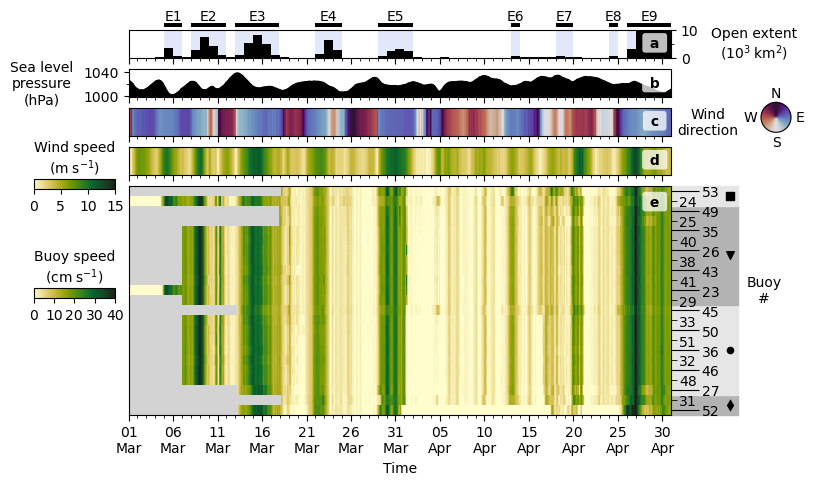

In [16]:
from matplotlib.ticker import FixedLocator, FuncFormatter


# x ticks
#--------
dates_to_label = time[::5*24]
# date_labels = [date.strftime('%d/%m') for dd, date in enumerate(dates_to_label)]
date_labels = [f"{date.strftime('%d')}\n{date.strftime('%b')}" for dd, date in enumerate(dates_to_label)]
# for dd, date in enumerate(date_labels):
#     if dd%2 == 1 :
#         date_labels[dd] = ''
        


fig, axs = plt.subplots(5, 1, sharex=True, squeeze=True, facecolor='white',
                       gridspec_kw = {'height_ratios':[1,1,1,1,8]}, figsize=(7,5))

plt.subplots_adjust(hspace=0.15)

XMIN = time[0]
XMAX = time[-1]

#/////////////////////////
# satellite open area ///
#/////////////////////////////////////////////////////////////////////////////////////

#==========
ax = axs[0]
#==========

# plot params
#------------
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylim([-0.25, 10])
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax.set_ylabel('Open extent\n($\mathrm{10^{3}\; km^{2}}$)', 
              rotation=0, labelpad=40, verticalalignment='center')


ax.bar((open_area_dates+timedelta(hours=12)), 
       open_area_g20/1000, color='k', width=1)


# ax.bar((open_area_dates+timedelta(hours=12))[1:][(np.diff(open_area_g20)>0)&(open_area_g20[1:]>200)], 
#        open_area_g20[1:][(np.diff(open_area_g20)>0)&(open_area_g20[1:]>200)]/1000, facecolor='none', edgecolor='k', width=1)

for seq in open_sequences:  
    ax.fill_between([open_sequences[seq][0], open_sequences[seq][-1]], ax.get_ylim()[0], ax.get_ylim()[-1],
                    facecolor='royalblue', edgecolor='None',alpha=0.15, zorder=-1, clip_on=False)

    
for seq in break_sequences:     
    ax.fill_between([break_sequences[seq][0], break_sequences[seq][-1]], 
                    ax.get_ylim()[-1]*1.1,ax.get_ylim()[-1]*1.25,
                    facecolor='k', edgecolor='None',alpha=1, zorder=-1, clip_on=False)
    ax.text(break_sequences[seq][int(len(break_sequences[seq])/2)], ax.get_ylim()[-1]*1.35, f'E{seq+1}', 
            color='k',  horizontalalignment='center', clip_on=False)
#/////////////////////////////////////////////////////////////////////////////////////


#/////////
# msl ///
#/////////////////////////////////////////////////////////////////////////////////////

#==========
ax = axs[1]
#==========
ax.plot(time, (region_msl), c='k')
ax.fill_between(time, (region_msl), 0, color='k')

# plot params
#------------
ax.yaxis.set_major_locator(plt.MultipleLocator(40))
ax.yaxis.set_minor_locator(plt.MultipleLocator(20))
ax.set_ylim(997.5,1045)

ax.set_ylabel('Sea level\npressure\n(hPa)', 
              rotation=0, labelpad=30, verticalalignment='center')

# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()

# DT = timedelta(hours=230)
# ax.text(time[-1]+DT, 0.5, 'Sea level\npressure\n(hPa)',rotation=0, horizontalalignment='center', verticalalignment='center', clip_on=False)


#/////////////////////////////////////////////////////////////////////////////////////



#////////////////////
# wind direction ///
#/////////////////////////////////////////////////////////////////////////////////////
#==========
ax = axs[2]
#==========
ax.set_yticks([])
winds = ax.pcolormesh(time_grid2, height_grid2, [region_wd], vmin=0,vmax=360, cmap='twilight_shifted')

#polar
add_windDir_key(fig.add_axes([1.02, 0.675, 0.06, 0.06], polar=True))

DT = timedelta(hours=100)
ax.text(time[-1]+DT, 0.5, 'Wind\ndirection',rotation=0, horizontalalignment='center', verticalalignment='center', clip_on=False)

#/////////////////////////////////////////////////////////////////////////////////////




#///////////////
# wind speed ///
#/////////////////////////////////////////////////////////////////////////////////////

#==========
ax = axs[3]
#==========
CMAP = cmocean.cm.speed
winds = ax.pcolormesh(time_grid2, height_grid2, [region_ws], vmin=0,vmax=15, cmap=CMAP)

add_colorbar(fig, ax, [winds], cb_placement='top', cb_width=0.02, 
             cb_length_fraction=[-0.175, -0.025], cb_pad=-0.085, cb_ticks=[0,5,10,15], 
             cb_ticklabels='auto', cb_label = 'Wind speed\n($\mathrm{m\; s^{-1}}$)',
             labelpad=5, cb_label_placement='top', cb_tick_placement='bottom',
             cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

# plot params
#------------
# ax.set_ylabel('Wind speed\n($\mathrm{m\; s^{-1}}$)',  rotation=0, labelpad=30, verticalalignment='center')
# ax.set_xticks(dates_to_label)
# ax.set_xticklabels(['']*len(dates_to_label))
ax.set_yticks([])

#/////////////////////////////////////////////////////////////////////////////////////


#///////////////////
# buoy velocity ///
#/////////////////////////////////////////////////////////////////////////////////////


#==========
ax = axs[4]
#==========

# plot params
#------------
labeled_IDs = np.array(ordered_IDs)
# ax.set_yticks(np.arange(len(labeled_IDs)))
# labeled_IDs[0::2] = ''
# ax.set_yticklabels(labeled_IDs);

ax.set_facecolor('lightgray')

# CMAP = 'Greens'
# CMAP = cmocean.cm.haline_r#cmocean.tools.crop_by_percent(cmocean.cm.thermal, 35, which='min', N=None)
# CMAP = cmocean.tools.crop_by_percent(cmocean.cm.haline_r, 20, which='max', N=None)
# mesh=ax.pcolormesh(time_grid, num_grid, speed_regrid/wind_speed, vmin=0,vmax=4, cmap=CMAP)

CMAP = cmocean.cm.speed
mesh=ax.pcolormesh(time_grid, num_grid, speed_regrid, vmin=0,vmax=40, cmap=CMAP)



ax.set_ylim(-0.5,22.5)
# ax.set_ylabel('Buoy\n#', rotation=0, labelpad=32.5, verticalalignment='center')
# ax.set_ylabel('Buoy\nspeed\n($\mathrm{cm\; s^{-1}}$)', rotation=0, labelpad=38, verticalalignment='center')

add_colorbar(fig, ax, [mesh], cb_placement='top', cb_width=0.02, 
             cb_length_fraction=[-0.175, -0.025], cb_pad=-0.225, cb_ticks=[0,10,20,30,40], 
             cb_ticklabels='auto', cb_label = 'Buoy speed\n($\mathrm{cm\; s^{-1}}$)',
             labelpad=5, cb_label_placement='top', cb_tick_placement='bottom',
             cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


#/////////////////////////////////////////////////////////////////////////////////////

# #///////////
# # ticks ///
# #/////////////////////////////////////////////////////////////////////////////////////
# # x ticks
# #--------
# ax.set_xticks(dates_to_label)
# ax.set_xticklabels(date_labels)
# ax.set_xlim(XMIN, XMAX)
# ax.set_xlabel('Time (date, mm/dd)')

# # y ticks
# #--------
# ax.set_ylim(-0.5,24.5)
# ax.set_yticks(np.arange(len(ordered_IDs)))
# ax.set_yticklabels(ordered_IDs,fontsize=FS-1);
# ax.set_ylabel('Buoy\n#',rotation=0, labelpad=40, verticalalignment='center')


#////////////////////////
# plot group markers ///
#/////////////////////////////////////////////////////////////////////////////////////
marker_color = 'k'

B4 = 22.5
B3 = 20.5
B2 = 10.5
B1 = 1.5
B0 = -0.5

C1 = [0.7,0.7,0.7]
C2 = [0.9,0.9,0.9]

DT = timedelta(hours=180)
ax.fill_between([time[-1], time[-1]+DT], [B0, B0], [B1, B1], color=C1, clip_on=False)
ax.fill_between([time[-1], time[-1]+DT], [B1, B1], [B2, B2], color=C2, clip_on=False)
ax.fill_between([time[-1], time[-1]+DT], [B2, B2], [B3, B3], color=C1, clip_on=False)
ax.fill_between([time[-1], time[-1]+DT], [B3, B3], [B4, B4], color=C2, clip_on=False)

# for bound in [B1, B2, B3, B4]:
#     ax.hlines(bound, time[0]-DT, time[-1], lw = 1, colors='gray', linestyles='solid', clip_on=False)


DT = timedelta(hours=160)
ax.scatter(time[-1]+DT, np.mean([B3,B4]), marker='s',c=marker_color,  s=30, clip_on=False)
ax.scatter(time[-1]+DT, np.mean([B2,B3]), marker='v',c=marker_color,  s=30, clip_on=False)
ax.scatter(time[-1]+DT, np.mean([B1,B2]), marker='o',c=marker_color,  s=20, clip_on=False)
ax.scatter(time[-1]+DT, np.mean([B0,B1]), marker='d',c=marker_color,  s=40, lw=0, clip_on=False)

DT = timedelta(hours=250)
ax.text(time[-1]+DT, 12, 'Buoy\n#',rotation=0, horizontalalignment='center', verticalalignment='center', clip_on=False)


# format y ticks (buoy labels)
#-----------------------------
ax.yaxis.tick_right()

# # ax.autoscale(enable=True, axis='x', tight=True)
def setlabels(x, pos):
    'The two args are the value and tick position'
    return f'{labeled_IDs[x]}'

ax.yaxis.set_major_locator(FixedLocator(np.arange(0, 23, 2)))
ax.yaxis.set_minor_locator(FixedLocator(np.arange(1, 22, 2)))

ax.yaxis.set_minor_formatter(FuncFormatter(setlabels))
ax.yaxis.set_major_formatter(FuncFormatter(setlabels))

ax.tick_params(which='major', axis='y', pad=2, length=20)
ax.tick_params(which='minor', axis='y', pad=2, length=4)


for ax in axs:
    ax.set_xlim(XMIN, XMAX)
    
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.tick_params(which='major', axis='x', length=4)
    ax.set_xticks(dates_to_label)

for ax in axs:
    ax.set_xticklabels(['']*len(dates_to_label))
    

# label panels
y_ranges = [0.3,0.275,0.3,0.3,0.9]
for ii in range(5):
    y_pos = y_ranges[ii]*(axs[ii].get_ylim()[1]-axs[ii].get_ylim()[0]) + axs[ii].get_ylim()[0]
    x_pos = 0.97*(axs[ii].get_xlim()[1]-axs[ii].get_xlim()[0]) + axs[ii].get_xlim()[0]
    axs[ii].text(x_pos, y_pos, f' {chr(97+ii)} ', weight='bold', color='black', verticalalignment='bottom', 
                 horizontalalignment='center',
                 bbox=dict(facecolor='white', alpha=0.75, 
                           edgecolor='None', boxstyle='round,pad=0.2'))

    
axs[4].set_xticklabels(date_labels)
axs[4].set_xlabel('Time');

# fig.subplots_adjust(hspace=0.05)

# save figure
# ------------   
savename = f"./figures/MarApr_conditions_v4.png"
print(f'>>> save as: {savename}')
fig.savefig(savename, 
            transparent=False, bbox_inches="tight", pad_inches = 0.1, dpi=300)


In [124]:
def find_local_winds(buoy_lons, buoy_lats, buoy_times, refine=False):
    
    ds_era = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2021.nc')
#     ds_era = xr.open_dataset('/Users/mackenziejewell/Downloads/ERA5_2021.nc')
    ds_era.close()

    ERA_lons = ds_era.longitude.values
    ERA_lats = ds_era.latitude.values
    ERA_times = ds_era.time.values


    local_u10 = np.array([])
    local_v10 = np.array([])
    local_msl = np.array([])

    for ii in range(len(buoy_times)):
    
        lon = buoy_lons[ii]
        lat = buoy_lats[ii]
        tim = buoy_times[ii]


        # find closest vals
        #------------------
        oo = np.where(np.abs(ERA_lons-lon) == np.min(np.abs(ERA_lons-lon)))[0][0]
        aa = np.where(np.abs(ERA_lats-lat) == np.min(np.abs(ERA_lats-lat)))[0][0]
        tt = np.where(ERA_times == tim)[0][0]

        # refine
        #-------
        if refine:
            # find nearest point to buoy in patch around
            # nearest lon, lat values
            local_lons = ERA_lons[oo-3:oo+5]
            local_lats = ERA_lats[aa-3:aa+5]

            all_dists = np.zeros((len(local_lons), len(local_lats)))
            for OO in range(len(local_lons)):
                for AA in range(len(local_lats)):
                    az12,az21,dist = geodesic_path.inv(local_lons[OO],local_lats[AA],lon,lat)
                    all_dists[OO, AA] = dist

            oi, ai = np.where(all_dists == np.min(all_dists))
            ooo = np.where(ERA_lons == local_lons[oi])[0][0]
            aaa = np.where(ERA_lats == local_lats[ai])[0][0]

            if oo != ooo:
                print(oo)
            if aa != aaa:
                print(aa)

            oo = ooo
            aa = aaa

        # select
        #-------
        # grab specific time series
        spec_ds = ds_era.sel(time = ds_era.time[tt]).sel(latitude = ds_era.latitude[aa]).sel(longitude = ds_era.longitude[oo])

        local_u10 = np.append(local_u10, spec_ds.u10.values)
        local_v10 = np.append(local_v10, spec_ds.v10.values)
        local_msl = np.append(local_msl, spec_ds.msl.values/100)

    return local_u10, local_v10, local_msl



from scipy.interpolate import RegularGridInterpolator

def interpolate_geo_data(interp_lon = 100, interp_lat = 70, 
                         lons = np.array([]), lats = np.array([]),
                         data1 = np.array([]), data2 = np.array([]), 
                         buffer_lon = 2, buffer_lat = 1, show_map = False):

    """This uses scipy RegularGridInterpolator so does not take into account true distances 
    between regularly gridded data points, 
    but should be close enough!
    lons: 1D lon array (Mx1)
    lats: 1D lat array (Nx1)
    data: 2D data array (MxN)
    """
    
    X, Y = interp_lon, interp_lat
    
    # find smaller grid around point of interest
    #-------------------------------------------
    oo = np.where(np.abs(lons-interp_lon) == np.min(np.abs(lons-interp_lon)))[0][0]
    aa = np.where(np.abs(lats-interp_lat) == np.min(np.abs(lats-interp_lat)))[0][0]

    # name as x,y coordinates and create grid
    x = lons[oo-buffer_lon:oo+buffer_lon+1].astype(np.float64)
    y = lats[aa-buffer_lat:aa+buffer_lat+1].astype(np.float64)
    xg, yg = np.meshgrid(x, y, indexing='ij')

    # create interpolation function and interpolate data at desired point
    d1 = data1[oo-buffer_lon:oo+buffer_lon+1, aa-buffer_lat:aa+buffer_lat+1].astype(np.float64)

    interp1 = RegularGridInterpolator((x, y), d1, bounds_error=False, fill_value=None)
    interp_val1 = interp1((X, Y))
    
    
    if show_map:
        # create figure in NorthPolarStereo projection
        #---------------------------------------------
        map_projection = ccrs.NorthPolarStereo(central_longitude=210)
        lat_range = [interp_lat-1.25, interp_lat+1.25]
        lon_range = [interp_lon-3, interp_lon+3]
        fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection), figsize=(4,4))

        # set map extent, add grid and geo features
        #------------------------------------------
        ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
        ax.set_aspect('equal')
        add_coast(ax, scale='10m', color='gray', linewidth=0.5, alpha=1, zorder=17)
        add_grid(ax, lats=np.arange(70,90,5), lons=np.arange(100,300,20), linewidth=1, color='gray', alpha=0.3, zorder=18)

        normalize = matplotlib.colors.Normalize(vmin=-10, vmax=10)
        ax.pcolormesh(xg, yg, d1, cmap='RdBu_r', norm=normalize, transform=ccrs.PlateCarree())
        ax.scatter(xg, yg, s = 1, c='gray', transform=ccrs.PlateCarree())
        ax.scatter(X, Y, c=interp_val1, edgecolor='k', cmap = 'RdBu_r', norm=normalize, transform=ccrs.PlateCarree())

    
    # create 2nd if second data grid provided
    if len(data2) == 0:
        return interp_val1
    
    else:
        d2 = data2[oo-buffer_lon:oo+buffer_lon+1, aa-buffer_lat:aa+buffer_lat+1].astype(np.float64)
        interp2 = RegularGridInterpolator((x, y), d2,bounds_error=False, fill_value=None)
        interp_val2 = interp2((X, Y))

        return interp_val1, interp_val2

52
31
27
48
46
32
36
51
50
33
45
29
23
41
43
38
26
40
35
25
49
24
53


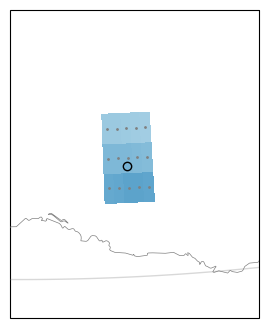

In [125]:

#========================
# select_IDs = ['23']
select_IDs = ordered_IDs
#========================

all_local_time = np.array([], dtype='datetime64[ns]')
all_local_u10 = np.array([])
all_local_v10 = np.array([])
all_local_ws = np.array([])
all_local_wd = np.array([])
all_local_msl = np.array([])

all_buoy_u = np.array([])
all_buoy_v = np.array([])
all_buoy_sp = np.array([])
all_buoy_dir = np.array([])
    
    
all_region_wd = np.array([])
all_region_ws = np.array([])
# region_wd
# region_ws


# open ERA5 data
#---------------
file = '/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2021.nc'
# file = '/Users/mackenziejewell/Desktop/ERA5_2021.nc'
ds_era = xr.open_dataset(file)
ds_era.close()
ERA_lons = ds_era.longitude.values
ERA_lats = ds_era.latitude.values
ERA_times = ds_era.time.values
    
    
for bb, buoy in enumerate(select_IDs):
    
    print(buoy)
    
    # grab buoy data
    #---------------
    lon_track = buoy_ds.longitude.sel(time=slice(TI, TF)).sel(buoyID = buoy).values
    lat_track = buoy_ds.latitude.sel(time=slice(TI, TF)).sel(buoyID = buoy).values
    time_track = pd.to_datetime(buoy_ds.time.sel(time=slice(TI, TF)).values)

    # calculate velocity
    #-------------------
    u, v, time, dx, dy, dist = calc_velocity(lon_track = lon_track, lat_track = lat_track, 
                                                 time_track = time_track, step = 2)
    
    # ice drift direction
    ice_dir = metpy.calc.wind_direction(u, v, convention='from')
    
    # flag unphysical velocities
    v_flag = np.sqrt(u**2+v**2) > velflag
    u[v_flag] = np.nan
    v[v_flag] = np.nan
    ice_dir[v_flag] = np.nan

    buoy_times = time_track[1::2]
    buoy_lons = lon_track[1::2]
    buoy_lats = lat_track[1::2]
    
    # remove all nans for times when buoy not present
    buoy_times = buoy_times[np.isnan(u)==False]
    buoy_lons = buoy_lons[np.isnan(u)==False]
    buoy_lats = buoy_lats[np.isnan(u)==False]
    
    # remove all nans for times when buoy not present
    ice_dir = ice_dir[np.isnan(u)==False]
    v = v[np.isnan(u)==False]
    u = u[np.isnan(u)==False]
    
    local_u10 = np.array([])
    local_v10 = np.array([])
    local_msl = np.array([])
    
    # find regional wind conditions at time of buoy data
    region_u_ = ds_ERA5.sel(time=slice(buoy_times[0], buoy_times[-1])).u.values
    region_v_ = ds_ERA5.sel(time=slice(buoy_times[0], buoy_times[-1])).v.values
    region_ws_ = np.sqrt(region_u_**2+region_v_**2)
    region_wdir_ = ds_ERA5.sel(time=slice(buoy_times[0], buoy_times[-1])).wind_dir.values

    all_region_wd = np.append(all_region_wd, region_wdir_)
    all_region_ws = np.append(all_region_ws, region_ws_)
    
    for ii in range(len(buoy_times)):
    
        lon = buoy_lons[ii]
        lat = buoy_lats[ii]
        tim = buoy_times[ii]
    
        tt = np.where(ERA_times == tim)[0][0]
        spec_ds = ds_era.sel(time = ds_era.time[tt])
        
        
        if spec_ds.u10.dims == ('latitude', 'longitude'):
            all_u10 = np.transpose(spec_ds.u10.values)
            all_v10 = np.transpose(spec_ds.v10.values)
            all_msl = np.transpose(spec_ds.msl.values)
        else:
            all_u10 = spec_ds.u10.values
            all_v10 = spec_ds.v10.values
            all_msl = spec_ds.msl.values
    
        if ERA_lats[0] > ERA_lats[1]:
            ERA_lats_ = ERA_lats[::-1]
            all_u10_ = all_u10[:,::-1]
            all_v10_ = all_v10[:,::-1]
            all_msl_ = all_msl[:,::-1]
        else:
            ERA_lats_ = ERA_lats
            all_u10_ = all_u10
            all_v10_ = all_v10
            all_msl_ = all_msl
    
        if bb == 0 and ii == 0:
            show_map = True
        else:
            show_map = False
            
        loc_u10, loc_v10 = interpolate_geo_data(interp_lon = lon, interp_lat = lat, 
                             lons = ERA_lons, lats = ERA_lats_,
                             data1 = all_u10_, data2 = all_v10_, 
                             buffer_lon = 2, buffer_lat = 1, show_map = show_map)
        loc_msl = interpolate_geo_data(interp_lon = lon, interp_lat = lat, 
                             lons = ERA_lons, lats = ERA_lats_,
                             data1 = all_msl_,
                             buffer_lon = 2, buffer_lat = 1, show_map = False)
        
        local_u10 = np.append(local_u10, loc_u10)
        local_v10 = np.append(local_v10, loc_v10)
        local_msl = np.append(local_msl, loc_msl)
    
#     local_u10, local_v10, local_msl = find_local_winds(buoy_lons, buoy_lats, buoy_times, refine=False)

    local_ws = np.sqrt(local_u10**2+local_v10**2)
    local_wd = metpy.calc.wind_direction(local_u10*units('m/s'), local_v10*units('m/s'), convention='from').magnitude

    all_local_time = np.append(all_local_time, pd.to_datetime(buoy_times))
    all_local_u10 = np.append(all_local_u10, local_u10)
    all_local_v10 = np.append(all_local_v10, local_v10)
    all_local_msl = np.append(all_local_msl, local_msl)
    all_local_ws = np.append(all_local_ws, local_ws)
    all_local_wd = np.append(all_local_wd, local_wd)
    
    all_buoy_u = np.append(all_buoy_u, u)
    all_buoy_v = np.append(all_buoy_v, v)                               
    all_buoy_sp = np.append(all_buoy_sp, np.sqrt(u**2+v**2))
    all_buoy_dir = np.append(all_buoy_dir, ice_dir)

    

### Version 2 (keep time info, even when some buoys missing)

In [126]:
# lat_grid = np.zeros((len(time), len(select_IDs)))
# lon_grid = np.zeros((len(time), len(select_IDs)))
# u_grid = np.zeros((len(time), len(select_IDs)))
# v_grid = np.zeros((len(time), len(select_IDs)))
# wu_grid = np.zeros((len(time), len(select_IDs)))
# wv_grid = np.zeros((len(time), len(select_IDs)))
# dx_grid = np.zeros((len(time), len(select_IDs)))
# dy_grid = np.zeros((len(time), len(select_IDs)))


In [127]:

# #========================
# # select_IDs = ['23']
# select_IDs = ordered_IDs
# #========================

# # open ERA5 data
# #---------------
# # file = '/Users/mackenziejewell/Desktop/ERA5_2021.nc'
# file = '/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2021.nc'
# ds_era = xr.open_dataset(file)
# ds_era.close()
# ERA_lons = ds_era.longitude.values
# ERA_lats = ds_era.latitude.values
# ERA_times = ds_era.time.values
    

# for bb, buoy in enumerate(select_IDs):
    
#     print(buoy)
    
#     # grab buoy data
#     #---------------
#     lon_track = buoy_ds.longitude.sel(time=slice(TI, TF)).sel(buoyID = buoy).values
#     lat_track = buoy_ds.latitude.sel(time=slice(TI, TF)).sel(buoyID = buoy).values
#     time_track = pd.to_datetime(buoy_ds.time.sel(time=slice(TI, TF)).values)
    
#     # grab buoy data
#     #---------------
#     lon_track = buoy_ds.longitude.sel(time=slice(TI, TF)).sel(buoyID = buoy).values
#     lat_track = buoy_ds.latitude.sel(time=slice(TI, TF)).sel(buoyID = buoy).values
#     time_track = pd.to_datetime(buoy_ds.time.sel(time=slice(TI, TF)).values)

#     # calculate velocity
#     #-------------------
#     u, v, time, dx, dy, dist = calc_velocity(lon_track = lon_track, lat_track = lat_track, 
#                                                  time_track = time_track, step = 2)

#     buoy_times = time_track[1::2]
#     buoy_lons = lon_track[1::2]
#     buoy_lats = lat_track[1::2]

#     local_u10 = np.array([])
#     local_v10 = np.array([])
#     local_msl = np.array([])

#     for ii in range(len(buoy_times)):

#         lon = buoy_lons[ii]
#         lat = buoy_lats[ii]
#         tim = buoy_times[ii]

#         if np.isnan(lon):
#             loc_u10 = np.nan
#             loc_v10 = np.nan
#             loc_msl = np.nan
            
#         else:  
#             tt = np.where(ERA_times == tim)[0][0]
#             spec_ds = ds_era.sel(time = ds_era.time[tt])


#             if spec_ds.u10.dims == ('latitude', 'longitude'):
#                 all_u10 = np.transpose(spec_ds.u10.values)
#                 all_v10 = np.transpose(spec_ds.v10.values)
#                 all_msl = np.transpose(spec_ds.msl.values)
#             else:
#                 all_u10 = spec_ds.u10.values
#                 all_v10 = spec_ds.v10.values
#                 all_msl = spec_ds.msl.values

#             if ERA_lats[0] > ERA_lats[1]:
#                 ERA_lats_ = ERA_lats[::-1]
#                 all_u10_ = all_u10[:,::-1]
#                 all_v10_ = all_v10[:,::-1]
#                 all_msl_ = all_msl[:,::-1]
#             else:
#                 ERA_lats_ = ERA_lats
#                 all_u10_ = all_u10
#                 all_v10_ = all_v10
#                 all_msl_ = all_msl

#             if bb == 0 and ii == 0:
#                 show_map = True
#             else:
#                 show_map = False

#             loc_u10, loc_v10 = interpolate_geo_data(interp_lon = lon, interp_lat = lat, 
#                                  lons = ERA_lons, lats = ERA_lats_,
#                                  data1 = all_u10_, data2 = all_v10_, 
#                                  buffer_lon = 2, buffer_lat = 1, show_map = show_map)
#             loc_msl = interpolate_geo_data(interp_lon = lon, interp_lat = lat, 
#                                  lons = ERA_lons, lats = ERA_lats_,
#                                  data1 = all_msl_,
#                                  buffer_lon = 2, buffer_lat = 1, show_map = False)

#         local_u10 = np.append(local_u10, loc_u10)
#         local_v10 = np.append(local_v10, loc_v10)
#         local_msl = np.append(local_msl, loc_msl)
        
#     lat_grid[:,bb] = buoy_lats
#     lon_grid[:,bb] = buoy_lons
#     u_grid[:,bb] = u
#     v_grid[:,bb] = v
#     dx_grid[:,bb] = dx
#     dy_grid[:,bb] = dy
#     wu_grid[:,bb] = local_u10
#     wv_grid[:,bb] = local_v10

Text(0, 0.5, 'wind-ice\ndeflection\nangle')

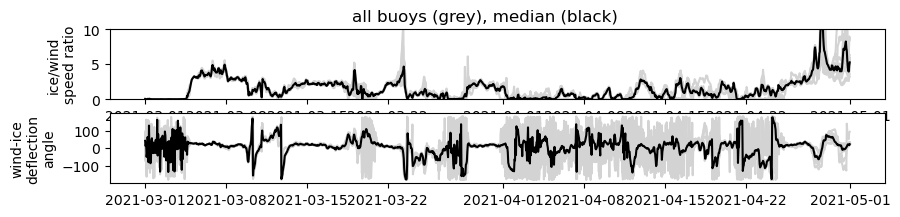

In [128]:
ice_speed = np.sqrt(u_grid**2+v_grid**2)
wind_speed = np.sqrt(wu_grid**2+wv_grid**2)

dot = wu_grid*u_grid + wv_grid*v_grid      # Dot product between [x1, y1] and [x2, y2]
det = wu_grid*v_grid - wv_grid*u_grid      # Determinant
angle = -np.arctan2(det, dot)*180/np.pi  # atan2(y, x) or atan2(sin, cos) 


fig, axs = plt.subplots(2,1,figsize=(10,2))
fig.suptitle('all buoys (grey), median (black)')
for bb in range(len(select_IDs)):
    
    axs[0].plot(time, ice_speed[:,bb]/wind_speed[:,bb], c='lightgray')
    axs[1].plot(time, angle[:,bb], c='lightgray')
    
axs[0].plot(time, np.nanmedian(ice_speed, axis=1)/ np.nanmedian(wind_speed, axis=1), c='k')
axs[0].set_ylim(0,10)
axs[0].set_ylabel('ice/wind\nspeed ratio')
axs[1].plot(time, np.nanmedian(angle, axis=1), c='k')
axs[1].set_ylabel('wind-ice\ndeflection\nangle')

### Save to file

In [129]:
# OUTPUT_FILE = './data/buoy_wind_MarchApril2021.nc'

# ds2 = xr.Dataset(
    
#     data_vars=dict(
#     latitude=(["time", "buoyID"], lat_grid, {"units": "degree_north"}),
#     longitude=(["time", "buoyID"], lon_grid, {"units": "degree_east"}),
#     ice_u=(["time", "buoyID"], u_grid, {"long_name":"east ice drift component","units": "degree_east"}),
#     ice_v=(["time", "buoyID"], v_grid, {"long_name":"north ice drift component","units": "degree_north"}),
#     ice_dx=(["time", "buoyID"], dx_grid, {"long_name":"eastward ice displacement","units": "degree_north"}),
#     ice_dy=(["time", "buoyID"], dy_grid, {"long_name":"northward ice displacement","units": "degree_east"}),
#     wind_u=(["time", "buoyID"], wu_grid, {"long_name":"east wind component", "units": "degree_east"}),
#     wind_v=(["time", "buoyID"], wv_grid, {"long_name":"north wind component", "units": "degree_north"}),
#     deflec_angle=(["time", "buoyID"], angle, {"long_name":"wind-to-ice deflection angle, CCW+", "units": "degree_CCW"}),

#     ),
    
#     coords=dict(
#         time = (["time"], time), 
#         buoyID = (["buoyID"], select_IDs)),
    
#     attrs=dict(description="Uses ERA5 (Hersbach et al., 2023) and interpolated buoy positions from cleaned HutchingsEtAl2023 data doi:10.18739/A2J678Z4N "),
#     )

# ds2

# if os.path.isfile(OUTPUT_FILE):
#     print(f'File already exists!!! Delete old version before saving new one.')
# else:
#     ds2.to_netcdf(path=OUTPUT_FILE, mode='w', format="NETCDF4")  
    
    

# Find conditions during opening events vs consolidated conditions

OA = open area

- openi events: OA(g>20% OWC) > 200 km2
- consolidated: OA(g>20% OWC) <= 200 km2

In [130]:
### Set whether to use local or regional wind conditions moving forward
#=================================
wind_dir = all_local_wd
wind_speed = all_local_ws
msl = all_local_msl
wind_u = all_local_u10
wind_v = all_local_v10

# wind_dir = all_region_wd#region_wd
# wind_speed = region_ws
# wind_u = region_u10
# wind_v = region_v10
#=================================

#================================================================
buoy_23_speed = all_buoy_sp.magnitude#speeds_regrid[ordered_IDs.index('23'),:].magnitude
buoy_23_dir = all_buoy_dir.magnitude#dirs_regrid[ordered_IDs.index('23'),:].magnitude
buoy_23_u = all_buoy_u #us_regrid[ordered_IDs.index('23'),:].magnitude
buoy_23_v = all_buoy_v #vs_regrid[ordered_IDs.index('23'),:].magnitude

dot = wind_u*buoy_23_u + wind_v*buoy_23_v      # Dot product between [x1, y1] and [x2, y2]
det = wind_u*buoy_23_v - wind_v*buoy_23_u      # Determinant
angle = -np.arctan2(det, dot)*180/np.pi  # atan2(y, x) or atan2(sin, cos) 
# sign reversed for RH (mathematical) coordinate system
# https://stackoverflow.com/questions/14066933/direct-way-of-computing-the-clockwise-angle-between-two-vectors
#================================================================



# create dictionary to store data from opening / closed ice conditions
open_close = {}
for cat in ['wind_dir', 'wind_speed', 'msl', 'buoy_dir', 'buoy_speed', 'speed_norm', 'dir_deflec']:
    open_close[cat] = {}
    for condition in ['open', 'close']:  
        open_close[cat][condition] = {}
        open_close[cat][condition]['data'] = np.array([])

for dd, dattetime in enumerate(all_local_time):
    
    if pd.to_datetime(all_local_time[dd]) in opening_dates_withhours:
        c = 'open'
        open_close['wind_dir'][c]['data']   = np.append(open_close['wind_dir'][c]['data'], wind_dir[dd])
        open_close['wind_speed'][c]['data'] = np.append(open_close['wind_speed'][c]['data'], wind_speed[dd])
        open_close['msl'][c]['data']        = np.append(open_close['msl'][c]['data'], msl[dd])
        open_close['buoy_dir'][c]['data'] = np.append(open_close['buoy_dir'][c]['data'], buoy_23_dir[dd])
        open_close['buoy_speed'][c]['data'] = np.append(open_close['buoy_speed'][c]['data'], buoy_23_speed[dd])
        open_close['speed_norm'][c]['data'] = np.append(open_close['speed_norm'][c]['data'], (buoy_23_speed/wind_speed)[dd])
        open_close['dir_deflec'][c]['data'] = np.append(open_close['dir_deflec'][c]['data'], angle[dd].magnitude)

#     else:-timedelta(hours = pd.to_datetime(all_local_time[dd]).hour)
#     elif pd.to_datetime(all_local_time[dd]) not in open_dates_withhours: 
    else:
        c = 'close'
        open_close['wind_dir'][c]['data']   = np.append(open_close['wind_dir'][c]['data'], wind_dir[dd])
        open_close['wind_speed'][c]['data'] = np.append(open_close['wind_speed'][c]['data'], wind_speed[dd])
        open_close['msl'][c]['data']        = np.append(open_close['msl'][c]['data'], msl[dd])
        open_close['buoy_dir'][c]['data'] = np.append(open_close['buoy_dir'][c]['data'], buoy_23_dir[dd])
        open_close['buoy_speed'][c]['data'] = np.append(open_close['buoy_speed'][c]['data'], buoy_23_speed[dd])
        open_close['speed_norm'][c]['data'] = np.append(open_close['speed_norm'][c]['data'], (buoy_23_speed/wind_speed)[dd])
        open_close['dir_deflec'][c]['data'] = np.append(open_close['dir_deflec'][c]['data'], angle[dd].magnitude)


[0.0 22.5 45.0 67.5 90.0 112.5 135.0 157.5 180.0 202.5 225.0 247.5 270.0 292.5 315.0 337.5] degree
[-11.25 11.25 33.75 56.25 78.75 101.25 123.75 146.25 168.75 191.25 213.75 236.25 258.75 281.25 303.75 326.25 348.75] degree
0.0 degree: -11.25 --- 11.25
22.5 degree: 11.25 --- 33.75
45.0 degree: 33.75 --- 56.25
67.5 degree: 56.25 --- 78.75
90.0 degree: 78.75 --- 101.25
112.5 degree: 101.25 --- 123.75
135.0 degree: 123.75 --- 146.25
157.5 degree: 146.25 --- 168.75
180.0 degree: 168.75 --- 191.25
202.5 degree: 191.25 --- 213.75
225.0 degree: 213.75 --- 236.25
247.5 degree: 236.25 --- 258.75
270.0 degree: 258.75 --- 281.25
292.5 degree: 281.25 --- 303.75
315.0 degree: 303.75 --- 326.25
337.5 degree: 326.25 --- 348.75


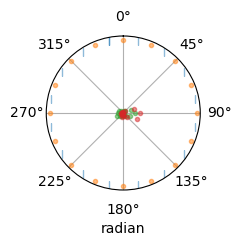

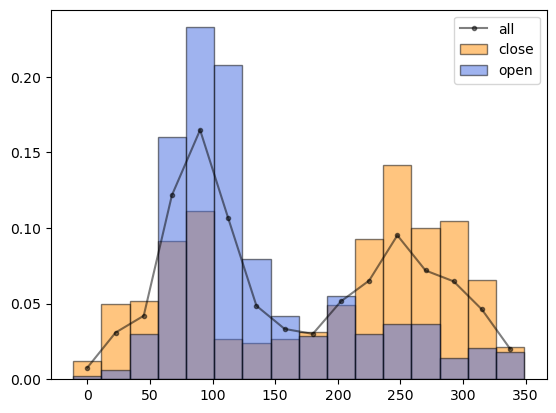

frequency of wind direction during events relative to other times
direction range: 78.75 - 146.25  :  [0.18332325 0.12874388 0.57347717 1.75617566 2.08917615 7.88637339
 3.27262742 1.56851011 0.91664231 1.11620848 0.32197878 0.25681301
 0.36459263 0.13794706 0.31843655 0.84799199]
 - 0.0 degree  :  0.18
 - 22.5 degree  :  0.13
 - 45.0 degree  :  0.57
 - 67.5 degree  :  1.76
 - 90.0 degree  :  2.09
 - 112.5 degree  :  7.89
 - 135.0 degree  :  3.27
 - 157.5 degree  :  1.57
 - 180.0 degree  :  0.92
 - 202.5 degree  :  1.12
 - 225.0 degree  :  0.32
 - 247.5 degree  :  0.26
 - 270.0 degree  :  0.36
 - 292.5 degree  :  0.14
 - 315.0 degree  :  0.32
 - 337.5 degree  :  0.85


In [131]:
STEP = 22.5#/2
bin_centers = np.arange(0,360,STEP)*units('degree')
bin_edges = np.arange(-STEP/2,360,STEP)*units('degree')

    
fig, ax = plt.subplots(figsize=(6,2), subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rticks([])
ax.plot(bin_edges.to('radian'), np.ones(len(bin_edges)), marker='|', alpha=0.5, lw=0)
ax.plot(bin_centers.to('radian'), np.ones(len(bin_centers)), marker='.', alpha=0.5, lw=0)
    
    
print(bin_centers)
print(bin_edges)


sums = np.array([])
open_sums = np.array([])
close_sums = np.array([])


for ee, edge0 in enumerate(bin_edges[:-1]):
    
    edge1 = bin_edges[ee+1]
    print(f'{bin_centers[ee]}: {edge0.magnitude} --- {edge1.magnitude}')
    sums = np.append(sums, np.sum((wind_dir*units('degree')>=edge0) & (wind_dir*units('degree')<edge1)))
    open_sums = np.append(open_sums, np.sum((open_close['wind_dir']['open']['data']*units('degree')>=edge0) & (open_close['wind_dir']['open']['data']*units('degree')<edge1)))
    close_sums = np.append(close_sums, np.sum((open_close['wind_dir']['close']['data']*units('degree')>=edge0) & (open_close['wind_dir']['close']['data']*units('degree')<edge1)))

freqs = sums/np.sum(sums)
open_freqs = open_sums/np.sum(open_sums)
close_freqs = close_sums/np.sum(close_sums)

ax.plot(bin_centers.to('radian'), freqs, marker='.', alpha=0.5, lw=0)
ax.plot(bin_centers.to('radian'), open_freqs, marker='.', alpha=0.5, lw=0)
plt.show()



plt.bar(bin_centers.magnitude, close_freqs,  facecolor='darkorange', edgecolor='k', alpha=0.5, label='close', width=STEP)
plt.bar(bin_centers.magnitude, open_freqs,  facecolor='royalblue', edgecolor='k', alpha=0.5, label='open', width=STEP)
plt.plot(bin_centers.magnitude, freqs, c='k', marker='.', alpha=0.5, label='all')
plt.legend()
plt.show()

favorable_bins = bin_centers[open_freqs > 2*close_freqs]
bound1 = favorable_bins[0].magnitude - STEP/2
bound2 = favorable_bins[-1].magnitude + STEP/2
print('frequency of wind direction during events relative to other times')
print(f'direction range: {bound1} - {bound2}  :  {open_freqs/close_freqs}')
for cc, center in enumerate(bin_centers):
    print(f' - {center}  :  {open_freqs[cc]/close_freqs[cc]:.2f}')


In [132]:


    
open_close['dir_deflec']['bmin'] = -180
open_close['dir_deflec']['bmax'] = 180
open_close['dir_deflec']['bwid'] = 10

open_close['wind_dir']['bmin'] = -11.25
open_close['wind_dir']['bmax'] = 338
open_close['wind_dir']['bwid'] = 22.5

open_close['wind_speed']['bmin'] = 0
open_close['wind_speed']['bmax'] = 15
open_close['wind_speed']['bwid'] = 0.5

open_close['msl']['bmin'] = 992
open_close['msl']['bmax'] = 1044
open_close['msl']['bwid'] = 2

open_close['buoy_dir']['bmin'] = -11.25
open_close['buoy_dir']['bmax'] = 338
open_close['buoy_dir']['bwid'] = 22.5

open_close['buoy_speed']['bmin'] = 0
open_close['buoy_speed']['bmax'] = 42
open_close['buoy_speed']['bwid'] = 2

open_close['speed_norm']['bmin'] = 0
open_close['speed_norm']['bmax'] = 5.25
open_close['speed_norm']['bwid'] = 0.25
    
    
for cat in ['dir_deflec', 'wind_dir', 'wind_speed', 'msl', 'buoy_dir', 'buoy_speed', 'speed_norm']:
    
    print(cat)
    
    data_cat = open_close[cat]
    
    bin_edges = np.arange(data_cat['bmin'], data_cat['bmax'] + data_cat['bwid'], data_cat['bwid'])
    bin_centers = np.arange(data_cat['bmin'] + data_cat['bwid']/2, data_cat['bmax'], data_cat['bwid'])
    data_cat['bin_edges'] = bin_edges
    data_cat['bin_centers'] = bin_centers
    
    open_sums = np.array([])
    close_sums = np.array([])

    for ee, edge0 in enumerate(bin_edges[:-1]):    
        edge1 = bin_edges[ee+1]
#         print(f'|{edge0} -- {bin_centers[ee]} -- {edge1}|')
        open_sums = np.append(open_sums, np.nansum((data_cat['open']['data']>=edge0) & (data_cat['open']['data']<edge1)))
        close_sums = np.append(close_sums, np.nansum((data_cat['close']['data']>=edge0) & (data_cat['close']['data']<edge1)))

    data_cat['open']['freq'] = open_sums/np.nansum(open_sums)
    data_cat['close']['freq'] = close_sums/np.nansum(close_sums)

#     plt.bar(data_cat['bin_centers'], data_cat['open']['freq'], width = data_cat['bwid'])
#     plt.bar(data_cat['bin_centers'], data_cat['close']['freq'], width = data_cat['bwid'])
#     plt.show()

dir_deflec
wind_dir
wind_speed
msl
buoy_dir
buoy_speed
speed_norm


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_70582/3165219245.py:50: RuntimeWarning: invalid value encountered in divide
  data_cat['open']['freq'] = open_sums/np.nansum(open_sums)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_70582/3165219245.py:51: RuntimeWarning: invalid value encountered in divide
  data_cat['close']['freq'] = close_sums/np.nansum(close_sums)


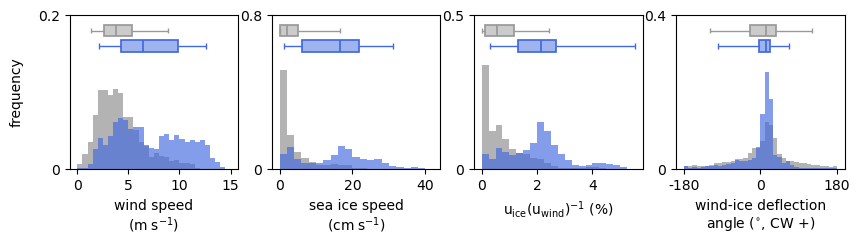

In [133]:


plot_categories = ['wind_speed', 'buoy_speed', 'speed_norm', 'dir_deflec']
category_labels = ['wind speed\n($\mathrm{m\;s^{-1}}$)', 
                   'sea ice speed\n($\mathrm{cm\;s^{-1}}$)', 
                   '$\mathrm{{u_{ice}}({u_{wind}})^{-1}}$ (%)', 
                   'wind-ice deflection\nangle ($^{\circ}$, CW +)']
xtick_labels = [[0,5,10,15], [0,20,40], [0,2,4,], [-180,0,180]]
ylims = [[0,0.2], [0,0.8], [0,0.5], [0,0.4]]


# plot_categories = ['msl', 'wind_speed', 'buoy_speed', 'speed_norm', 'dir_deflec']
# category_labels = ['sea level pressure\n(hPa)', 
#                    'wind speed\n($\mathrm{m\;s^{-1}}$)', 
#                    'sea ice speed\n($\mathrm{cm\;s^{-1}}$)', 
#                    '$\mathrm{{u_{ice}}({u_{wind}})^{-1}}$ (%)', 
#                    'wind-ice deflection\nangle ($^{\circ}$, CW +)']
# xtick_labels = [[980,1000,1020,1040], [0,5,10,15], [0,20,40], [0,2,4,], [-180,0,180]]
# ylims = [[0,0.3], [0,0.2], [0,0.8], [0,0.5], [0,0.4]]



fig, axs = plt.subplots(1,len(plot_categories), figsize=(10,2))
fig.subplots_adjust(wspace=0.2)

for cc, cat in enumerate(plot_categories):


    #=========================================
    ax = axs[cc]
    VAR1 = open_close[cat]['close']['data']
    VAR2 = open_close[cat]['open']['data']
    #=========================================

    ax.set_ylim(ylims[cc][0],ylims[cc][1])
    ax.set_xlabel(category_labels[cc])
    ax.set_xticks(xtick_labels[cc])
    ax.set_xticklabels(xtick_labels[cc])
    
    ax.set_yticks([ylims[cc][0],ylims[cc][1]])
    ax.set_yticklabels([ylims[cc][0],ylims[cc][1]], )
    
    if cc == 0:
        ax.set_ylabel('frequency',  rotation=90, labelpad=15, verticalalignment='center')

    
    
    H1 = 0.9*ax.get_ylim()[1]
    H2 = 0.8*ax.get_ylim()[1]
    ht = 0.075*ax.get_ylim()[1]
    
    ax.bar(open_close[cat]['bin_centers'], open_close[cat]['close']['freq'], width = open_close[cat]['bwid'],
          facecolor=[0.7,0.7,0.7], edgecolor='None', alpha = 1)
    ax.bar(open_close[cat]['bin_centers'], open_close[cat]['open']['freq'], width = open_close[cat]['bwid'],
          facecolor='royalblue', edgecolor='None', alpha = 0.65)
    
    
    
    
#     if cc != len(plot_categories)-1:
#     ax.scatter(np.percentile(VAR1, 50), H1, c='gray', clip_on=False)
#     ax.hlines(H1, np.percentile(VAR1, 5), np.percentile(VAR1, 95), linewidths=1, colors='gray', clip_on=False)
#     ax.hlines(H1, np.percentile(VAR1, 25), np.percentile(VAR1, 75), linewidths=5, alpha=0.5, colors='gray', clip_on=False)
    
    # add box plots
    #--------------
    VARS = [VAR1, VAR2]
    HGTS = [H1, H2]
    COLORS = [[0.6,0.6,0.6], 'royalblue']
    
    for vv, var in enumerate(VARS):

        h = HGTS[vv]
        c = COLORS[vv]
        
        # median
        ax.vlines(np.nanpercentile(var, 50), h-ht/2, h+ht/2, linewidths=1.25, colors=c, clip_on=False)
        
        # box facecolor
        ax.add_patch(plt.Rectangle((np.nanpercentile(var, 25),h-ht/2), np.nanpercentile(var, 75)-np.nanpercentile(var, 25), ht,
                                   facecolor=c,alpha=0.5, edgecolor='none', linewidth = 1.25))
        # box outline
        ax.add_patch(plt.Rectangle((np.nanpercentile(var, 25),h-ht/2), np.nanpercentile(var, 75)-np.nanpercentile(var, 25), ht,
                                   facecolor='none',alpha=1, edgecolor=c, linewidth = 1.25))
        # whiskers
        ax.hlines(h, np.nanpercentile(var, 75), np.nanpercentile(var, 95), linewidths=1, colors=c, clip_on=False)
        ax.vlines(np.nanpercentile(var, 95), h-ht/4, h+ht/4, linewidths=1, colors=c, clip_on=False)
        ax.hlines(h, np.nanpercentile(var, 5), np.nanpercentile(var, 25), linewidths=1, colors=c, clip_on=False)
        ax.vlines(np.nanpercentile(var, 5), h-ht/4, h+ht/4, linewidths=1, colors=c, clip_on=False)

        
#     else:
#         ax_t = ax.secondary_xaxis('top')
#         ax_t.tick_params(axis='x', direction='inout')
#         ax_t.set_xticks([0,90,180,270])
#         ax_t.set_xticklabels(['N','E','S','W'])
#         ax.add_patch(plt.Rectangle((75,0.435),125, 0.05,facecolor='red', alpha=0.25,
#                               clip_on=False,linewidth = 0,zorder=0))

    


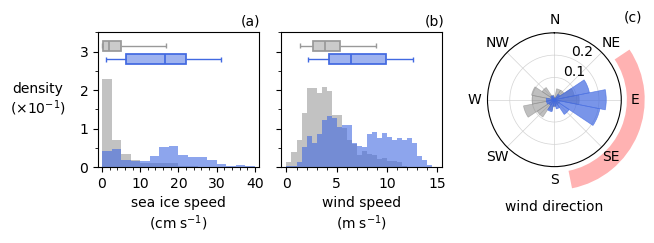

In [134]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6.75,1.75))

gs = GridSpec(1,4, width_ratios=[1.2,1.2,0.0, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3], projection='polar')

for edge in ['top', 'bottom', 'left', 'right']:
    ax2.spines[edge].set_linewidth(0)
ax2.set_xticks([])
ax2.set_yticks([])

for ax in [ax0, ax1]:
    ax.set_ylim([0, 0.35])
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
    
ax0.set_xlim([-1, 41])
ax0.xaxis.set_major_locator(plt.MultipleLocator(10))
ax0.xaxis.set_minor_locator(plt.MultipleLocator(2))
ax0.set_xlabel('sea ice speed\n($\mathrm{cm\;s^{-1}}$)',)
ax0.set_yticks(np.arange(0,0.4,0.1))
ax0.set_yticklabels(np.arange(0,4,1))
ax0.set_ylabel('density\n'+r'($\times$'+'$10^{-1}$)', rotation=0, labelpad=30, verticalalignment='center')
ax0.text(0.95*ax0.get_xlim()[1], 1.05*ax0.get_ylim()[1], '(a)', horizontalalignment = 'center')

ax1.set_xlim([-0.5, 15.5])
ax1.xaxis.set_major_locator(plt.MultipleLocator(5))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax1.set_xlabel('wind speed\n($\mathrm{m\;s^{-1}}$)', )
ax1.set_yticks(np.arange(0,0.4,0.1))
ax1.set_yticklabels([])
ax1.text(0.95*ax1.get_xlim()[1], 1.05*ax1.get_ylim()[1], '(b)', horizontalalignment = 'center')

#///////////////////////////////////////////////////
for ax, cat in zip([ax0, ax1],['buoy_speed', 'wind_speed']):

    VAR1 = open_close[cat]['close']['data']
    VAR2 = open_close[cat]['open']['data']

    if str(cat) == 'buoy_speed':
        bins = np.arange(0,42,2.5)
    else:
        bins = np.arange(0,16,0.5)
        
#     bins = open_close[cat]['bin_edges']
    
    ax.hist(VAR1, bins = bins, alpha=0.8, density=True, color=[0.7,0.7,0.7])
    ax.hist(VAR2, bins = bins, alpha=0.6, density=True, color='royalblue')
            
#     ax.bar(open_close[cat]['bin_centers'], open_close[cat]['close']['freq'], width = open_close[cat]['bwid'],
#           facecolor=[0.7,0.7,0.7], edgecolor='None', alpha = 1)
#     ax.bar(open_close[cat]['bin_centers'], open_close[cat]['open']['freq'], width = open_close[cat]['bwid'],
#           facecolor='royalblue', edgecolor='None', alpha = 0.65)


    # add box plots
    #--------------
    H1 = 0.9*ax.get_ylim()[1]
    H2 = 0.8*ax.get_ylim()[1]
    ht = 0.075*ax.get_ylim()[1]

    VARS = [VAR1, VAR2]
    HGTS = [H1, H2]
    COLORS = [[0.6,0.6,0.6], 'royalblue']

    for vv, var in enumerate(VARS):

        h = HGTS[vv]
        c = COLORS[vv]

        # median
        ax.vlines(np.nanpercentile(var, 50), h-ht/2, h+ht/2, linewidths=1.25, colors=c, clip_on=False)

        # box facecolor
        ax.add_patch(plt.Rectangle((np.nanpercentile(var, 25),h-ht/2), np.nanpercentile(var, 75)-np.nanpercentile(var, 25), ht,
                                   facecolor=c,alpha=0.5, edgecolor='none', linewidth = 1.25))
        # box outline
        ax.add_patch(plt.Rectangle((np.nanpercentile(var, 25),h-ht/2), np.nanpercentile(var, 75)-np.nanpercentile(var, 25), ht,
                                   facecolor='none',alpha=1, edgecolor=c, linewidth = 1.25))
        # whiskers
        ax.hlines(h, np.nanpercentile(var, 75), np.nanpercentile(var, 95), linewidths=1, colors=c, clip_on=False)
        ax.vlines(np.nanpercentile(var, 95), h-ht/4, h+ht/4, linewidths=1, colors=c, clip_on=False)
        ax.hlines(h, np.nanpercentile(var, 5), np.nanpercentile(var, 25), linewidths=1, colors=c, clip_on=False)
        ax.vlines(np.nanpercentile(var, 5), h-ht/4, h+ht/4, linewidths=1, colors=c, clip_on=False)

#///////////////////////////////////////////////////    
    
# wind direction plot
#///////////////////////////////////////////////////
ax = ax3
FS1 = FS
FS2 = FS-2

xticks = np.arange(0,2*np.pi,np.pi/4)
xticklabels = ['N', 'NE',  'E',  'SE', 'S',  'SW',  'W',  'NW', ]

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(xticks)
ax.set_xticklabels([])
for tt in range(len(xticks)):
    ax.text(xticks[tt], 0.36, xticklabels[tt], ha='center', va='center', 
            transform=ax.transData, rotation=0)

ax.set_rticks([0.1,0.2,])
ax.set_rlim(0,0.3)
ax.set_yticklabels(['0.1','0.2'])
ax.grid(linewidth=0.5, zorder=-10, c='lightgray')

bin_centers = open_close['wind_dir']['bin_centers'] * units('degree')
bin_width = open_close['wind_dir']['bwid']

ax.bar(bin_centers.to('radians').magnitude, open_close['wind_dir']['close']['freq'], width=(bin_width*np.pi/180), 
       bottom=0.0, facecolor=[0.5,0.5,0.5], edgecolor=[0.5,0.5,0.5],lw=0.5, alpha=0.5, zorder=1)
ax.bar(bin_centers.to('radians').magnitude, open_close['wind_dir']['open']['freq'], width=(bin_width*np.pi/180), 
       bottom=0.0, facecolor='royalblue', edgecolor='royalblue',lw=0.5, alpha=0.7, zorder=1)


# bin_width = (191.25-78.75)
bin_width = (168.75-56.25)
bin_center = 56.25 + 0.5*bin_width

ax.bar((bin_center*np.pi/180), 0.08, width=(bin_width*np.pi/180), bottom=0.325, 
       edgecolor='none', facecolor='r', alpha=0.3, clip_on=False, zorder=-100)
    
for axis in ax._get_axis_list():
    axis.set_zorder(-1)
    
ax.text(np.pi, 0.5, 'wind direction', horizontalalignment = 'center')
ax.text(np.pi/4, 0.5, '(c)', horizontalalignment = 'center')
#///////////////////////////////////////////////////    
    
    
gs.update(wspace=0.2, hspace=0)

# perform kernel density distrubition estimations

Open: N = 12730
Closed: N = 16400


(<matplotlib.colorbar.Colorbar at 0x7fb45b046d30>, <Axes:xlabel='frequency'>)

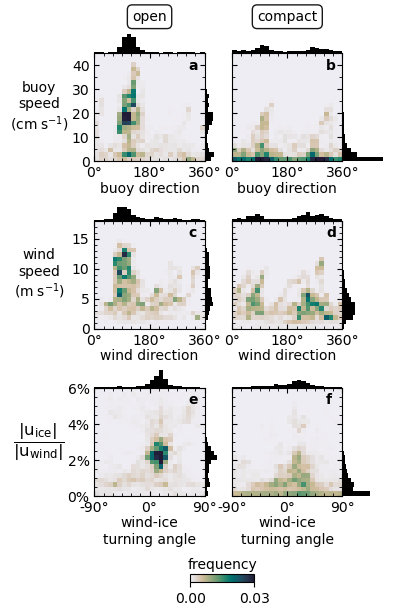

In [135]:
import matplotlib.patches as patches 
from scipy import stats

def add_boxplot(ax, data, side=1, width=20):
    xw = width
    yw = np.percentile(data, 75)-np.percentile(data, 25)
    x1 = ax.get_xlim()[side]*1.05
    y1 = np.percentile(data, 25)
    rect = patches.Rectangle((x1, y1), xw, yw, linewidth=1.5, edgecolor='k', facecolor='lightgray', 
                             alpha=1, clip_on=False, zorder=10)       
    ax.add_patch(rect)

    xw = width
    yw = np.percentile(data, 50)-np.percentile(data, 25)
    x1 = ax.get_xlim()[side]*1.05
    y1 = np.percentile(data, 25)
    rect = patches.Rectangle((x1, y1), xw, yw, linewidth=1.5, edgecolor='k', facecolor='lightgray', 
                             alpha=1, clip_on=False, zorder=10)       
    ax.add_patch(rect)


def add_simple_boxplot(ax, data, side=1, width=5):
    ax.vlines(ax.get_xlim()[1]*0.05, np.percentile(data, 25), np.percentile(data, 75), 
              linewidths=2,  colors='k', alpha=1,  zorder=9, clip_on=False)
    
    ax.scatter(ax.get_xlim()[1]*0.05, np.percentile(data, 50),linewidth=1.5,  facecolor='gold', edgecolor='k', 
               marker='o', s=50, zorder=10, clip_on=False)
    
def add_panel_label(ax, label):
    ax.text(ax.get_xlim()[0] + 0.85*(ax.get_xlim()[1]-ax.get_xlim()[0]),
            ax.get_ylim()[0] + 0.85*(ax.get_ylim()[1]-ax.get_ylim()[0]), 
            label, weight='bold',
         bbox=dict(facecolor='None', alpha=0.9, edgecolor='None', boxstyle='round,pad=0.25'),
         c='k',  horizontalalignment='left')

    
def creat_1d_histogram_T(ax, xx, x_edges, scale = 0.1):
    
    out = np.histogram(xx, bins=x_edges, density=False)
    zz = out[0]
    w = x_edges[1]-x_edges[0]
    xx_center = out[1][:-1] + w/2
    z_max = np.max(zz)
    plot_width = (ax.get_ylim()[-1]-ax.get_ylim()[0])
    scaling = plot_width*scale/(len(xx))#/(plot_width*scale)/(z_max)
    
    ax.bar(xx_center, scaling*zz, w, bottom=ax.get_ylim()[-1], color='k', clip_on=False)
    
def creat_1d_histogram_R(ax, yy, y_edges, scale = 0.1):
    
    out = np.histogram(yy, bins=y_edges, density=False)
    zz = out[0]
    w = y_edges[1]-y_edges[0]
    yy_center = out[1][:-1] + w/2

    z_max = np.max(zz)
    plot_width = (ax.get_xlim()[-1]-ax.get_xlim()[0])
    scaling = plot_width*scale/len(yy)#/(plot_width*scale)/(z_max)
    
    ax.barh(yy_center, scaling*zz, w, left=ax.get_xlim()[-1], color='k', clip_on=False)




def create_2d_histogram(x_vals, y_vals, x_edges, y_edges, density=False):

    values = np.vstack([x_vals, y_vals])
    
    # kernel density stuff
    # X, Y = np.mgrid[xmin:xmax:30j, ymin:ymax:30j]
    # positions = np.vstack([X.ravel(), Y.ravel()])
    # kernel = stats.gaussian_kde(values, bw_method = bw_method)
    # Z_op = np.reshape(kernel(positions).T, X.shape)
#     ax0.pcolormesh(X,Y,1000*Z_cl, cmap=cmocean.cm.dense, vmin=0, vmax=5)

    # ax3.scatter(m1_op[::sp], m2_op[::sp], color=point_color, s=point_size, marker=point_marker)
    bins = (x_edges, y_edges)

    
    out = plt.hist2d(values[0,:], values[1,:], bins=bins, density = density);
    Z = np.transpose(out[0])/len(x_vals)
    X = np.transpose(out[1])
    Y = np.transpose(out[2])
    
    return X, Y, Z    
    
    
point_size = 1
point_color = [0.4,0.4,0.4]
sp = 1
point_marker='.'
bw_method = 'scott'


cmap = cmocean.cm.rain

vmax = 0.03
vmin = 0

ny = 25
nx = 25

scale = 0.75

fig = plt.figure(figsize=(3.2,5.75), facecolor='white')

gs = GridSpec(3,2, width_ratios=[1,1,], height_ratios=[1,1,1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3])
ax4 = fig.add_subplot(gs[4])
ax5 = fig.add_subplot(gs[5])


gs.update(wspace=0.25, hspace=0.55)

    
#////////////////////////////////////////////////////////////////////
# TOP ROW
#////////////////////////////////////////////////////////////////////

Rscale = scale
Tscale = scale

xmin, xmax = 0, 360
ymin, ymax = 0, 45
x_edges = np.linspace(xmin, xmax, nx)
y_edges = np.linspace(ymin, ymax, ny)
    
    
for ax in [ax0, ax1,]:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.xaxis.set_major_locator(plt.MultipleLocator(180))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(30))
    ax.yaxis.set_major_locator(plt.MultipleLocator(10))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
    ax.set_xlabel('buoy direction', labelpad=1)
    ax.xaxis.set_major_formatter('{x:.0f}°')

ax = ax0
ax.text(ax.get_xlim()[0] + 0.5*(ax.get_xlim()[1]-ax.get_xlim()[0]),1.3*ax.get_ylim()[1], 
        'open', bbox=dict(facecolor='white', alpha=0.9, edgecolor='k', boxstyle='round,pad=0.35'),
         c='k',  horizontalalignment='center')
ax = ax1
ax.text(ax.get_xlim()[0] + 0.5*(ax.get_xlim()[1]-ax.get_xlim()[0]),1.3*ax.get_ylim()[1], 
        'compact', bbox=dict(facecolor='white', alpha=0.9, edgecolor='k', boxstyle='round,pad=0.35'),
         c='k',  horizontalalignment='center')

ax0.text(ax0.get_xlim()[0]-180, 0.5*ax0.get_ylim()[1], 'buoy\nspeed\n($\mathrm{cm\;s^{-1}}$)',   horizontalalignment='center', verticalalignment='center')


print(f"Open: N = {len(open_close['buoy_dir']['open']['data'])}")
print(f"Closed: N = {len(open_close['buoy_dir']['close']['data'])}")

# opening buoy
#-------------
xx = open_close['buoy_dir']['open']['data']
yy = open_close['buoy_speed']['open']['data']

ax = ax0

X, Y, Z = create_2d_histogram(xx, yy, x_edges, y_edges)
ax.pcolormesh(X,Y,Z, cmap=cmap, vmin=vmin, vmax=vmax)
creat_1d_histogram_T(ax, xx, x_edges, scale = Tscale)
creat_1d_histogram_R(ax, yy, y_edges, scale = Rscale)


# closing buoy
#------------
xx = open_close['buoy_dir']['close']['data']
yy = open_close['buoy_speed']['close']['data']

ax = ax1

X, Y, Z = create_2d_histogram(xx, yy, x_edges, y_edges)
ax.pcolormesh(X,Y,Z, cmap=cmap, vmin=vmin, vmax=vmax)
creat_1d_histogram_T(ax, xx, x_edges, scale = Tscale)
creat_1d_histogram_R(ax, yy, y_edges, scale = Rscale)

#////////////////////////////////////////////////////////////////////
# MIDDLE ROW
#////////////////////////////////////////////////////////////////////

Rscale = scale
Tscale = scale

xmin, xmax = 0, 360
ymin, ymax = 0, 18
x_edges = np.linspace(xmin, xmax, nx)
y_edges = np.linspace(ymin, ymax, ny)

for ax in [ax2, ax3,]:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.xaxis.set_major_locator(plt.MultipleLocator(180))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(30))
    ax.xaxis.set_major_formatter('{x:.0f}°')
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.set_xlabel('wind direction', labelpad=1)

ax2.text(ax2.get_xlim()[0]-180, 0.5*ax2.get_ylim()[1], 'wind\nspeed\n($\mathrm{m\;s^{-1}}$)',   horizontalalignment='center', verticalalignment='center')
    
    
# opening wind
#-------------
xx = open_close['wind_dir']['open']['data']
yy = open_close['wind_speed']['open']['data']

ax = ax2

X, Y, Z = create_2d_histogram(xx, yy, x_edges, y_edges)
ax.pcolormesh(X,Y,Z, cmap=cmap, vmin=vmin, vmax=vmax)
creat_1d_histogram_T(ax, xx, x_edges, scale = Tscale)
creat_1d_histogram_R(ax, yy, y_edges, scale = Rscale)

# closing wind
#-------------
xx = open_close['wind_dir']['close']['data']
yy = open_close['wind_speed']['close']['data']

ax = ax3

X, Y, Z = create_2d_histogram(xx, yy, x_edges, y_edges)
ax.pcolormesh(X,Y,Z, cmap=cmap, vmin=vmin, vmax=vmax)
creat_1d_histogram_T(ax, xx, x_edges, scale = Tscale)
creat_1d_histogram_R(ax, yy, y_edges, scale = Rscale)


#////////////////////////////////////////////////////////////////////
# BOTTOM ROW
#////////////////////////////////////////////////////////////////////

Rscale = scale
Tscale = scale

xmin, xmax = -90, 90
ymin, ymax = 0, 6
x_edges = np.linspace(xmin, xmax, nx)
y_edges = np.linspace(ymin, ymax, ny)

for ax in [ax4, ax5,]:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.xaxis.set_major_formatter('{x:.0f}°')
    ax.yaxis.set_major_formatter('{x:.0f}%')
    ax.xaxis.set_major_locator(plt.MultipleLocator(90))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(15))
    ax.yaxis.set_major_locator(plt.MultipleLocator(2))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('wind-ice\nturning angle', labelpad=1)

ax4.text(ax4.get_xlim()[0]-90, 0.5*ax4.get_ylim()[1], r'$\mathrm{\dfrac{|u_{ice}|}{|u_{wind}|}}$',   horizontalalignment='center', verticalalignment='center', fontsize = FS+2)


# opening buoy/wind
#------------------
xx = open_close['dir_deflec']['open']['data']
yy = open_close['speed_norm']['open']['data']

ax = ax4

X, Y, Z = create_2d_histogram(xx, yy, x_edges, y_edges)
out = ax.pcolormesh(X,Y,Z, cmap=cmap, vmin=vmin, vmax=vmax)
creat_1d_histogram_T(ax, xx, x_edges, scale = Tscale)
creat_1d_histogram_R(ax, yy, y_edges, scale = Rscale)


# closing buoy/wind
#------------------
xx = open_close['dir_deflec']['close']['data']
yy = open_close['speed_norm']['close']['data']

ax = ax5

X, Y, Z = create_2d_histogram(xx, yy, x_edges, y_edges)
ax.pcolormesh(X,Y,Z, cmap=cmap, vmin=vmin, vmax=vmax)
creat_1d_histogram_T(ax, xx, x_edges, scale = Tscale)
creat_1d_histogram_R(ax, yy, y_edges, scale = Rscale)
    
    
    
for ax in [ax0,  ax2,ax4]:
#     ax.set_xlim([0,360])
#     ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=False)
#     ax.tick_params(axis='x', which='both', direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', which='both', direction='in')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='both', direction='in')

for ax in [ax1,  ax3, ax5]:
#     ax.set_xlim([0,360])
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', which='both', direction='in')
    ax.set_yticklabels([])
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='both', direction='in')
    
add_panel_label(ax0, 'a')
add_panel_label(ax1, 'b')
add_panel_label(ax2, 'c')
add_panel_label(ax3, 'd')
add_panel_label(ax4, 'e')
add_panel_label(ax5, 'f')

add_colorbar(fig, ax4, [out], cb_placement='left', cb_orientation='horizontal', 
             cb_width=0.2, cb_length_fraction=[-0.8,-0.725], 
             cb_pad=-0.5, cb_ticks=[0,vmax], cb_ticklabels='auto', 
             cb_extend='neither', cb_label='frequency', labelpad='auto',
             cb_label_placement='top', cb_tick_placement='auto', 
             cb_labelsize=FS)

# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigI/DriftRegimes_v3.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=False, bbox_inches="tight", pad_inches = 0.1, dpi=300)

turning angle range: [ 0.  5. 10. 15. 20. 25. 30.]
speed ratio range: [1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]

open: 43.9% of data fall in range
close: 8.8% of data fall in range


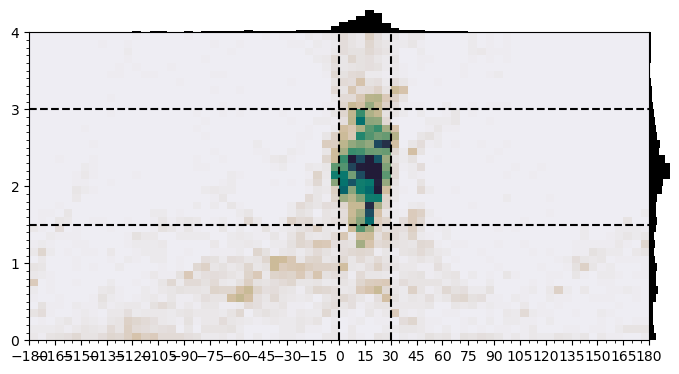

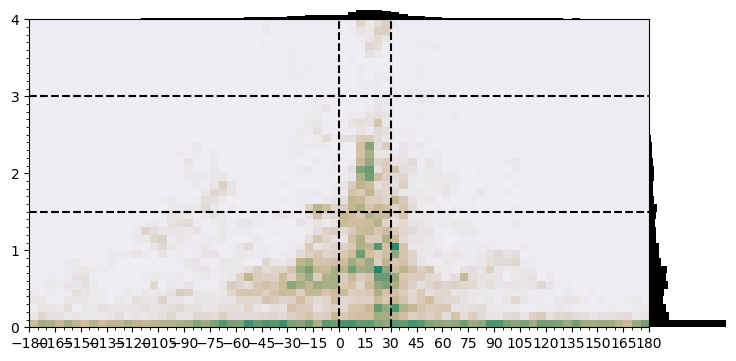

In [136]:
def create_2d_histogram(x_vals, y_vals, x_edges, y_edges, density=False):

    values = np.vstack([x_vals, y_vals])
    bins = (x_edges, y_edges)
    out = np.histogram2d(values[0,:], values[1,:], bins=bins, density = density);
    Z = np.transpose(out[0])/len(x_vals)
    X = np.transpose(out[1])
    Y = np.transpose(out[2])
    return X, Y, Z
    
def make_plot(X,Y,Z, xmin, xmax, ymin, ymax):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.pcolormesh(X,Y,Z, cmap=cmocean.cm.rain, vmin=0, vmax=0.01)
    ax.hlines(Y[yf], xmin, xmax, colors='k', linestyles='dashed')
    ax.hlines(Y[yi], xmin, xmax, colors='k', linestyles='dashed')
    ax.vlines(X[xf], ymin, ymax, colors='k', linestyles='dashed')
    ax.vlines(X[xi], ymin, ymax, colors='k', linestyles='dashed')
    ax.xaxis.set_major_locator(plt.MultipleLocator(15))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    return fig, ax
    

ny = 41
nx = 73

xmin, xmax = -180, 180
ymin, ymax = 0, 4
x_edges = np.linspace(xmin, xmax, nx)
y_edges = np.linspace(ymin, ymax, ny)


# create first distribution
xx = open_close['dir_deflec']['open']['data']
yy = open_close['speed_norm']['open']['data']
X, Y, Z = create_2d_histogram(xx, yy, x_edges, y_edges);


# crop to desired bounds
# yi = 6
# yf = 13

# xi = 12
# xf = 17

yi = np.where(Y == 1.5)[0][0]
yf = np.where(Y == 3)[0][0]

xi = np.where(X == 0)[0][0]
xf = np.where(X == 30)[0][0]

print(f'turning angle range: {X[xi:xf+1]}')
print(f'speed ratio range: {Y[yi:yf+1]}\n')

# plot

fig, ax = make_plot(X,Y,Z, xmin, xmax, ymin, ymax)
creat_1d_histogram_T(ax, xx, x_edges, scale = 0.5)
creat_1d_histogram_R(ax, yy, y_edges, scale = 0.5)
print(f'open: {100*np.sum(Z[yi:yf,xi:xf]):.1f}% of data fall in range')


# create first distribution
xx = open_close['dir_deflec']['close']['data']
yy = open_close['speed_norm']['close']['data']
X, Y, Z = create_2d_histogram(xx, yy, x_edges, y_edges);

# plot
fig, ax = make_plot(X,Y,Z, xmin, xmax, ymin, ymax)
creat_1d_histogram_T(ax, xx, x_edges, scale = 0.5)
creat_1d_histogram_R(ax, yy, y_edges, scale = 0.5)
print(f'close: {100*np.sum(Z[yi:yf,xi:xf]):.1f}% of data fall in range')

Text(0.5, 0, 'wind direction')

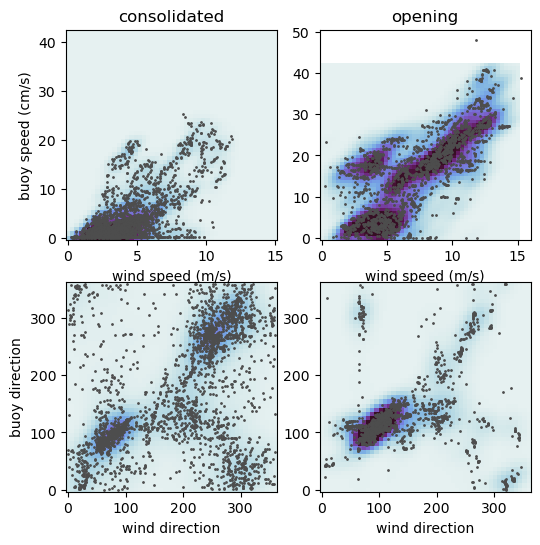

In [137]:
xmin, xmax = 0, 15
xw = 0.5
x_kernel = np.linspace(xmin, xmax, 100)
x_edges = np.arange(xmin, xmax+xw, xw)

ymin, ymax = 0, 42
yw = 1
y_kernel = np.linspace(ymin, ymax, 100)
y_edges = np.arange(ymin, ymax+yw, yw)

point_color = [0.3,0.3,0.3]

fig = plt.figure(figsize=(6,6))

gs = GridSpec(2,2, width_ratios=[1,1,], height_ratios=[1,1,])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3])


# closing, 2D
#------------
m1_cl = open_close['wind_speed']['close']['data']
m2_cl = open_close['buoy_speed']['close']['data']

X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1_cl, m2_cl])
kernel = stats.gaussian_kde(values)
Z_cl = np.reshape(kernel(positions).T, X.shape)

ax0.pcolormesh(X,Y,Z_cl, cmap=cmocean.cm.dense, vmin=0,vmax=0.02)
ax0.scatter(m1_cl[::6], m2_cl[::6], color=point_color, s=1)
ax0.set_xlabel('wind speed (m/s)')
ax0.set_ylabel('buoy speed (cm/s)')
ax0.set_title('consolidated')

# opening, 2D
#------------
m1_op = open_close['wind_speed']['open']['data']
m2_op = open_close['buoy_speed']['open']['data']

X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1_op, m2_op])
kernel = stats.gaussian_kde(values)
Z_op = np.reshape(kernel(positions).T, X.shape)

ax1.pcolormesh(X,Y,Z_op, cmap=cmocean.cm.dense, vmin=0,vmax=0.006)
ax1.scatter(m1_op[::6], m2_op[::6], color=point_color, s=1)
ax1.set_xlabel('wind speed (m/s)')
ax1.set_title('opening')

xmin, xmax = 0, 360
xw = 15
x_kernel = np.linspace(xmin, xmax, 100)
x_edges = np.arange(xmin, xmax+xw, xw)

ymin, ymax = 0, 360
yw = 15
y_kernel = np.linspace(ymin, ymax, 100)
y_edges = np.arange(ymin, ymax+yw, yw)


# opening, 2D
#------------
m1_cl = open_close['wind_dir']['close']['data']
m2_cl = open_close['buoy_dir']['close']['data']

X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1_cl, m2_cl])
kernel = stats.gaussian_kde(values)
Z_cl = np.reshape(kernel(positions).T, X.shape)

ax2.pcolormesh(X,Y,Z_cl, cmap=cmocean.cm.dense, vmin=0,vmax=0.0001)
ax2.scatter(m1_cl[::6], m2_cl[::6], color=point_color, s=1)
ax2.set_xlabel('wind direction')
ax2.set_ylabel('buoy direction')

# opening, 2D
#------------
m1_op = open_close['wind_dir']['open']['data']
m2_op = open_close['buoy_dir']['open']['data']

X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1_op, m2_op])
kernel = stats.gaussian_kde(values)
Z_op = np.reshape(kernel(positions).T, X.shape)

ax3.pcolormesh(X,Y,Z_op, cmap=cmocean.cm.dense, vmin=0,vmax=0.0001)
ax3.scatter(m1_op[::6], m2_op[::6], color=point_color, s=1)
ax3.set_xlabel('wind direction')


In [138]:

from scipy import stats

xmin, xmax = -90, 90
xw = 5
x_kernel = np.linspace(xmin, xmax, 100)
x_edges = np.arange(xmin, xmax+xw, xw)

ymin, ymax = 0, 6
yw = 0.2
y_kernel = np.linspace(ymin, ymax, 100)
y_edges = np.arange(ymin, ymax+yw, yw)


# closing, 2D
#------------
m1_cl = open_close['dir_deflec']['close']['data']
m2_cl = open_close['speed_norm']['close']['data']

X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1_cl, m2_cl])
kernel = stats.gaussian_kde(values)
Z_cl = np.reshape(kernel(positions).T, X.shape)

# closing, 1D direction
#----------------------
kernel = stats.gaussian_kde(m1_cl)
dir_kernel_cl = kernel(x_kernel)

# closing, 1D speed norm
#-----------------------
kernel = stats.gaussian_kde(m2_cl)
norm_kernel_cl = kernel(y_kernel)


# opening, 2D
#------------
m1_op = open_close['dir_deflec']['open']['data']
m2_op = open_close['speed_norm']['open']['data']

X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1_op, m2_op])
kernel = stats.gaussian_kde(values)
Z_op = np.reshape(kernel(positions).T, X.shape)


# opening, 1D direction
#----------------------
kernel = stats.gaussian_kde(m1_op)
dir_kernel_op = kernel(x_kernel)

# opening, 1D speed norm
#-----------------------
kernel = stats.gaussian_kde(m2_op)
norm_kernel_op = kernel(y_kernel)



# axs[0].set_title('consolidated')
# axs[0].set_xlim([xmin, xmax])
# axs[0].set_ylim([ymin, ymax])

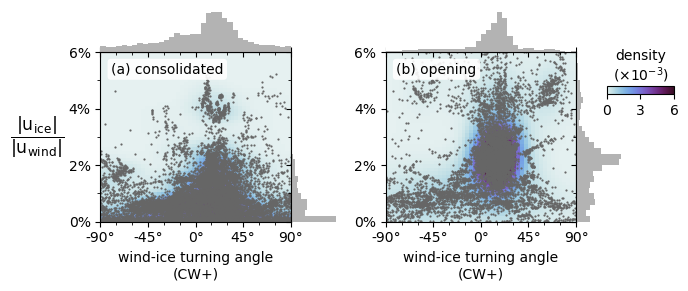

In [139]:


dot_color = [0.4,0.4,0.4]
bar_color = [0.7,0.7,0.7]
text_color = 'k'


from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6.75,2.75))

gs = GridSpec(2,5, width_ratios=[4,1,1,4,1], height_ratios=[1,4])

ax7 = fig.add_subplot(gs[7])

ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])

ax4 = fig.add_subplot(gs[4])
ax5 = fig.add_subplot(gs[5])
ax6 = fig.add_subplot(gs[6])

ax8 = fig.add_subplot(gs[8])
ax9 = fig.add_subplot(gs[9])

ax0 = fig.add_subplot(gs[0])
ax3 = fig.add_subplot(gs[3])

for ax in [ax1,ax2,ax4, ax7]:
    ax.set_xticks([])
    ax.set_yticks([])
    for edge in ['top', 'bottom', 'left', 'right']:
        ax.spines[edge].set_linewidth(0)
        ax.spines[edge].set_edgecolor('None')

for ax in [ax5,ax8]:
#     ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=False)
#     ax.tick_params(axis='x', which='both', direction='in')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='both', direction='out')

# axX5 = ax5.secondary_xaxis("top")
# axX5.tick_params(axis="x", which='both', direction="out")
# axX8 = ax8.secondary_xaxis("top")
# axX8.tick_params(axis="x", which='both', direction="out")
    

for ax in [ax0, ax3, ax5,ax8]:
    ax.set_xlim([xmin, xmax])
    ax.xaxis.set_major_locator(plt.MultipleLocator(45))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(15))
    
for ax in [ax5,ax8, ax6, ax9]:
    ax.set_ylim([ymin, ymax])
    ax.yaxis.set_major_locator(plt.MultipleLocator(2))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
    
# right plot hists
for ax in [ax6, ax9]:
    ax.set_yticklabels([])
    for edge in ['top', 'bottom', 'right']:
        ax.spines[edge].set_linewidth(0)
    ax.set_xticks([])
    
# top plot hists
for ax in [ax0, ax3]:
    ax.set_xticklabels([])
    for edge in ['top', 'left', 'right']:
        ax.spines[edge].set_linewidth(0)
    ax.set_yticks([])


gs.update(wspace=0, hspace=0)
        
    

# consolidated data
#------------------
# 2D
ax5.pcolormesh(X, Y, 1000*Z_cl, cmap=cmocean.cm.dense, vmin=0, vmax=6)
ax5.scatter(m1_cl[::1], m2_cl[::1], marker='.', lw=0, color=dot_color, s=10)
ax5.text(ax5.get_xlim()[0]+10, 0.875*ax5.get_ylim()[1], '(a) consolidated',
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='None', boxstyle='round,pad=0.25'),
         c=text_color,  horizontalalignment='left')
ax5.text(ax5.get_xlim()[0]-60, 0.5*ax5.get_ylim()[1], r'$\mathrm{\dfrac{|u_{ice}|}{|u_{wind}|}}$',   horizontalalignment='center', verticalalignment='center', fontsize = FS+2.5)
# ax5.text(ax5.get_xlim()[0]-30, 0.5*ax5.get_ylim()[1], '(%)',   horizontalalignment='center', verticalalignment='center')
ax5.set_xlabel('wind-ice turning angle\n(CW+)')
ax5.xaxis.set_major_formatter('{x:.0f}°')
ax5.yaxis.set_major_formatter('{x:.0f}%')

# 1D direction
# ax0.plot(x_kernel, dir_kernel_cl, c='k')
ax0.hist(m1_cl, bins=x_edges, color=bar_color, density=True);
# ax0.set_ylim(0,0.02)
# ax0.set_yticks([0,0.02])
# ax0.set_yticklabels(['0','2'])
# ax0.text(ax0.get_xlim()[0], 1.1*ax0.get_ylim()[1], ' $10^{-2}$', horizontalalignment='center')
# ax0.set_ylabel('$d$', rotation=0, labelpad=10, verticalalignment='center')
    
# 1D speed norm
# ax6.plot(norm_kernel_cl, y_kernel, c='k')
ax6.hist(m2_cl, bins=y_edges, color=bar_color, density=True, orientation='horizontal');


# opening data
#-------------
# 2D
out = ax8.pcolormesh(X, Y, 1000*Z_op, cmap=cmocean.cm.dense, vmin=0, vmax=6)
ax8.scatter(m1_op[::1], m2_op[::1], marker='.', lw=0, color=dot_color, s=10)
ax8.text(ax8.get_xlim()[0]+10, 0.875*ax8.get_ylim()[1], '(b) opening',
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='None', boxstyle='round,pad=0.25'),
         c=text_color,  horizontalalignment='left')
ax8.set_xlabel('wind-ice turning angle\n(CW+)')
ax8.xaxis.set_major_formatter('{x:.0f}°')
add_colorbar(fig, ax9, [out], cb_placement='right', cb_orientation='horizontal', 
             cb_width=0.1, cb_length_fraction=[0.75,0.8], 
             cb_pad=-0.025, cb_ticks=[0,3,6], cb_ticklabels='auto', 
             cb_extend='neither', cb_label='density\n'+r'($\times$'+'$10^{-3}$)', labelpad='auto',
             cb_label_placement='top', cb_tick_placement='auto', 
             cb_labelsize=FS)
ax8.yaxis.set_major_formatter('{x:.0f}%')


# 1D direction
# ax3.plot(x_kernel, dir_kernel_op, c='k')
ax3.hist(m1_op, bins=x_edges, color=bar_color, density=True);

# 1D speed norm
# ax9.plot(norm_kernel_op, y_kernel, c='k')
ax9.hist(m2_op, bins=y_edges, color=bar_color, density=True, orientation='horizontal');

# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigI/DriftRegimes_v2.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=True, bbox_inches="tight", pad_inches = 0.05, dpi=300)


In [140]:
for cat in ['wind_speed', 'msl', 'buoy_speed', 'speed_norm', 'dir_deflec']:
    
    open_data = open_close[cat]['open']['data']
    close_data = open_close[cat]['close']['data']
                          
    print(f'{cat}\n----------')
    print(' open:')
    print(f'   - mean: {np.nanmean(open_data):.2f} +/- {np.nanstd(open_data):.2f}')
    print(f'   - perc 25/50/75: {np.nanpercentile(open_data, 25):.2f}/{np.nanpercentile(open_data, 50):.2f}/{np.nanpercentile(open_data, 75):.2f}')
    print(' close:')
    print(f'   - mean: {np.nanmean(close_data):.2f} +/- {np.nanstd(close_data):.2f}')
    print(f'   - perc 25/50/75: {np.nanpercentile(close_data, 25):.2f}/{np.nanpercentile(close_data, 50):.2f}/{np.nanpercentile(close_data, 75):.2f}')
    if cat != 'dir_deflec':
        print(' open/close ratio:')
        print(f'   - means: {np.nanmean(open_data)/np.nanmean(close_data):.2f}')
        print(f'   - medians: {np.nanmedian(open_data)/np.nanmedian(close_data):.2f}')
    print()


wind_speed
----------
 open:
   - mean: 7.09 +/- 3.34
   - perc 25/50/75: 4.27/6.46/9.89
 close:
   - mean: 4.22 +/- 2.23
   - perc 25/50/75: 2.61/3.83/5.35
 open/close ratio:
   - means: 1.68
   - medians: 1.68

msl
----------
 open:
   - mean: 101652.23 +/- 713.67
   - perc 25/50/75: 101190.20/101568.73/101987.21
 close:
   - mean: 102247.64 +/- 649.10
   - perc 25/50/75: 101909.99/102258.78/102698.68
 open/close ratio:
   - means: 0.99
   - medians: 0.99

buoy_speed
----------
 open:
   - mean: 15.52 +/- 9.60
   - perc 25/50/75: 6.24/16.61/21.88
 close:
   - mean: 3.94 +/- 5.16
   - perc 25/50/75: 0.25/1.92/5.05
 open/close ratio:
   - means: 3.94
   - medians: 8.67

speed_norm
----------
 open:
   - mean: 2.41 +/- 2.89
   - perc 25/50/75: 1.29/2.15/2.69
 close:
   - mean: 0.81 +/- 0.89
   - perc 25/50/75: 0.10/0.56/1.18
 open/close ratio:
   - means: 2.97
   - medians: 3.80

dir_deflec
----------
 open:
   - mean: 4.29 +/- 48.95
   - perc 25/50/75: -2.27/13.91/22.64
 close:
   - me

In [141]:
all_close = 0
all_open = 0

close_wd = np.array([])
open_wd = np.array([])

for tt, date_time in enumerate(time):
    
    if date_time in close_dates_withhours:
        close_wd = np.append(close_wd, region_wd[tt])
        all_close+=1
        
    elif date_time in open_dates_withhours:
        open_wd = np.append(open_wd, region_wd[tt])
        all_open+=1
        
    else:
        print('weh')
        
print(len(open_wd))
print(len(close_wd))

STEP = 15
bin_centers = np.arange(STEP/2,360,STEP)*units('degree')
bin_edges = np.arange(0,360+STEP/2,STEP)*units('degree')

bin_centers[bin_centers < 0*units('degree')]+=360*units('degree')
bin_edges[bin_edges < 0*units('degree')]+=360*units('degree')

print(bin_centers)
print(bin_edges)

648
816
[7.5 22.5 37.5 52.5 67.5 82.5 97.5 112.5 127.5 142.5 157.5 172.5 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5] degree
[0.0 15.0 30.0 45.0 60.0 75.0 90.0 105.0 120.0 135.0 150.0 165.0 180.0 195.0 210.0 225.0 240.0 255.0 270.0 285.0 300.0 315.0 330.0 345.0 360.0] degree


7.5 degree: 0.0 --- 15.0
22.5 degree: 15.0 --- 30.0
37.5 degree: 30.0 --- 45.0
52.5 degree: 45.0 --- 60.0
67.5 degree: 60.0 --- 75.0
82.5 degree: 75.0 --- 90.0
97.5 degree: 90.0 --- 105.0
112.5 degree: 105.0 --- 120.0
127.5 degree: 120.0 --- 135.0
142.5 degree: 135.0 --- 150.0
157.5 degree: 150.0 --- 165.0
172.5 degree: 165.0 --- 180.0
187.5 degree: 180.0 --- 195.0
202.5 degree: 195.0 --- 210.0
217.5 degree: 210.0 --- 225.0
232.5 degree: 225.0 --- 240.0
247.5 degree: 240.0 --- 255.0
262.5 degree: 255.0 --- 270.0
277.5 degree: 270.0 --- 285.0
292.5 degree: 285.0 --- 300.0
307.5 degree: 300.0 --- 315.0
322.5 degree: 315.0 --- 330.0
337.5 degree: 330.0 --- 345.0
352.5 degree: 345.0 --- 360.0


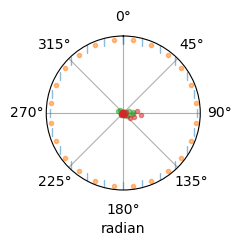

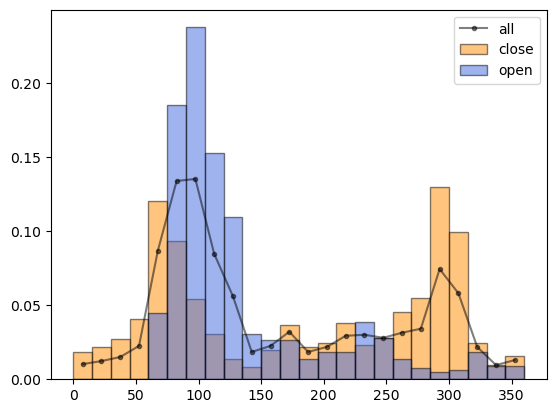

frequency of wind direction during open events relative to close times
direction range: 90.0 - 150.0
 - 7.5 degree  :  0.00  (open freq: 0%)
 - 22.5 degree  :  0.00  (open freq: 0%)
 - 37.5 degree  :  0.00  (open freq: 0%)
 - 52.5 degree  :  0.00  (open freq: 0%)
 - 67.5 degree  :  0.37  (open freq: 4%)
 - 82.5 degree  :  1.99  (open freq: 19%)
 - 97.5 degree  :  4.41 * (open freq: 24%)
 - 112.5 degree  :  4.99 * (open freq: 15%)
 - 127.5 degree  :  8.13 * (open freq: 11%)
 - 142.5 degree  :  3.60  (open freq: 3%)
 - 157.5 degree  :  1.34  (open freq: 3%)
 - 172.5 degree  :  0.71  (open freq: 3%)
 - 187.5 degree  :  0.63  (open freq: 1%)
 - 202.5 degree  :  0.76  (open freq: 2%)
 - 217.5 degree  :  0.49  (open freq: 2%)
 - 232.5 degree  :  1.66  (open freq: 4%)
 - 247.5 degree  :  0.99  (open freq: 3%)
 - 262.5 degree  :  0.31  (open freq: 1%)
 - 277.5 degree  :  0.14  (open freq: 1%)
 - 292.5 degree  :  0.04  (open freq: 0%)
 - 307.5 degree  :  0.06  (open freq: 1%)
 - 322.5 degree  :

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_70582/1846841319.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  if (close_freqs[cc]/open_freqs[cc] > thresh) & (close_freqs[cc]*100 > 5):
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_70582/1846841319.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  print(f' - {center}  :  {close_freqs[cc]/open_freqs[cc]:.2f} {symbol} (close freq: {close_freqs[cc]*100:.1f}%)')


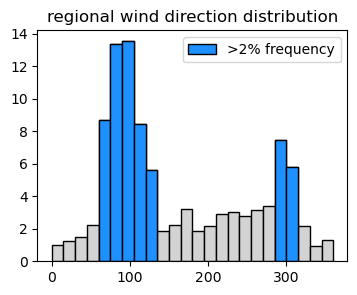

In [142]:

    
fig, ax = plt.subplots(figsize=(6,2), subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rticks([])
ax.plot(bin_edges.to('radian'), np.ones(len(bin_edges)), marker='|', alpha=0.5, lw=0)
ax.plot(bin_centers.to('radian'), np.ones(len(bin_centers)), marker='.', alpha=0.5, lw=0)
    


sums = np.array([])
open_sums = np.array([])
close_sums = np.array([])


for ee, edge0 in enumerate(bin_edges[:-1]):
    
    edge1 = bin_edges[ee+1]
    
#     if ee != 0:
    print(f'{bin_centers[ee]}: {edge0.magnitude} --- {edge1.magnitude}')
    sums = np.append(sums, np.sum((region_wd*units('degree')>=edge0) & (region_wd*units('degree')<edge1)))
    open_sums = np.append(open_sums, np.sum((open_wd*units('degree')>=edge0) & (open_wd*units('degree')<edge1)))
    close_sums = np.append(close_sums, np.sum((close_wd*units('degree')>=edge0) & (close_wd*units('degree')<edge1)))
#     else:
#         print(f'{edge0.magnitude} -- {bin_centers[ee]} -- {edge1.magnitude}')
#         sums = np.append(sums, np.sum((region_wd*units('degree')>=edge0) + (region_wd*units('degree')<edge1)))
#         open_sums = np.append(open_sums, np.sum((open_wd*units('degree')>=edge0) + (open_wd*units('degree')<edge1)))
#         close_sums = np.append(close_sums, np.sum((close_wd*units('degree')>=edge0) + (close_wd*units('degree')<edge1)))
    
freqs = sums/np.sum(sums)
open_freqs = open_sums/np.sum(open_sums)
close_freqs = close_sums/np.sum(close_sums)

ax.plot(bin_centers.to('radian'), freqs, marker='.', alpha=0.5, lw=0)
ax.plot(bin_centers.to('radian'), open_freqs, marker='.', alpha=0.5, lw=0)
plt.show()


plt.bar(bin_centers.magnitude, close_freqs,  facecolor='darkorange', edgecolor='k', alpha=0.5, label='close', width=STEP)
plt.bar(bin_centers.magnitude, open_freqs,  facecolor='royalblue', edgecolor='k', alpha=0.5, label='open', width=STEP)
plt.plot(bin_centers.magnitude, freqs, c='k', marker='.', alpha=0.5, label='all')
plt.legend()
plt.show()


thresh = 2

favorable_bins = bin_centers[open_freqs > thresh*close_freqs]
bound1 = favorable_bins[0].magnitude - STEP/2
bound2 = favorable_bins[-1].magnitude + STEP/2
print('frequency of wind direction during open events relative to close times')
print(f'direction range: {bound1} - {bound2}')
for cc, center in enumerate(bin_centers):
    if (open_freqs[cc]/close_freqs[cc] > thresh) & (open_freqs[cc]*100 > 5):
        symbol='*'
    else: 
        symbol=''
    print(f' - {center}  :  {open_freqs[cc]/close_freqs[cc]:.2f} {symbol} (open freq: {open_freqs[cc]*100:.0f}%)')


favorable_bins = bin_centers[close_freqs > thresh*open_freqs]
bound1 = favorable_bins[0].magnitude - STEP/2
bound2 = favorable_bins[-1].magnitude + STEP/2
print('frequency of wind direction during close times relative to open events')
print(f'direction range: {bound1} - {bound2}')
for cc, center in enumerate(bin_centers):
    if (close_freqs[cc]/open_freqs[cc] > thresh) & (close_freqs[cc]*100 > 5):
        symbol='*'
    else: 
        symbol=''
    print(f' - {center}  :  {close_freqs[cc]/open_freqs[cc]:.2f} {symbol} (close freq: {close_freqs[cc]*100:.1f}%)')

    
    
print(f'2.5% threshold is equivalent to occuring for at least {0.025*len(region_wd)} hours from Mar 1 - Apr 30')

fig, ax = plt.subplots(figsize=(4,3))
ax.set_title('regional wind direction distribution')
ax.bar(bin_centers.magnitude, freqs*100, width = STEP, facecolor='lightgray', edgecolor='k');
ax.bar(bin_centers.magnitude[freqs*100>5], freqs[freqs*100>5]*100, width = STEP, 
       facecolor='dodgerblue', edgecolor='k', label='>2% frequency');
ax.legend();

In [143]:
def create_2d_histogram(x_vals, y_vals, x_edges, y_edges):

    
    # V1: Find 2D distribution of r and theta
    #---------------------------------------
    values = np.vstack([x_vals, y_vals])
    bins = (x_edges, y_edges)
    out = np.histogram2d(values[0,:], values[1,:], bins=bins);
    
    Z = np.transpose(out[0])/len(x_vals)
    X = np.transpose(out[1])
    Y = np.transpose(out[2])
    
    
    
    
    # V2: Find 1D r distribution for each theta
    #------------------------------------------
#     X = x_edges
#     Y = y_edges
    
#     all_freq = np.array([])

#     # run through all x boxes
#     for ee in range(len(x_edges)-1):

#         # define bounds of current box:
#         x_b1 = x_edges[ee]
#         x_b2 = x_edges[ee+1]

#         x_inxbox = np.array([])
#         y_inxbox = np.array([])

#         for xx, xval in enumerate(x_vals):

#             if (xval >= x_b1) and (xval < x_b2):
#                 x_inxbox = np.append(x_inxbox, xval)
#                 y_inxbox = np.append(y_inxbox, y_vals[xx])


#         y_inybox = np.zeros(len(y_edges)-1)
            
#         if len(y_inxbox)/len(y_vals) > 0:# 0.025:
            
#             # run through all y boxes for those in current x boxes
#             for ee in range(len(y_edges)-1):

#                 # define bounds of current box:
#                 y_b1 = y_edges[ee]
#                 y_b2 = y_edges[ee+1]

#                 for yy, yval in enumerate(y_inxbox):

#                     if (yval >= y_b1) and (yval < y_b2):
#                         y_inybox[ee] += 1

#             y_freq_inx = y_inybox/len(y_inxbox)
        
#         else:
#             y_freq_inx = np.full(len(y_inybox), np.nan)
            
#         all_freq = np.append(all_freq, y_freq_inx)
            
#     Z = np.transpose(np.reshape(all_freq, (len(x_edges)-1, len(y_edges)-1)))
    #---------------------------------------
    
    return X, Y, Z    

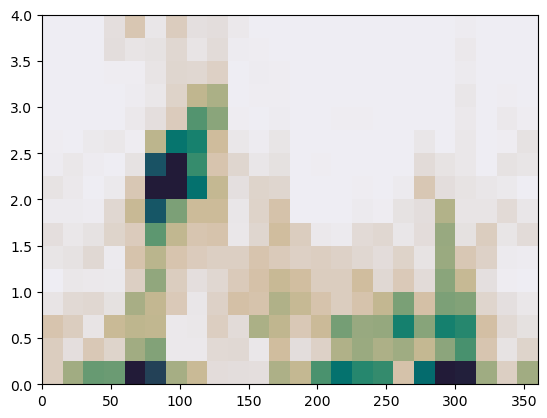

In [144]:

STEP = 15#22.5
azimuths = np.radians(np.arange(0, 360+STEP/2, STEP))
zeniths = np.arange(0,4.25,0.25)
# zeniths = np.arange(0,42.5,2.5)

#-- Generate Data -----------------------------------------

# X, Y, Z = create_2d_histogram(np.radians(region_wd), 
#                               np.sqrt(u**2+v**2).magnitude/wind_speed,
#                               azimuths, zeniths);

X, Y, Z = create_2d_histogram(np.radians(all_region_wd), 
#                               all_buoy_sp.to('km/day').magnitude,#/all_local_ws,
                              all_buoy_sp.magnitude/all_local_ws,
                              azimuths, zeniths);




# X, Y, Z = create_2d_histogram(np.radians(open_close['wind_dir']['close']['data']), 
#                               open_close['buoy_speed']['close']['data'], 
#                               azimuths, zeniths);


# buoy 23 only, turns out pretty much same
# X, Y, Z = create_2d_histogram(np.radians(region_wd), 
#                               buoy_speed,
#                               azimuths, zeniths);

plt.pcolormesh(X*180/np.pi, Y, Z, cmap=cmocean.cm.rain, vmin=0, vmax=0.02, zorder=-10)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_70582/2396621010.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  out = ax.pcolormesh(theta, r, values, cmap=cmocean.cm.rain, vmin=0, vmax=0.02, zorder=-10)


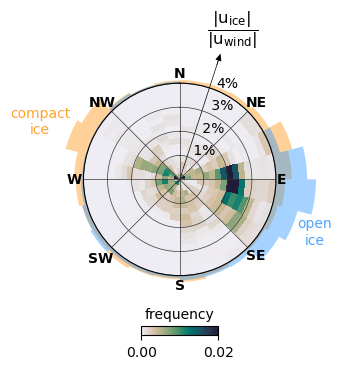

In [145]:
import numpy as np
import matplotlib.pyplot as plt

r, theta = np.meshgrid(zeniths, azimuths)
values = np.transpose(Z)#np.random.random((azimuths.size, zeniths.size))

#-- Plot... ------------------------------------------------
fig, ax = plt.subplots(figsize=(2.5,2.5),subplot_kw=dict(projection='polar'), facecolor='white')

out = ax.pcolormesh(theta, r, values, cmap=cmocean.cm.rain, vmin=0, vmax=0.02, zorder=-10)
# out = ax.contourf((theta+ (STEP/2)*(np.pi/180))[:-1,:-1], 
#                   (r+ 1.25)[:-1,:-1], 
#                   values, cmap=cmocean.cm.tempo, vmin=0, vmax=0.5, zorder=-10)


# LABEL = 'frequency $\mathrm{|u_{ice}|{|u_{wind}|}^{-1}}$\nby SBS wind direction'
# LABEL = 'ice speed ($\mathrm{cm\;{s}^{-1}}$)\nfrequency'
LABEL = 'frequency'
add_colorbar(fig, ax, [out], cb_placement='bottom', cb_orientation='auto', cb_width='auto', 
             cb_length_fraction=[0.3, 0.7], cb_pad=0.2, cb_ticks='auto', cb_ticklabels='auto', 
             cb_extend='neither', cb_label=LABEL, labelpad=5, cb_label_placement='top', 
             cb_tick_placement='auto', cb_labelsize=FS, )

ax.arrow(1*np.pi/10, 5.0, 0, 0.2, alpha = 1, width = 0.005, clip_on=False,
         head_width=0.05, head_length=0.3,  edgecolor = 'None', facecolor = 'k', lw = 0, zorder = 5)
ax.plot([1*np.pi/10, 1*np.pi/10],[0, 5.3], clip_on=False, c='k', lw=0.5, linestyle='solid', zorder=-1)


# LABEL = '$\mathrm{|u_{ice}|{|u_{wind}|}^{-1}}$'
LABEL = '$\mathrm{\dfrac{|u_{ice}|}{|u_{wind}|}}$'
# LABEL = 'sea ice\ndrift rate\n($\mathrm{km\;{d}^{-1}}$)'
ax.text(1.25*np.pi/10, 5.8, LABEL, rotation=0,
              verticalalignment='bottom', horizontalalignment='center', fontsize = FS+2)


# ax.plot(np.linspace(-0.75*np.pi/5, -0.1*np.pi/5, 50), np.full(50,55), clip_on=False, c='k', lw=0.5, linestyle='solid', zorder=-1)
# ax.text(-0.6*np.pi/5, 60, 'SBS wind\ndirection', rotation=0,
#               verticalalignment='bottom', horizontalalignment='center', fontsize = FS)

ax.set_rticks(np.arange(1.0,4.5,1))
ax.set_yticklabels([' 1%',' 2%',' 3%','4%',])
ax.set_rlim(0,4.0)
ax.grid(linewidth=0.5, zorder=1, c=[0.2,0.2,0.2])

xticks = np.arange(0,2*np.pi,np.pi/4)
xticklabels = ['N', 'NE',  'E',  'SE', 'S',  'SW',  'W',  'NW', ]
xticklabels = ['N', 'NE',  'E',  'SE', 'S',  'SW',  'W',  'NW', ]


# label direction frequency
#----------------------------------------------
# axin1 = ax.inset_axes([-0.4, 0.85, 0.33, 0.1])
# axin1.patch.set_facecolor('darkorange')
# for spine in ['top', 'right', 'bottom', 'left']:
#     axin1.spines[spine].set_visible(False)
# axin1.patch.set_alpha(0.4)
# axin1.set_xticks([])
# axin1.set_yticks([])
# ax.text(-0.395, 0.865, 'compact', transform=ax.transAxes, rotation=0,
#               verticalalignment='bottom', horizontalalignment='left', fontsize = FS, zorder=100)

ax.text(-0.225, 0.725, 'compact\nice', c='darkorange', alpha=0.8, weight='normal',
        transform=ax.transAxes, rotation=0,
        verticalalignment='bottom', horizontalalignment='center', fontsize = FS, zorder=100)

# axin1 = ax.inset_axes([1.125, 0.175, 0.2, 0.1])
# axin1.patch.set_facecolor('dodgerblue')
# for spine in ['top', 'right', 'bottom', 'left']:
#     axin1.spines[spine].set_visible(False)
# axin1.patch.set_alpha(0.4)
# axin1.set_xticks([])
# axin1.set_yticks([])
# ax.text(1.15, 0.25, 'open', transform=ax.transAxes, rotation=0,
#               verticalalignment='bottom', horizontalalignment='left', fontsize = FS, zorder=100)

ax.text(1.2, 0.15, 'open\nice', c='dodgerblue', alpha=0.8, weight='normal',
        transform=ax.transAxes, rotation=0,
        verticalalignment='bottom', horizontalalignment='center', fontsize = FS, zorder=100)


#----------------------------------------------


yy = ax.get_ylim()[-1]+0.125*np.array([4.,5,2.8,4.5,4,6,4,5])
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(xticks)
ax.set_xticklabels([])
for tt in range(len(xticks)):
    ax.text(xticks[tt], yy[tt]-0.1, xticklabels[tt], ha='center', va='center', weight='bold',
            transform=ax.transData, rotation=0)

y = 1.0
y_bottom = ax.get_ylim()[-1]


# bin_width = (315-270)
# bin_center = 270 + 0.5*bin_width
# ax.bar((bin_center*np.pi/180), y, width=(bin_width*np.pi/180), bottom=y_bottom, 
#        edgecolor='none', facecolor='darkorange', alpha=0.4, clip_on=False, zorder=-100)


# bin_width = (75-60)
# bin_center = 60 + 0.5*bin_width
# ax.bar((bin_center*np.pi/180), y, width=(bin_width*np.pi/180), bottom=y_bottom, 
#        edgecolor='none', facecolor='darkorange', alpha=0.4, clip_on=False, zorder=-100)


ax.bar(bin_centers.to('radians').magnitude, 7*close_freqs, width=(15*np.pi/180), bottom=y_bottom, 
       edgecolor='none', facecolor='darkorange', alpha=0.4, clip_on=False, zorder=-100)



ax.bar(bin_centers.to('radians').magnitude, 7*open_freqs, width=(15*np.pi/180), bottom=y_bottom, 
       edgecolor='none', facecolor='dodgerblue', alpha=0.4, clip_on=False, zorder=-100)


# bin_width = (150.0-75.0)
# bin_center = 75.0 + 0.5*bin_width
# ax.bar((bin_center*np.pi/180), y, width=(bin_width*np.pi/180), bottom=y_bottom, 
#        edgecolor='none', facecolor='dodgerblue', alpha=0.4, clip_on=False, zorder=-100)


# bin_width = (135.0-75.0)
# bin_center = 75.0 + 0.5*bin_width
# ax.bar((bin_center*np.pi/180), y, width=(bin_width*np.pi/180), bottom=y_bottom, 
#        edgecolor='none', facecolor='dodgerblue', alpha=0.4, clip_on=False, zorder=-100)

ax.set_facecolor('lightgray')


plt.show()

# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigJ/FigJ_v4.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)


In [100]:
bin_centers

Magnitude,[7.5 22.5 37.5 52.5 67.5 82.5 97.5 112.5 127.5 142.5 157.5 172.5 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5]
Units,degree


In [101]:
close_freqs

array([0.01736111, 0.02083333, 0.02546296, 0.03819444, 0.11342593,
       0.08796296, 0.05092593, 0.02893519, 0.01273148, 0.00810185,
       0.01967593, 0.04166667, 0.02314815, 0.02430556, 0.03587963,
       0.03009259, 0.04282407, 0.0474537 , 0.05671296, 0.12615741,
       0.09490741, 0.02430556, 0.01157407, 0.01736111])

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_30951/3805886437.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  out = ax.pcolormesh(theta, r, values, cmap=cmocean.cm.rain, vmin=0, vmax=0.02, zorder=-10)


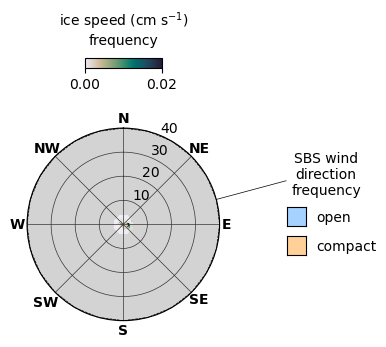

In [33]:
import numpy as np
import matplotlib.pyplot as plt

r, theta = np.meshgrid(zeniths, azimuths)
values = np.transpose(Z)#np.random.random((azimuths.size, zeniths.size))

#-- Plot... ------------------------------------------------
fig, ax = plt.subplots(figsize=(2.5,2.5),subplot_kw=dict(projection='polar'), facecolor='white')

out = ax.pcolormesh(theta, r, values, cmap=cmocean.cm.rain, vmin=0, vmax=0.02, zorder=-10)
# out = ax.contourf((theta+ (STEP/2)*(np.pi/180))[:-1,:-1], 
#                   (r+ 1.25)[:-1,:-1], 
#                   values, cmap=cmocean.cm.tempo, vmin=0, vmax=0.5, zorder=-10)


# LABEL = 'frequency $\mathrm{|u_{ice}|{|u_{wind}|}^{-1}}$\nby SBS wind direction'
LABEL = 'ice speed ($\mathrm{cm\;{s}^{-1}}$)\nfrequency'
add_colorbar(fig, ax, [out], cb_placement='bottom', cb_orientation='auto', cb_width='auto', 
             cb_length_fraction=[0.3, 0.7], cb_pad=-1.05, cb_ticks='auto', cb_ticklabels='auto', 
             cb_extend='neither', cb_label=LABEL, labelpad=10, cb_label_placement='top', 
             cb_tick_placement='auto', cb_labelsize=FS, )

# ax.scatter(np.radians(all_region_wd)[::12], all_buoy_sp.magnitude[::12], c='k', s=1)


ax.set_rticks(np.arange(10,45,10))
ax.set_rlim(0,40)
# ax.set_yticklabels(['',10,'',20,'',30,'',40])
ax.grid(linewidth=0.5, zorder=1, c=[0.2,0.2,0.2])


xticks = np.arange(0,2*np.pi,np.pi/4)
xticklabels = ['N', 'NE',  'E',  'SE', 'S',  'SW',  'W',  'NW', ]
xticklabels = ['N', 'NE',  'E',  'SE', 'S',  'SW',  'W',  'NW', ]


# ax.text(-1*np.pi/16, 9.5, 'frequency', rotation=0,
#               verticalalignment='center', horizontalalignment='center', fontsize = FS)
# # ax.text(1*np.pi/16, 8.75, r'$\mathrm{\dfrac{|u_{ice}|}{|u_{wind}|}}$', rotation=0,
# #               verticalalignment='center', horizontalalignment='center', fontsize = FS+2)
# ax.text(1*np.pi/16, 8.75, r'$\mathrm{|u_{ice}|{|u_{wind}|}^{-1}}$', rotation=0,
#               verticalalignment='center', horizontalalignment='center', fontsize = FS+2)
# # ax.text(1.75*np.pi/16, 9.25, 'by SBS wind direction', rotation=0,
# #               verticalalignment='center', horizontalalignment='center', fontsize = FS)


# rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
# ax.add_patch(rect, transform=ax.TransAxes)


# label direction frequency
#----------------------------------------------
# ax.arrow(5*np.pi/12, 66, 0, 2, alpha = 1, width = 0.005, clip_on=False,
#          head_width=0.05, head_length=3,  edgecolor = 'None', facecolor = 'k', lw = 0, zorder = 5)
ax.plot([5*np.pi/12, 5*np.pi/12],[40, 70], clip_on=False, c='k', lw=0.5, linestyle='solid', zorder=-1)
ax.text(5.5*np.pi/12, 85, 'SBS wind\ndirection\nfrequency', rotation=0,
              verticalalignment='bottom', horizontalalignment='center', fontsize = FS)

# ax.plot([7*np.pi/12, 6.77*np.pi/12],[70,78.65], clip_on=False, c='gray', lw=1, linestyle='dashed', zorder=-1)
# ax.text(1.5, 0.2, 'all', transform=ax.transAxes, rotation=0,
#               verticalalignment='bottom', horizontalalignment='left', fontsize = FS)

axin1 = ax.inset_axes([1.35, 0.34, 0.1, 0.1])
axin1.patch.set_facecolor('darkorange')
axin1.patch.set_alpha(0.4)
axin1.set_xticks([])
axin1.set_yticks([])
ax.text(1.5, 0.35, 'compact', transform=ax.transAxes, rotation=0,
              verticalalignment='bottom', horizontalalignment='left', fontsize = FS)

axin1 = ax.inset_axes([1.35, 0.49, 0.1, 0.1])
axin1.patch.set_facecolor('dodgerblue')
axin1.patch.set_alpha(0.4)
axin1.set_xticks([])
axin1.set_yticks([])
ax.text(1.5, 0.5, 'open', transform=ax.transAxes, rotation=0,
              verticalalignment='bottom', horizontalalignment='left', fontsize = FS)
#----------------------------------------------


# ax.plot([-np.pi/8, -np.pi/8],[0,6], clip_on=False, c='k', lw=0.5, linestyle='solid')
# ax.arrow(-np.pi/8, 5, 0, 0.75, alpha = 1, width = 0.005, clip_on=False,
#          head_width=0.05, head_length=0.3,  edgecolor = 'None', facecolor = 'k', lw = 0, zorder = 5)

# ax.text(0, 6.5, 'by', rotation=0,
#               verticalalignment='center', horizontalalignment='center', fontsize = FS)
# ax.text(1.5*np.pi/16, 7, 'SBS wind\ndirection', rotation=0,
#               verticalalignment='center', horizontalalignment='center', fontsize = FS)
# ax.plot(np.linspace(-np.pi/8,0,20),np.full(20, 5.5), clip_on=False, c='k', lw=0.5, linestyle='solid')



yy = ax.get_ylim()[-1]+1*np.array([4.,5,2.8,4.5,4,6,4,5])
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(xticks)
ax.set_xticklabels([])
for tt in range(len(xticks)):
    ax.text(xticks[tt], yy[tt]-0.1, xticklabels[tt], ha='center', va='center', weight='bold',
            transform=ax.transData, rotation=0)
    
    
# ax.text(1*np.pi/8, 1.2, '1%', horizontalalignment='center')
# ax.text(1*np.pi/8, 2.2, '2%', horizontalalignment='center')
# ax.text(1*np.pi/8, 3.2, '3%', horizontalalignment='center')
# ax.text(1*np.pi/8, 4.2, '4%', horizontalalignment='center')

# ax.set_rticks([20,40])
# ax.set_rlim(0,50)
# # ax.set_yticklabels(['2%','4%', '6%'])
# ax.grid(linewidth=0.5, zorder=1, c='gray')


# ax.set_theta_zero_location("N")
# ax.set_theta_direction(-1)
# ax.set_xticks(np.arange(0,2*np.pi,np.pi/8))
# ax.set_xticklabels(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'])
# for tick, size in zip(plt.xticks()[-1], [FS1,FS2,FS1,FS2,FS1,FS2,FS1,FS2,FS1,FS2,FS1,FS2,FS1,FS2,FS1,FS2]):
#     tick.set_fontsize(size)
#     tick.set_zorder(size)
# ax.set_rticks([1,2,3,4])
# ax.set_rlim(0,6)
# ax.set_yticklabels(['0.1','0.2'])
# ax.grid(linewidth=1, c='k', zorder=100)


y = 0.25
y_bottom = ax.get_ylim()[-1]

# bin_width = (56.25+11.25)
# bin_center = -11.25 + 0.5*bin_width
# ax.bar((bin_center*np.pi/180), y, width=(bin_width*np.pi/180), bottom=y_bottom, 
#        edgecolor='none', facecolor='r', alpha=0.2, clip_on=False, zorder=-100)

# bin_width = (326.25-258.75)
# bin_center = 258.75 + 0.5*bin_width
# ax.bar((bin_center*np.pi/180), y, width=(bin_width*np.pi/180), bottom=y_bottom, 
#        edgecolor='none', facecolor='r', alpha=0.2, clip_on=False, zorder=-100)


# bin_width = (146.25-78.75)
# bin_center = 78.75 + 0.5*bin_width
# ax.bar((bin_center*np.pi/180), y, width=(bin_width*np.pi/180), bottom=y_bottom, 
#        edgecolor='none', facecolor='cornflowerblue', alpha=0.4, clip_on=False, zorder=-100)


scale = 0.11


ax.step(bin_edges.to('radian').magnitude, y_bottom + scale*np.append(freqs,freqs[0]), where = 'post', 
       c='k', linestyle='dashed', lw=0.5, alpha=1, clip_on=False, zorder=-99)
# ax.step(bin_edges.to('radian').magnitude, y_bottom + scale*np.append(open_freqs,open_freqs[0]), where = 'post', 
#        c='cornflowerblue', linestyle='solid', lw=2, alpha=0.5, clip_on=False, zorder=-99)
# ax.step(bin_edges.to('radian').magnitude, y_bottom + scale*np.append(close_freqs,close_freqs[0]), where = 'post', 
#        c='red', linestyle='solid', lw=2, alpha=0.2, clip_on=False, zorder=-99)

ax.bar(bin_centers.to('radian').magnitude, scale*close_freqs, width=(STEP*np.pi/180), bottom=y_bottom, 
       edgecolor='none', facecolor='darkorange', alpha=0.3, clip_on=False, zorder=-100)
ax.bar(bin_centers.to('radian').magnitude, scale*open_freqs, width=(STEP*np.pi/180), bottom=y_bottom+scale*close_freqs, 
       edgecolor='none', facecolor='dodgerblue', alpha=0.3, clip_on=False, zorder=-100)


ax.set_facecolor('lightgray')



plt.show()


# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigJ/FigJ_v2.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)


In [32]:
# ax.arrow(5*np.pi/12, 6, 0, 0.75, alpha = 1, width = 0.005, clip_on=False,
#          head_width=0.05, head_length=0.3,  edgecolor = 'None', facecolor = 'k', lw = 0, zorder = 5)
# ax.plot([5*np.pi/12, 5*np.pi/12],[4,7], clip_on=False, c='k', lw=0.5, linestyle='solid', zorder=-1)
# ax.text(5.25*np.pi/12, 8.75, 'direction\nfrequency', rotation=0,
#               verticalalignment='bottom', horizontalalignment='center', fontsize = FS)

# ax.plot([6.85*np.pi/12, 6.77*np.pi/12],[7.75,8.65], clip_on=False, c='gray', lw=1, linestyle='dashed', zorder=-1)
# ax.text(1.6, 0.25, 'all', transform=ax.transAxes, rotation=0,
#               verticalalignment='bottom', horizontalalignment='left', fontsize = FS)

# axin1 = ax.inset_axes([1.45, 0.39, 0.1, 0.1])
# axin1.patch.set_facecolor('darkorange')
# axin1.patch.set_alpha(0.4)
# axin1.set_xticks([])
# axin1.set_yticks([])

# ax.text(1.6, 0.4, 'compact', transform=ax.transAxes, rotation=0,
#               verticalalignment='bottom', horizontalalignment='left', fontsize = FS)
# axin1 = ax.inset_axes([1.45, 0.54, 0.1, 0.1])
# axin1.patch.set_facecolor('dodgerblue')
# axin1.patch.set_alpha(0.4)
# axin1.set_xticks([])
# axin1.set_yticks([])

# ax.text(1.6, 0.55, 'open', transform=ax.transAxes, rotation=0,
#               verticalalignment='bottom', horizontalalignment='left', fontsize = FS)

-66.14410480122346 99.68457983180156 575239.0784111018
-111.12756093670978 61.33532265180952 330498.39023469994


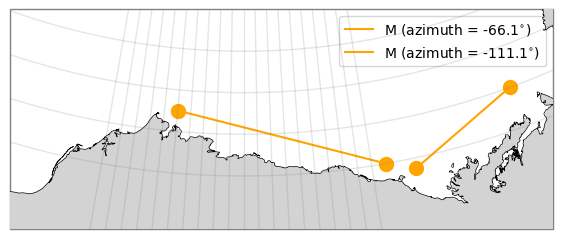

In [146]:
# create figure in NorthPolarStereo projection
#---------------------------------------------
map_projection = ccrs.NorthPolarStereo(central_longitude=210)

lat_range = [68, 73]
lon_range = [195, 230]
fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection),figsize=(7,5), facecolor='white')
plt.subplots_adjust(wspace=0.05, hspace=0)

# set map extent, add grid and geo features
#------------------------------------------
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
ax.set_aspect('equal')
ax.spines['geo'].set_edgecolor('gray')
ax.spines['geo'].set_linewidth(1)
add_coast(ax, scale='10m', color='k', linewidth=0.5, alpha=1, zorder=10)
add_land(ax,  scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=9)
add_grid(ax, lats=np.arange(70,74,1), lons=np.arange(200,220,1), linewidth=1, color='gray', alpha=0.2, zorder=10)

    
    
left_bound = (-155, 71.5)
right_bound = (-140, 70)

# compute forward and back azimuths, plus distance
az12,az21,distance = geod.inv(right_bound[0],right_bound[-1],left_bound[0],left_bound[-1],)
print(az12,az21,distance)


ax.scatter([left_bound[0], right_bound[0]], [left_bound[-1], right_bound[-1]], transform=ccrs.PlateCarree(), s=100, zorder=-1, c='orange')
ax.plot([left_bound[0], right_bound[0]], [left_bound[-1], right_bound[-1]], transform=ccrs.PlateCarree(), zorder=-1, c='orange', label=f'M (azimuth = {az12:.1f}'+'$^{\circ}$)')


left_bound = (-138, 69.75)
right_bound = (-130, 71)

# compute forward and back azimuths, plus distance
az12,az21,distance = geod.inv(right_bound[0],right_bound[-1],left_bound[0],left_bound[-1],)
print(az12,az21,distance)

ax.scatter([left_bound[0], right_bound[0]], [left_bound[-1], right_bound[-1]], transform=ccrs.PlateCarree(), s=100, zorder=-1, c='orange')
ax.plot([left_bound[0], right_bound[0]], [left_bound[-1], right_bound[-1]], transform=ccrs.PlateCarree(), zorder=-1, c='orange', label=f'M (azimuth = {az12:.1f}'+'$^{\circ}$)')



plt.legend()

### Find dates with S-E winds and define forcing sequences

In [147]:
#168.75
# 56.25 - 168.75
# 78.85 - 191.25

#     if (region_wd[tt] >= 56.25) & (region_wd[tt] <= 168.75):

# find all times with favorable forcing 
#--------------------------------------
forcing_dates_withhours = np.array([])
for tt in range(len(time)):
    if (region_wd[tt] >= 56.25) & (region_wd[tt] <= 168.75):
        forcing_dates_withhours = np.append(forcing_dates_withhours, time[tt])
        
# partition into forcing sequences  
#---------------------------------
force_sequences={}

# fill in first value of list
ss = 0
force_sequences[ss] = [forcing_dates_withhours[0]]
for ii in range(1,len(forcing_dates_withhours)):
    # number hours difference between last time in current sequence and current time
    dh = pd.Timedelta(forcing_dates_withhours[ii]-force_sequences[ss][-1]).total_seconds()/3600
    # if within one hour of last timein sequence, add to current sequence
    if dh <= 1:
        force_sequences[ss].append(forcing_dates_withhours[ii])
    # else start new sequence
    else:
        ss+=1
        force_sequences[ss] = [forcing_dates_withhours[ii]]
        
        
print(f'{len(force_sequences)} forcing sequences\n--------------------')
for seq in force_sequences:
    print(f'{force_sequences[seq][0]} -- {force_sequences[seq][-1]}  ({len(force_sequences[seq])} hours)')
    

14 forcing sequences
--------------------
2021-03-01 09:00:00 -- 2021-03-09 21:00:00  (205 hours)
2021-03-10 16:00:00 -- 2021-03-11 01:00:00  (10 hours)
2021-03-13 03:00:00 -- 2021-03-18 06:00:00  (124 hours)
2021-03-20 23:00:00 -- 2021-03-23 12:00:00  (62 hours)
2021-03-24 11:00:00 -- 2021-03-25 13:00:00  (27 hours)
2021-03-28 23:00:00 -- 2021-04-02 09:00:00  (107 hours)
2021-04-02 21:00:00 -- 2021-04-02 21:00:00  (1 hours)
2021-04-03 03:00:00 -- 2021-04-03 10:00:00  (8 hours)
2021-04-04 02:00:00 -- 2021-04-05 00:00:00  (23 hours)
2021-04-12 03:00:00 -- 2021-04-15 10:00:00  (80 hours)
2021-04-16 05:00:00 -- 2021-04-16 16:00:00  (12 hours)
2021-04-18 14:00:00 -- 2021-04-18 14:00:00  (1 hours)
2021-04-23 04:00:00 -- 2021-04-24 02:00:00  (23 hours)
2021-04-25 09:00:00 -- 2021-04-30 23:00:00  (135 hours)


### Create dictionary for marker symbols

In [35]:
# marker_dict = {}

# for buoy in ['24', '45', '53']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'NW'
#     marker_dict[buoy]['shape'] = 's'
#     marker_dict[buoy]['size'] = 20
    
# for buoy in ['23', '25', '26', '29', '30', '35', '38', '40', '41', '43', '49']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'W'
#     marker_dict[buoy]['shape'] = 'v'
#     marker_dict[buoy]['size'] = 30    
    
# for buoy in ['28', '32', '33', '36', '46', '48', '50', '51']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'E'
#     marker_dict[buoy]['shape'] = 'o'
#     marker_dict[buoy]['size'] = 25 

# for buoy in ['27', '31']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'SE'
#     marker_dict[buoy]['shape'] = 'd'
#     marker_dict[buoy]['size'] = 40 

# for buoy in ['52']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'LF'
#     marker_dict[buoy]['shape'] = 'X'
#     marker_dict[buoy]['size'] = 40 

# plot buoy speeds over long sequence relative to ice conditions

### Set x-label formatting

In [148]:
XMIN = time[0]
XMAX = time[-1]
print(f'xmin: {XMIN}  xmax: {XMAX}')
dates_to_label = time[0::24*5]
MOD = 1
# date_labels = [pd.to_datetime(date).strftime('%m/%d') for dd, date in enumerate(dates_to_label)]
date_labels = [f"{pd.to_datetime(date).strftime('%d')}\n{pd.to_datetime(date).strftime('%b')}" for dd, date in enumerate(dates_to_label)]
for dd, date in enumerate(date_labels):
    if dd%2 == MOD:
        date_labels[dd] = ''
for dd, date in enumerate(dates_to_label):
    print(f'{date} --> {date_labels[dd]}')

xmin: 2021-03-01 00:00:00  xmax: 2021-04-30 23:00:00
2021-03-01 00:00:00 --> 01
Mar
2021-03-06 00:00:00 --> 
2021-03-11 00:00:00 --> 11
Mar
2021-03-16 00:00:00 --> 
2021-03-21 00:00:00 --> 21
Mar
2021-03-26 00:00:00 --> 
2021-03-31 00:00:00 --> 31
Mar
2021-04-05 00:00:00 --> 
2021-04-10 00:00:00 --> 10
Apr
2021-04-15 00:00:00 --> 
2021-04-20 00:00:00 --> 20
Apr
2021-04-25 00:00:00 --> 
2021-04-30 00:00:00 --> 30
Apr


## partitioning cumulative drift into opening events

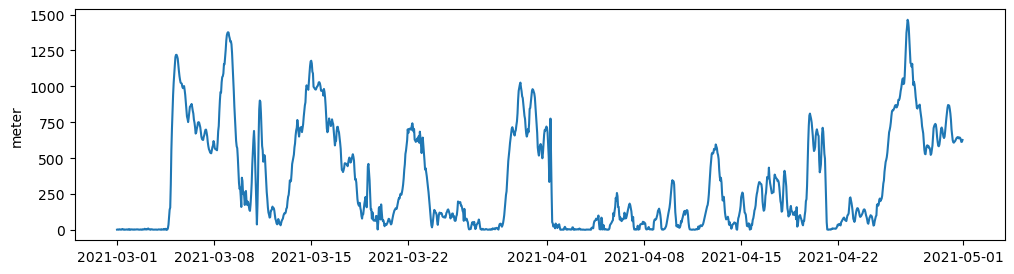

In [149]:
# pick buoy file (0 or 1 for buoys 23 or 24 which were active the whole time)
#========================
buoy = '23'

STEP = 2
#========================

# grab buoy data
#---------------
lon_track = buoy_ds.longitude.sel(time=slice(TI,TF)).sel(buoyID = buoy).values
lat_track = buoy_ds.latitude.sel(time=slice(TI,TF)).sel(buoyID = buoy).values
time_track = pd.to_datetime(buoy_ds.time.sel(time=slice(TI,TF)).values)

# calculate velocity
#-------------------
u, v, time, dx, dy, dist = calc_velocity(lon_track = lon_track, lat_track = lat_track, 
                                             time_track = time_track, step = STEP)

# ice drift direction
ice_dir = metpy.calc.wind_direction(u, v, convention='from')

# flag unphysical velocities
v_flag = np.sqrt(u**2+v**2) > velflag
u[v_flag] = np.nan
v[v_flag] = np.nan
ice_dir[v_flag] = np.nan
    
    
# # calculate hourly velocity
# u, v, time, dx, dy, dist = calc_velocity(lon_track = lon_track, lat_track = lat_track, 
#                                          time_track = time_track, step = 6)
# plot 
fig, ax = plt.subplots(figsize = (12,3))
ax.plot(time, dist.to('m'))

In [201]:
len(np.sqrt(dx**2 + dy**2).to('km'))

1464

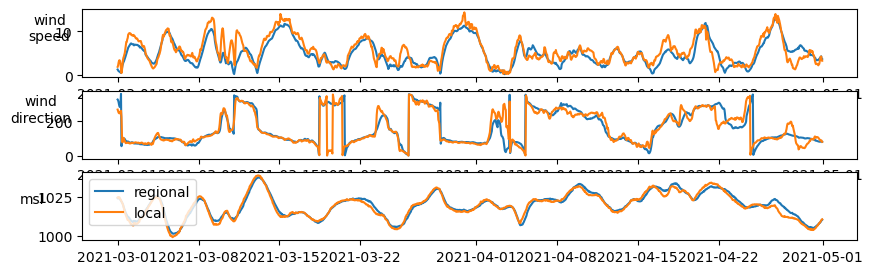

In [150]:


#===========================
buoy = '23'
#===========================

buoy_times = buoy_ds.sel(time=slice(TI, TF)).time.values[1::2]
buoy_lons = buoy_ds.longitude.sel(time=slice(TI, TF)).sel(buoyID = buoy).values[1::2]
buoy_lats = buoy_ds.latitude.sel(time=slice(TI, TF)).sel(buoyID = buoy).values[1::2]


# open ERA5 data
#---------------
# file = '/Users/mackenziejewell/Desktop/ERA5_2021.nc'
file = '/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2021.nc'
ds_era = xr.open_dataset(file)
ds_era.close()
ERA_lons = ds_era.longitude.values
ERA_lats = ds_era.latitude.values
ERA_times = ds_era.time.values
    
    
local_u10 = np.array([])
local_v10 = np.array([])
local_msl = np.array([])

for ii in range(len(buoy_times)):

    lon = buoy_lons[ii]
    lat = buoy_lats[ii]
    tim = buoy_times[ii]

    tt = np.where(ERA_times == tim)[0][0]
    spec_ds = ds_era.sel(time = ds_era.time[tt])


    if spec_ds.u10.dims == ('latitude', 'longitude'):
        all_u10 = np.transpose(spec_ds.u10.values)
        all_v10 = np.transpose(spec_ds.v10.values)
        all_msl = np.transpose(spec_ds.msl.values)
    else:
        all_u10 = spec_ds.u10.values
        all_v10 = spec_ds.v10.values
        all_msl = spec_ds.msl.values

    if ERA_lats[0] > ERA_lats[1]:
        ERA_lats_ = ERA_lats[::-1]
        all_u10_ = all_u10[:,::-1]
        all_v10_ = all_v10[:,::-1]
        all_msl_ = all_msl[:,::-1]
    else:
        ERA_lats_ = ERA_lats
        all_u10_ = all_u10
        all_v10_ = all_v10
        all_msl_ = all_msl
    
    if bb == 0 and ii == 0:
        show_map = True
    else:
        show_map = False

    loc_u10, loc_v10 = interpolate_geo_data(interp_lon = lon, interp_lat = lat, 
                         lons = ERA_lons, lats = ERA_lats_,
                         data1 = all_u10_, data2 = all_v10_, 
                         buffer_lon = 2, buffer_lat = 1, show_map = show_map)
    loc_msl = interpolate_geo_data(interp_lon = lon, interp_lat = lat, 
                         lons = ERA_lons, lats = ERA_lats_,
                         data1 = all_msl_,
                         buffer_lon = 2, buffer_lat = 1, show_map = False)

    local_u10 = np.append(local_u10, loc_u10)
    local_v10 = np.append(local_v10, loc_v10)
    local_msl = np.append(local_msl, loc_msl/100)

    
# local_u10, local_v10, local_msl = find_local_winds(buoy_lons, buoy_lats, buoy_times, refine=False)
    
local_ws = np.sqrt(local_u10**2+local_v10**2)
local_wd = metpy.calc.wind_direction(local_u10*units('m/s'), local_v10*units('m/s'), convention='from').magnitude
wind_speed = local_ws

dot = local_u10*u + local_v10*v      # Dot product between [x1, y1] and [x2, y2]
det = local_u10*v - local_v10*u      # Determinant
angle = -np.arctan2(det, dot)*180/np.pi  # atan2(y, x) or atan2(sin, cos) 

fig, axs = plt.subplots(3,1, figsize=(10,3))

axs[0].plot(time, region_ws, label='region')
axs[0].plot(time, local_ws, label='local')
axs[0].set_ylabel('wind\nspeed', rotation=0)

axs[1].plot(time, region_wd, label='regional')
axs[1].plot(time, local_wd, label='local')
axs[1].set_ylabel('wind\ndirection', rotation=0)

axs[2].plot(time, region_msl, label='regional')
axs[2].plot(time, local_msl, label='local')
axs[2].set_ylabel('msl', rotation=0)

axs[2].legend()

In [151]:
# wind_dir = all_local_wd
# wind_speed = all_local_ws
# msl = all_local_msl
# wind_u = all_local_u10
# wind_v = all_local_v10

# # wind_dir = region_wd
# # wind_speed = region_ws
# # wind_u = region_u10
# # wind_v = region_v10
# #=================================

# #================================================================
# buoy_23_speed = all_buoy_sp.magnitude#speeds_regrid[ordered_IDs.index('23'),:].magnitude
# buoy_23_dir = all_buoy_dir.magnitude#dirs_regrid[ordered_IDs.index('23'),:].magnitude
# buoy_23_u = all_buoy_u #us_regrid[ordered_IDs.index('23'),:].magnitude
# buoy_23_v = all_buoy_v #vs_regrid[ordered_IDs.index('23'),:].magnitude

# dot = wind_u*buoy_23_u + wind_v*buoy_23_v      # Dot product between [x1, y1] and [x2, y2]
# det = wind_u*buoy_23_v - wind_v*buoy_23_u      # Determinant
# angle = -np.arctan2(det, dot)*180/np.pi  # atan2(y, x) or atan2(sin, cos) 

# calculate cumulative distance along northwestward displacement

## (1) First find : CompSs
### component of ice drift at each timestep (direction s) that points toward final destination (direction S)

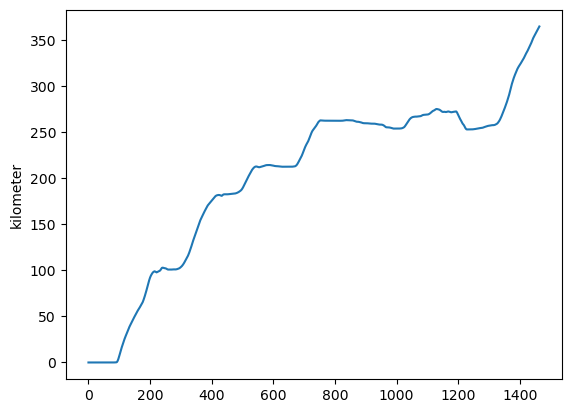

In [196]:
all_lons = lon_track[::2]
all_lats = lat_track[::2]

dX = np.array([])
dY = np.array([])
dI = np.array([])

for ii in range(len(all_lons)-1):

    # current location
    loc1=(all_lats[ii], all_lons[ii])
    # end location
    loc2=(all_lats[-1], all_lons[-1])

    # compute forward and back azimuths, plus distance
    az12,az21,distance = geod.inv(loc1[1],loc1[0],loc2[1],loc2[0])
    dI = np.append(dI, distance*units('meter').to('cm'))

    # angle from east
    beta = 90 * units('degree') - az12 * units('degree')
    if beta <= -180*units('degree'):
        beta += 360*units('degree')

    # calculate zonal, meridional displacements fmor azimuth
    DX = (distance*units('meter') * np.cos(beta.to('radian'))).to('cm')
    DY = (distance*units('meter') * np.sin(beta.to('radian'))).to('cm')

    dX = np.append(dX, DX)
    dY = np.append(dY, DY)
    
# component of little s along S
# S = dX i + dY j
# s = dx i + dY j
# compSs = (s.S)/|S|

compSs = (((dx*dX) + (dy*dY))/(np.sqrt(dX**2+ dY**2))).to('km')

plt.plot(np.cumsum(compSs))


In [195]:
dI.to('km')

Magnitude,[364.515046155706 364.51602211431884 364.51713391844953 ... 1.8502979336803962 1.2391048757524776 0.6258280957079475]
Units,kilometer


In [193]:
compSs


Magnitude,[-0.0009759582263168454 -0.0011117983408396447 0.0012116185520169346 ... 0.6115150521883586 0.6133175841136224 0.6258280957079475]
Units,kilometer


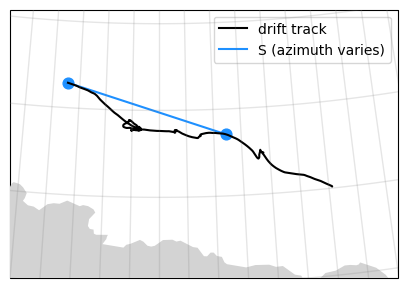

In [153]:
# create figure in NorthPolarStereo projection
#---------------------------------------------
map_projection = ccrs.NorthPolarStereo(central_longitude=210)
lat_range = [70, 73]
lon_range = [205, 218]
fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection),figsize=(5,4), facecolor='white')

# set map extent, add grid and geo features
#------------------------------------------
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
add_land(ax,  scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=9)
add_grid(ax, lats=np.arange(70,74,1), lons=np.arange(200,220,1), linewidth=1, color='gray', alpha=0.2, zorder=10)

ax.plot(all_lons, all_lats, transform=ccrs.PlateCarree(), c='k', label='drift track')
ax.scatter([all_lons[360], all_lons[-1]], [all_lats[360], all_lats[-1]], transform=ccrs.PlateCarree(), s=60, zorder=-1, c='dodgerblue')
ax.plot([all_lons[360], all_lons[-1]], [all_lats[360], all_lats[-1]], transform=ccrs.PlateCarree(), zorder=-1, c='dodgerblue', label='S (azimuth varies)')

plt.legend()

## (2) Next find : CompMs
### component of ice drift at each timestep (direction s) that along seasonal mean direction of travel (direction M)

In [154]:
fix_cartopy_vectors(np.mean(dx).magnitude, np.mean(dy).magnitude, np.mean(all_lats))

(-24695.92842596422, 3267.40131674701)

orientation of average ice drift vector: from 112.825 degree
orientation of average ice drift vector: toward -67.175 degree

fwd azimuth from initial to final points: toward -62.709 degree
bkwd azimuth b/w initial and final points: toward 108.200 degree
avg of fwd/bkwd directions is: toward -67.254 degree


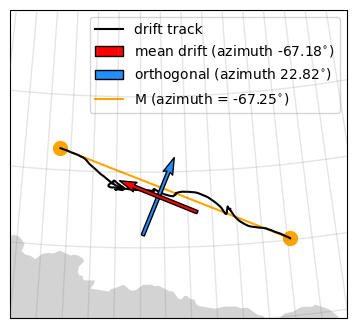

In [155]:
avg_drift_dir = metpy.calc.wind_direction(np.mean(dx)/units('s'), np.mean(dy)/units('s'), convention='from')
print(f"orientation of average ice drift vector: from {avg_drift_dir.magnitude:.3f} degree")
print(f"orientation of average ice drift vector: toward {-180+avg_drift_dir.magnitude:.3f} degree")
orth_avg_drift_dir = metpy.calc.wind_direction(np.mean(dy)/units('s'), np.mean(-dx)/units('s'), convention='from')

# start location
loc1=(all_lats[0], all_lons[0])
# end location
loc2=(all_lats[-1], all_lons[-1])
# compute forward and back azimuths, plus distance
az12,az21,distance = geod.inv(loc1[1],loc1[0],loc2[1],loc2[0])
mean_azimuth = np.mean([(az21-180), (az12)])
print(f'\nfwd azimuth from initial to final points: toward {az12:.3f} degree')
print(f'bkwd azimuth b/w initial and final points: toward {az21:.3f} degree')
print(f'avg of fwd/bkwd directions is: toward {mean_azimuth:.3f} degree')



# create figure in NorthPolarStereo projection
#---------------------------------------------
map_projection = ccrs.NorthPolarStereo(central_longitude=210)
lat_range = [70, 74]
lon_range = [205, 218]
fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection),figsize=(5,4), facecolor='white')

# set map extent, add grid and geo features
#------------------------------------------
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
add_land(ax,  scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=0)
add_grid(ax, lats=np.arange(70,74,1), lons=np.arange(200,220,1), linewidth=1, color='gray', alpha=0.2, zorder=10)

ax.plot(all_lons, all_lats, transform=ccrs.PlateCarree(), c='k', label='drift track')

avg_vector = fix_cartopy_vectors(np.mean(dx).magnitude, np.mean(dy).magnitude, np.mean(all_lats))
ax.quiver(np.array([np.mean(all_lons)]), np.array([np.mean(all_lats)]), np.array([avg_vector[0]]),  np.array([avg_vector[1]]), 
         transform=ccrs.PlateCarree(), pivot='mid', width=0.01, scale=100000, color='red', edgecolor='k', lw=1,zorder=100, label=f'mean drift (azimuth {avg_drift_dir.magnitude-180:.2f}'+'$^{\circ}$)');

avg_vector = fix_cartopy_vectors(np.mean(dy).magnitude, -np.mean(dx).magnitude, np.mean(all_lats))
ax.quiver(np.array([np.mean(all_lons)]), np.array([np.mean(all_lats)]), np.array([avg_vector[0]]),  np.array([avg_vector[1]]), 
         transform=ccrs.PlateCarree(), pivot='mid', width=0.01, scale=100000, color='dodgerblue', edgecolor='k', lw=1,zorder=99, label=f'orthogonal (azimuth {orth_avg_drift_dir.magnitude-180:.2f}'+'$^{\circ}$)');


ax.scatter([all_lons[0], all_lons[-1]], [all_lats[0], all_lats[-1]], transform=ccrs.PlateCarree(), s=100, zorder=-1, c='orange')
ax.plot([all_lons[0], all_lons[-1]], [all_lats[0], all_lats[-1]], transform=ccrs.PlateCarree(), zorder=-1, c='orange', label=f'M (azimuth = {mean_azimuth:.2f}'+'$^{\circ}$)')

plt.legend();

Since ice drift is mostly along WNW (-67.5 degree) direction, find component along WNW direction.

Net displacement parallel to WNW direction: 364.6931951032946 kilometer
Net displacement orthogonal to WNW direction: 2.0681219621884956 kilometer
Fraction of net travel perpendicular to mean direction over net displacement along mean direction: 0.0056708542686208525 dimensionless


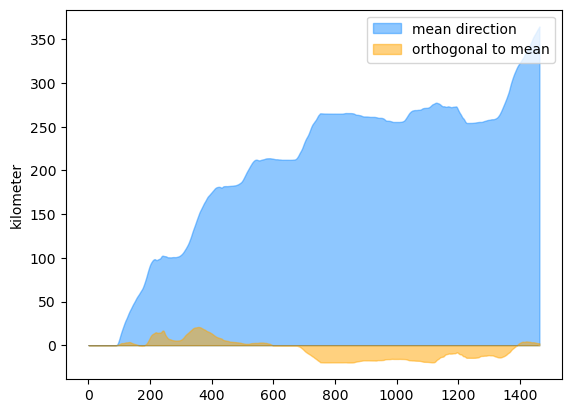

In [156]:
# # calculate zonal, meridional displacements
# DX = np.mean(dx.to('cm'))
# DY = np.mean(dy.to('cm'))

beta = (90-(-67.5))*units('degree') # change from azimuth to CCW from east

# calculate zonal, meridional displacements for azimuth
DX = (1*units('meter') * np.cos(beta.to('radian'))).to('cm')
DY = (1*units('meter') * np.sin(beta.to('radian'))).to('cm')

# find local components along this direction
compMs = (((dx*DX) + (dy*DY))/(np.sqrt(DX**2 + DY**2))).to('km')

# find local components perpendicular to this direction
compPs = (((dx*DY) + (dy*(-DX)))/(np.sqrt(DX**2 + DY**2))).to('km')

# plt.plot(np.cumsum(compMs), label='mean direction of travel')
# plt.plot(np.cumsum(compPs), label='orthogonal to mean')
plt.fill_between(np.arange(len(compMs)), 0, np.cumsum(compMs), color='dodgerblue', alpha=0.5, label='mean direction')
plt.fill_between(np.arange(len(compPs)), 0, np.cumsum(compPs), color='orange', alpha=0.5, label='orthogonal to mean')
plt.hlines(0,0,1460, colors='k', linewidths=0.5, zorder=-1)
plt.legend()


print(f'Net displacement parallel to WNW direction: {np.cumsum(compMs)[-1]}')
print(f'Net displacement orthogonal to WNW direction: {np.cumsum(compPs)[-1]}')
print(f'Fraction of net travel perpendicular to mean direction over net displacement along mean direction: {np.cumsum(compPs)[-1]/np.cumsum(compMs)[-1]}')

In [157]:
print(f'Daily mean WNW transport: {np.mean(compMs)*24}')

Daily mean WNW transport: 5.978576968906468 kilometer


## Find rate of ice transport during case study events

In [158]:
ind_ti = np.where(time == datetime(2021, 3, 29, 0))[0][0]
ind_tf = np.where(time == datetime(2021, 4, 1, 23))[0][0]

print('Event E5\n--------')
print(f'During four days of event E5, buoy traveled {np.sum(compMs[ind_ti:ind_tf+1])} along WNW direction')
print(f'This is a rate of {np.sum(compMs[ind_ti:ind_tf+1])/4} per day along WNW direction\n')


print('Event E7\n--------')
ind_ti = np.where(time == datetime(2021, 4, 16, 0))[0][0]
ind_tf = np.where(time == datetime(2021, 4, 17, 23))[0][0]

print(f'During four days of event E7, buoy traveled {np.sum(compMs[ind_ti:ind_tf+1])} along WNW direction')
print(f'This is a rate of {np.sum(compMs[ind_ti:ind_tf+1])/1} per day along WNW direction')

Event E5
--------
During four days of event E5, buoy traveled 52.2639213633993 kilometer along WNW direction
This is a rate of 13.065980340849825 kilometer per day along WNW direction

Event E7
--------
During four days of event E7, buoy traveled 1.3273134641174669 kilometer along WNW direction
This is a rate of 1.3273134641174669 kilometer per day along WNW direction


In [159]:
tot_parallel_dist = np.sum(np.abs(compMs))
fwd_dist = np.sum(compMs[compMs > 0])

print(f'% of time travel parallel to mean direction is forward along track: {100*(fwd_dist/tot_parallel_dist).magnitude:.2f}%')
print('    >>> motion is strongly forward along track, with some reversals')

tot_orthog_dist = np.sum(np.abs(compPs))
fwd_orth_dist = np.sum(compPs[compPs > 0])
print(f'\n% of time travel orthogonal to mean direction is forward (offshore): {100*(fwd_orth_dist/tot_orthog_dist).magnitude:.2f}%')
print('    >>> check! looks good, this should be the case for motion perpendicular mean direction')


% of time travel parallel to mean direction is forward along track: 90.63%
    >>> motion is strongly forward along track, with some reversals

% of time travel orthogonal to mean direction is forward (offshore): 50.68%
    >>> check! looks good, this should be the case for motion perpendicular mean direction


Very little difference between using S or M directions
1.0135662364216211 dimensionless


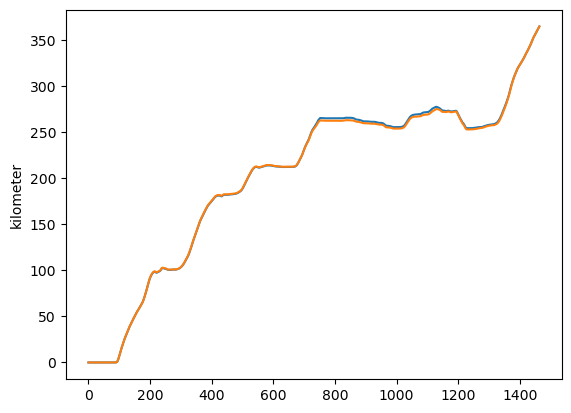

In [160]:
print('Very little difference between using S or M directions')
print(compSs[-1]/compMs[-1])

plt.plot(np.cumsum(compMs));
plt.plot(np.cumsum(compSs));

In [161]:
# all_lons = lon_track[::2]
# all_lats = lat_track[::2]

# dX = np.array([])
# dY = np.array([])
# dI = np.array([])

# for ii in range(len(all_lons)-1):

#     # current location
#     loc1=(all_lats[ii], all_lons[ii])
#     # end location
#     loc2=(all_lats[ii+1], all_lons[ii+1])

#     # compute forward and back azimuths, plus distance
#     az12,az21,distance = g.inv(loc1[1],loc1[0],loc2[1],loc2[0])
#     dI = np.append(dI, distance*units('meter').to('cm'))

#     # angle from east
#     beta = 90 * units('degree') - az12 * units('degree')
#     if beta <= -180*units('degree'):
#         beta += 360*units('degree')

#     # calculate zonal, meridional displacements fmor azimuth
#     DX = (distance*units('meter') * np.cos(beta.to('radian'))).to('cm')
#     DY = (distance*units('meter') * np.sin(beta.to('radian'))).to('cm')

#     dX = np.append(dX, DX)
#     dY = np.append(dY, DY)
    
# # component of little s along S
# # S = dX i + dY j
# # s = dx i + dY j
# # compSs = (s.S)/|S|

# # plt.plot(np.cumsum(compMs))



In [162]:
# fig, ax = plt.subplots(figsize=(4,3))
# ax.set_ylim(-0.5,13)

# speed_ratio = (np.sqrt(u**2+v**2).magnitude) / wind_speed
# output = ax.scatter(angle, speed_ratio, c=wind_dir, edgecolor='lightgray', lw=0.1, 
#             cmap='twilight_r', vmin=0, vmax=360, s=10)


# plt.colorbar(output, label='wind direction')
# ax.set_ylabel('speed norm')
# ax.set_xlabel('wind-ice deflection angle')

In [163]:
# # start location
# loc1=(all_lats[0], all_lons[0])
# # end location
# loc2=(all_lats[-1], all_lons[-1])
    
# # compute forward and back azimuths, plus distance
# az12,az21,distance = g.inv(loc1[1],loc1[0],loc2[1],loc2[0])
# print(az12,az21,distance)
# print(f'avg of two directions is: {np.mean([(az21-180), (az12)])}')

# AZ12 = -67.175

# # angle from east
# beta = 90 * units('degree') - AZ12 * units('degree')
# if beta <= -180*units('degree'):
#     beta += 360*units('degree')
# # calculate zonal, meridional displacements fmor azimuth
# DX = (distance*units('meter') * np.cos(beta.to('radian'))).to('cm')
# DY = (distance*units('meter') * np.sin(beta.to('radian'))).to('cm')

# compMs = ((dx*DX) + (dy*DY))/(np.sqrt(DX**2+ DY**2))



# AZ12 = 27.5

# # angle from east
# beta = 90 * units('degree') - AZ12 * units('degree')
# if beta <= -180*units('degree'):
#     beta += 360*units('degree')
# # calculate zonal, meridional displacements fmor azimuth
# DX = (distance*units('meter') * np.cos(beta.to('radian'))).to('cm')
# DY = (distance*units('meter') * np.sin(beta.to('radian'))).to('cm')

# compLs = ((dx*DX) + (dy*DY))/(np.sqrt(DX**2+ DY**2))



# # create figure in NorthPolarStereo projection
# #---------------------------------------------
# map_projection = ccrs.NorthPolarStereo(central_longitude=210)

# lat_range = [70, 73]
# lon_range = [205, 218]
# fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection),figsize=(5,4), facecolor='white')
# plt.subplots_adjust(wspace=0.05, hspace=0)

# # set map extent, add grid and geo features
# #------------------------------------------
# ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
# ax.set_aspect('equal')
# ax.spines['geo'].set_edgecolor('gray')
# ax.spines['geo'].set_linewidth(1)
# add_coast(ax, scale='10m', color='k', linewidth=0.5, alpha=1, zorder=10)
# add_land(ax,  scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=9)
# add_grid(ax, lats=np.arange(70,74,1), lons=np.arange(200,220,1), linewidth=1, color='gray', alpha=0.2, zorder=10)

# ax.plot(all_lons, all_lats, transform=ccrs.PlateCarree(), c='k', label='drift track')

# ax.scatter([all_lons[0], all_lons[-1]], [all_lats[0], all_lats[-1]], transform=ccrs.PlateCarree(), s=100, zorder=-1, c='orange')
# ax.plot([all_lons[0], all_lons[-1]], [all_lats[0], all_lats[-1]], transform=ccrs.PlateCarree(), zorder=-1, c='orange', label=f'M (azimuth = {AZ12:.1f}'+'$^{\circ}$)')

# ax.scatter([all_lons[360], all_lons[-1]], [all_lats[360], all_lats[-1]], transform=ccrs.PlateCarree(), s=60, zorder=-1, c='dodgerblue')
# ax.plot([all_lons[360], all_lons[-1]], [all_lats[360], all_lats[-1]], transform=ccrs.PlateCarree(), zorder=-1, c='dodgerblue', label='S (azimuth varies)')


# plt.legend()


### V1: based on openings

In [164]:
dist_unit = 'km'

buoy_close_dict = {}

for seq in compact_sequences:

    buoy_close_dict[seq] = {}
    
    ti_ind = np.where(time == compact_sequences[seq][0])[0][0]
    tf_ind = np.where(time == compact_sequences[seq][-1])[0][0]

    if seq == 0:
        buoy_close_dict[seq]['dx'] = np.cumsum(dx[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_close_dict[seq]['dy'] = np.cumsum(dy[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_close_dict[seq]['di'] = np.cumsum(dist[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_close_dict[seq]['ds'] = np.cumsum(compMs[ti_ind:tf_ind+1]).to(dist_unit).magnitude
    else:
        buoy_close_dict[seq]['dx'] = buoy_close_dict[seq-1]['dx'][-1] + np.cumsum(dx[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_close_dict[seq]['dy'] = buoy_close_dict[seq-1]['dy'][-1] + np.cumsum(dy[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_close_dict[seq]['di'] = buoy_close_dict[seq-1]['di'][-1] + np.cumsum(dist[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_close_dict[seq]['ds'] = buoy_close_dict[seq-1]['ds'][-1] + np.cumsum(compMs[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        
        

buoy_open_dict = {}

for seq in break_sequences:

    buoy_open_dict[seq] = {}
    
    ti_ind = np.where(time == break_sequences[seq][0])[0][0]
    tf_ind = np.where(time == break_sequences[seq][-1])[0][0]

    if seq == 0:
        buoy_open_dict[seq]['dx'] = np.cumsum(dx[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_open_dict[seq]['dy'] = np.cumsum(dy[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_open_dict[seq]['di'] = np.cumsum(dist[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_open_dict[seq]['ds'] = np.cumsum(compMs[ti_ind:tf_ind+1]).to(dist_unit).magnitude
    else:
        buoy_open_dict[seq]['dx'] = buoy_open_dict[seq-1]['dx'][-1] + np.cumsum(dx[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_open_dict[seq]['dy'] = buoy_open_dict[seq-1]['dy'][-1] + np.cumsum(dy[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_open_dict[seq]['di'] = buoy_open_dict[seq-1]['di'][-1] + np.cumsum(dist[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_open_dict[seq]['ds'] = buoy_open_dict[seq-1]['ds'][-1] + np.cumsum(compMs[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        
        
buoy_forc_dict = {}

for seq in force_sequences:

    buoy_forc_dict[seq] = {}
    
    ti_ind = np.where(time == force_sequences[seq][0])[0][0]
    tf_ind = np.where(time == force_sequences[seq][-1])[0][0]

    if seq == 0:
        buoy_forc_dict[seq]['dx'] = np.cumsum(dx[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_forc_dict[seq]['dy'] = np.cumsum(dy[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_forc_dict[seq]['di'] = np.cumsum(dist[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_forc_dict[seq]['ds'] = np.cumsum(compMs[ti_ind:tf_ind+1]).to(dist_unit).magnitude
    else:
        buoy_forc_dict[seq]['dx'] = buoy_forc_dict[seq-1]['dx'][-1] + np.cumsum(dx[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_forc_dict[seq]['dy'] = buoy_forc_dict[seq-1]['dy'][-1] + np.cumsum(dy[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_forc_dict[seq]['di'] = buoy_forc_dict[seq-1]['di'][-1] + np.cumsum(dist[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        buoy_forc_dict[seq]['ds'] = buoy_forc_dict[seq-1]['ds'][-1] + np.cumsum(compMs[ti_ind:tf_ind+1]).to(dist_unit).magnitude
        
        

all_event_di = np.array([])
all_event_dy = np.array([])
all_event_dx = np.array([])
all_event_ds = np.array([])

for seq in buoy_open_dict:
    all_event_di = np.append(all_event_di, buoy_open_dict[seq]['di'])
    all_event_dy = np.append(all_event_dy, buoy_open_dict[seq]['dy'])
    all_event_dx = np.append(all_event_dx, buoy_open_dict[seq]['dx'])
    all_event_ds = np.append(all_event_ds, buoy_open_dict[seq]['ds'])


xlims: 2021-03-01 00:00:00 ---- 2021-05-01 00:00:00


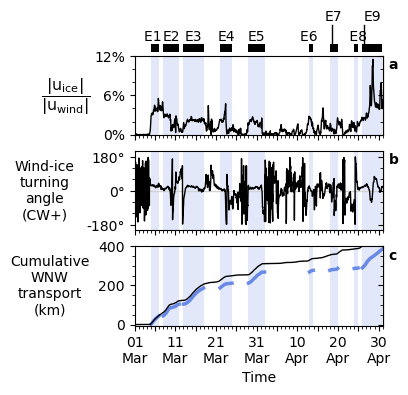

In [202]:

fig, axs = plt.subplots(3, 1, sharex=True, facecolor='white',
                       gridspec_kw = {'height_ratios':[1,1,1]}, figsize = (3.2,3.5))

plt.subplots_adjust(hspace=0.2)

XMIN = time[0] #- timedelta(hours=5)
XMAX = time[-1] + timedelta(hours=1)
print(f'xlims: {XMIN} ---- {XMAX}')

# all time
l1_color = 'k'
l1_w = 1
f1_color = 'none'
f1_alpha = 1

# break sequences, continuous
l2_color = 'r'
l2_w = 1
l2_style = 'solid'
f2_color = 'none'
f2_alpha = 0.2

# break sequences, discontinuous
# l3_color = 'darkorange'
l3_color = 'royalblue'
l3_w = 1.5
f3_color = 'none'
f3_alpha = 1

# background highlights
# f4_color = 'gold'
# f4_alpha = 0.4
f4_color = 'lightgray'
f4_alpha = 0.5

dist_unit = 'km'


#///////////////////
# buoy velocity ///
#/////////////////////////////////////////////////////////////////////////////////////

# #----------
# ax = axs[0]
# #----------
# # labels
# ax.set_ylabel('Buoy\nvelocity', rotation=0, labelpad=40, verticalalignment='center')
# ax.set_ylim(-1,1)
# ax.set_yticks([])
# sp=1


# # v1 colormap
# # mapColS = [plt.cm.gray(i) for i in np.linspace(0,1,50)[:15]] 
# # mapColS = (mapColS + mapColS[::-1]) * 183
# # COLOR = mapColS[:1464]

# # v3
# COLOR = 'k'
# ax.hlines(0, XMIN, XMAX, color='k', lw=0.5, zorder=-1)

# vec = ax.quiver(time[::sp], np.zeros_like(u)[::sp], u[::sp], v[::sp], 
#                color=COLOR, scale = 300, headwidth=0, pivot='tail')
# qk = ax.quiverkey(vec, 0.65, 0.13, 20, label=r'$20 \; \mathrm{cm} \; {\mathrm{s}}^{-1}$', 
#                   labelpos='E', labelsep = 0.05, coordinates='axes')

        
    
#/////////////////////////////////////////////////////////////////////////////////////


#/////////////////////////
# ice-wind speed norm ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[0]
#----------
# labels
# '$\mathrm{{u_{ice}}({u_{wind}})^{-1}}$\n(%)'
ax.set_ylabel(r'$\mathrm{\dfrac{|u_{ice}|}{|u_{wind}|}}$', rotation=0, labelpad=20,
              verticalalignment='center', fontsize = FS+1.5)
ax.set_ylim(-0.1,12)
ax.yaxis.set_major_locator(plt.MultipleLocator(6))
ax.yaxis.set_minor_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_formatter('{x:.0f}%')

ax2 = ax.secondary_yaxis("right")
ax2.yaxis.set_major_locator(plt.MultipleLocator(6))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(2))
ax2.tick_params(axis="y",which='both', direction="in")
ax2.set_yticklabels([])


sp=1

ax.plot(time, (np.sqrt(u**2+v**2).magnitude) / wind_speed, c='k', lw=1)
# ax.fill_between(time, 0, (np.sqrt(u**2+v**2).magnitude) / wind_speed, color='lightgray', lw=0, zorder=-1)

# ax.fill_between(time,1.6,2.9, color='royalblue', edgecolor='None',alpha=0.5, zorder=-1)

# ax.fill_between(time,0.05,1.04, color='lightgray',edgecolor='None', zorder=-2)
# ax.hlines(2.5, time[0], time[-1], colors='lightgray', linestyles='solid', linewidths=2, zorder=0)





for seq in break_sequences:     
    ax.fill_between([break_sequences[seq][0], break_sequences[seq][-1]], 
                    ax.get_ylim()[-1]*1.05,ax.get_ylim()[-1]*1.15,
                    facecolor='k', edgecolor='None',alpha=1, zorder=-1, clip_on=False)
    
    label = f'E{seq+1}'
    if seq == 6 or seq == 8:
        y = 1.45
        tt = break_sequences[seq][0]+timedelta(hours=12)
        ax.plot([tt, tt], [ax.get_ylim()[-1]*1.15, ax.get_ylim()[-1]*1.4], lw=1, c='k', clip_on=False)
    else:
        y = 1.2
        
    if seq == 5 or seq == 0:
        label = f'E{seq+1} '
    if seq == 7 or seq == 9:
        label = f' E{seq+1}'
    
        
    ax.text(break_sequences[seq][int(len(break_sequences[seq])/2)], ax.get_ylim()[-1]*y, label, 
            color='k', horizontalalignment='center', clip_on=False)
#/////////////////////////////////////////////////////////////////////////////////////

#/////////////////////////
# ice-wind deflection ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[1]
#----------
# labels
ax.set_ylabel('Wind-ice\nturning\nangle\n(CW+)', rotation=0, labelpad=30, verticalalignment='center')
ax.set_ylim(-210,210)
ax.yaxis.set_major_locator(plt.MultipleLocator(180))
ax.yaxis.set_minor_locator(plt.MultipleLocator(60))

ax.set_yticks([-180,0,180])
ax.yaxis.set_major_formatter('{x:.0f}°')

ax2 = ax.secondary_yaxis("right")
ax2.yaxis.set_major_locator(plt.MultipleLocator(180))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(60))
ax2.tick_params(axis="y",which='both', direction="in")
ax2.set_yticklabels([])


sp=1

ax.plot(time, angle, c='k', lw=1, zorder=1)

# ax.scatter(time, angle, c='k', s=0.5, zorder=1)

# ax.fill_between(time,3.5,25, color='royalblue', edgecolor='None', alpha=0.5, zorder=-1)

# ax.fill_between(time,-25.6,41.9, color='lightgray',edgecolor='None',  zorder=-2)

ax.hlines(0, time[0], time[-1], colors='lightgray', linestyles='solid', linewidths=1, zorder=0)

#/////////////////////////////////////////////////////////////////////////////////////



#///////////////////////////////////////////
# total toward-destination displacement ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[2]
#----------

# labels
ax.set_xticks([])
ax.set_ylabel('Cumulative\nWNW\ntransport\n(km)', rotation=0, labelpad=35, verticalalignment='center')
ax.set_ylim(-5,400)
ax.yaxis.set_major_locator(plt.MultipleLocator(200))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
    
ax2 = ax.secondary_yaxis("right")
ax2.yaxis.set_major_locator(plt.MultipleLocator(200))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax2.tick_params(axis="y",which='both', direction="in")
ax2.set_yticklabels([])

# for tick in ax.yaxis.get_major_ticks():
#     tick.tick1line.set_markersize(2)
# for tt in [4,8]:
#     ax.yaxis.get_major_ticks()[tt].tick1line.set_markersize(4)
    
    
# all time
#---------
# ax.fill_between(time, 0, np.cumsum(compSs.to(dist_unit)), color='lightgray',lw=0, zorder=0)
# ax.plot(time, np.cumsum(compSs.to(dist_unit)), color='k',lw=1, zorder=1)
ax.plot(time, np.cumsum(np.sqrt(dx**2 + dy**2).to('km')), color='k',lw=1, zorder=1)

# opening events
#---------------
for seq in break_sequences:
    if seq == 0:
        ax.plot(break_sequences[seq], buoy_open_dict[seq]['di'],zorder=0, c=l3_color, lw = 2.5, alpha=0.75, label='open')
    else:
        ax.plot(break_sequences[seq], buoy_open_dict[seq]['di'], zorder=0,c=l3_color, lw = 2.5, alpha=0.75)

# compact events
#---------------
# for seq in compact_sequences:
#     if seq == 0:
#         ax.plot(compact_sequences[seq], buoy_close_dict[seq]['ds'], c='r', lw = l3_w, label='consolidated')
#     else:
#         ax.plot(compact_sequences[seq], buoy_close_dict[seq]['ds'], c='r', lw = l3_w)

# axs[AX].fill_between(opening_dates_withhours, 0, all_event_di, color=l3_color, alpha=0.25, edgecolor='None',)
        
# forcing events
#---------------        
# for seq in force_sequences:
#     if seq == 0:
#         ax.plot(force_sequences[seq], buoy_forc_dict[seq]['ds'], c=l2_color, lw = l2_w, label='E-S winds')
#     else:
#         ax.plot(force_sequences[seq], buoy_forc_dict[seq]['ds'], c=l2_color, lw = l2_w)
        
        
# legend
# ax.legend(ncol=1, facecolor='none', edgecolor='none', loc = 'upper left') #bbox_to_anchor = (1,1), 

#/////////////////////////////////////////////////////////////////////////////////////

# x ticks
#--------
dates_to_label = time[::5*24]
# date_labels = [date.strftime('%m/%d') for dd, date in enumerate(dates_to_label)]
date_labels = [f"{pd.to_datetime(date).strftime('%d')}\n{pd.to_datetime(date).strftime('%b')}" for dd, date in enumerate(dates_to_label)]
for dd, date in enumerate(date_labels):
    if dd%2 == 1 :
        date_labels[dd] = ''
        
for ax in fig.get_axes()[:-1]:
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.set_xticks([])
#     ax.set_xticks(dates_to_label)
#     ax.set_xticklabels(['' for date in dates_to_label])
    ax.set_xlim(XMIN, XMAX)
for ax in [fig.get_axes()[-1]]:
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.set_xticks(dates_to_label)
    ax.set_xticklabels(date_labels)
    ax.set_xlim(XMIN, XMAX)
    ax.set_xlabel('Time')

for ax in fig.get_axes():
    for seq in open_sequences:  
        ax.fill_between([open_sequences[seq][0], open_sequences[seq][-1]], ax.get_ylim()[0], ax.get_ylim()[-1],
                    facecolor='royalblue', edgecolor='None',alpha=0.15, zorder=-1, clip_on=False)

        
for ll, label in enumerate(['a', 'b', 'c']):
    # label panel
    axs[ll].text(1.025, 0.975, label, fontsize=FS, weight='bold', 
            horizontalalignment='left', verticalalignment='top', transform = axs[ll].transAxes, zorder=100)

# forcing events
#---------------        
# for seq in force_sequences:
#     ax.plot(force_sequences[seq], buoy_forc_dict[seq]['ds'], c='r', lw = 1)

    
    
    
    
# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigF/cum_dist_forc_{start_date.strftime('%m.%d')}_{end_date.strftime('%m.%d')}_v5.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)



In [212]:
total_open_dist = buoy_open_dict[seq]['di'][-1]
total_dist = np.cumsum(dist.to('km'))[-1].magnitude


print(f'opening events account for {total_open_dist/total_dist:.4f} of overall distance travelled')



opening events account for 0.7753 of overall distance travelled


In [185]:
dI

Magnitude,[36451504.6155706 36451602.21143188 36451713.39184495 ... 185029.7933680396 123910.48757524775 62582.80957079474]
Units,centimeter


xlims: 2021-03-01 00:00:00 ---- 2021-05-01 00:00:00


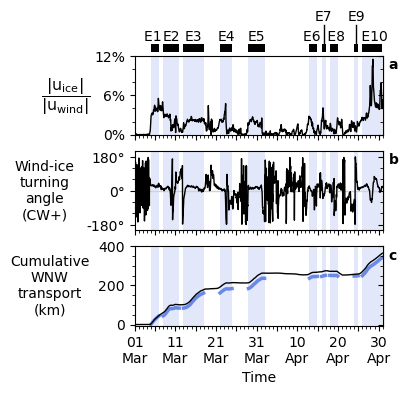

In [49]:

fig, axs = plt.subplots(3, 1, sharex=True, facecolor='white',
                       gridspec_kw = {'height_ratios':[1,1,1]}, figsize = (3.2,3.5))

plt.subplots_adjust(hspace=0.2)

XMIN = time[0] #- timedelta(hours=5)
XMAX = time[-1] + timedelta(hours=1)
print(f'xlims: {XMIN} ---- {XMAX}')

# all time
l1_color = 'k'
l1_w = 1
f1_color = 'none'
f1_alpha = 1

# break sequences, continuous
l2_color = 'r'
l2_w = 1
l2_style = 'solid'
f2_color = 'none'
f2_alpha = 0.2

# break sequences, discontinuous
# l3_color = 'darkorange'
l3_color = 'royalblue'
l3_w = 1.5
f3_color = 'none'
f3_alpha = 1

# background highlights
# f4_color = 'gold'
# f4_alpha = 0.4
f4_color = 'lightgray'
f4_alpha = 0.5

dist_unit = 'km'


#///////////////////
# buoy velocity ///
#/////////////////////////////////////////////////////////////////////////////////////

# #----------
# ax = axs[0]
# #----------
# # labels
# ax.set_ylabel('Buoy\nvelocity', rotation=0, labelpad=40, verticalalignment='center')
# ax.set_ylim(-1,1)
# ax.set_yticks([])
# sp=1


# # v1 colormap
# # mapColS = [plt.cm.gray(i) for i in np.linspace(0,1,50)[:15]] 
# # mapColS = (mapColS + mapColS[::-1]) * 183
# # COLOR = mapColS[:1464]

# # v3
# COLOR = 'k'
# ax.hlines(0, XMIN, XMAX, color='k', lw=0.5, zorder=-1)

# vec = ax.quiver(time[::sp], np.zeros_like(u)[::sp], u[::sp], v[::sp], 
#                color=COLOR, scale = 300, headwidth=0, pivot='tail')
# qk = ax.quiverkey(vec, 0.65, 0.13, 20, label=r'$20 \; \mathrm{cm} \; {\mathrm{s}}^{-1}$', 
#                   labelpos='E', labelsep = 0.05, coordinates='axes')

        
    
#/////////////////////////////////////////////////////////////////////////////////////


#/////////////////////////
# ice-wind speed norm ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[0]
#----------
# labels
# '$\mathrm{{u_{ice}}({u_{wind}})^{-1}}$\n(%)'
ax.set_ylabel(r'$\mathrm{\dfrac{|u_{ice}|}{|u_{wind}|}}$', rotation=0, labelpad=20,
              verticalalignment='center', fontsize = FS+1.5)
ax.set_ylim(-0.1,12)
ax.yaxis.set_major_locator(plt.MultipleLocator(6))
ax.yaxis.set_minor_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_formatter('{x:.0f}%')

ax2 = ax.secondary_yaxis("right")
ax2.yaxis.set_major_locator(plt.MultipleLocator(6))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(2))
ax2.tick_params(axis="y",which='both', direction="in")
ax2.set_yticklabels([])


sp=1

ax.plot(time, (np.sqrt(u**2+v**2).magnitude) / wind_speed, c='k', lw=1)
# ax.fill_between(time, 0, (np.sqrt(u**2+v**2).magnitude) / wind_speed, color='lightgray', lw=0, zorder=-1)

# ax.fill_between(time,1.6,2.9, color='royalblue', edgecolor='None',alpha=0.5, zorder=-1)

# ax.fill_between(time,0.05,1.04, color='lightgray',edgecolor='None', zorder=-2)
# ax.hlines(2.5, time[0], time[-1], colors='lightgray', linestyles='solid', linewidths=2, zorder=0)





for seq in break_sequences:     
    ax.fill_between([break_sequences[seq][0], break_sequences[seq][-1]], 
                    ax.get_ylim()[-1]*1.05,ax.get_ylim()[-1]*1.15,
                    facecolor='k', edgecolor='None',alpha=1, zorder=-1, clip_on=False)
    
    label = f'E{seq+1}'
    if seq == 6 or seq == 8:
        y = 1.45
        tt = break_sequences[seq][0]+timedelta(hours=12)
        ax.plot([tt, tt], [ax.get_ylim()[-1]*1.15, ax.get_ylim()[-1]*1.4], lw=1, c='k', clip_on=False)
    else:
        y = 1.2
        
    if seq == 5 or seq == 0:
        label = f'E{seq+1} '
    if seq == 7 or seq == 9:
        label = f' E{seq+1}'
    
        
    ax.text(break_sequences[seq][int(len(break_sequences[seq])/2)], ax.get_ylim()[-1]*y, label, 
            color='k', horizontalalignment='center', clip_on=False)
#/////////////////////////////////////////////////////////////////////////////////////

#/////////////////////////
# ice-wind deflection ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[1]
#----------
# labels
ax.set_ylabel('Wind-ice\nturning\nangle\n(CW+)', rotation=0, labelpad=30, verticalalignment='center')
ax.set_ylim(-210,210)
ax.yaxis.set_major_locator(plt.MultipleLocator(180))
ax.yaxis.set_minor_locator(plt.MultipleLocator(60))

ax.set_yticks([-180,0,180])
ax.yaxis.set_major_formatter('{x:.0f}°')

ax2 = ax.secondary_yaxis("right")
ax2.yaxis.set_major_locator(plt.MultipleLocator(180))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(60))
ax2.tick_params(axis="y",which='both', direction="in")
ax2.set_yticklabels([])


sp=1

ax.plot(time, angle, c='k', lw=1, zorder=1)

# ax.scatter(time, angle, c='k', s=0.5, zorder=1)

# ax.fill_between(time,3.5,25, color='royalblue', edgecolor='None', alpha=0.5, zorder=-1)

# ax.fill_between(time,-25.6,41.9, color='lightgray',edgecolor='None',  zorder=-2)

ax.hlines(0, time[0], time[-1], colors='lightgray', linestyles='solid', linewidths=1, zorder=0)

#/////////////////////////////////////////////////////////////////////////////////////



#///////////////////////////////////////////
# total toward-destination displacement ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[2]
#----------

# labels
ax.set_xticks([])
ax.set_ylabel('Cumulative\nWNW\ntransport\n(km)', rotation=0, labelpad=35, verticalalignment='center')
ax.set_ylim(-5,400)
ax.yaxis.set_major_locator(plt.MultipleLocator(200))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
    
ax2 = ax.secondary_yaxis("right")
ax2.yaxis.set_major_locator(plt.MultipleLocator(200))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax2.tick_params(axis="y",which='both', direction="in")
ax2.set_yticklabels([])

# for tick in ax.yaxis.get_major_ticks():
#     tick.tick1line.set_markersize(2)
# for tt in [4,8]:
#     ax.yaxis.get_major_ticks()[tt].tick1line.set_markersize(4)
    
    
# all time
#---------
# ax.fill_between(time, 0, np.cumsum(compSs.to(dist_unit)), color='lightgray',lw=0, zorder=0)
ax.plot(time, np.cumsum(compSs.to(dist_unit)), color='k',lw=1, zorder=1)

# opening events
#---------------
for seq in break_sequences:
    if seq == 0:
        ax.plot(break_sequences[seq], buoy_open_dict[seq]['ds'],zorder=0, c=l3_color, lw = 2.5, alpha=0.75, label='open')
    else:
        ax.plot(break_sequences[seq], buoy_open_dict[seq]['ds'], zorder=0,c=l3_color, lw = 2.5, alpha=0.75)

# compact events
#---------------
# for seq in compact_sequences:
#     if seq == 0:
#         ax.plot(compact_sequences[seq], buoy_close_dict[seq]['ds'], c='r', lw = l3_w, label='consolidated')
#     else:
#         ax.plot(compact_sequences[seq], buoy_close_dict[seq]['ds'], c='r', lw = l3_w)

# axs[AX].fill_between(opening_dates_withhours, 0, all_event_di, color=l3_color, alpha=0.25, edgecolor='None',)
        
# forcing events
#---------------        
# for seq in force_sequences:
#     if seq == 0:
#         ax.plot(force_sequences[seq], buoy_forc_dict[seq]['ds'], c=l2_color, lw = l2_w, label='E-S winds')
#     else:
#         ax.plot(force_sequences[seq], buoy_forc_dict[seq]['ds'], c=l2_color, lw = l2_w)
        
        
# legend
# ax.legend(ncol=1, facecolor='none', edgecolor='none', loc = 'upper left') #bbox_to_anchor = (1,1), 

#/////////////////////////////////////////////////////////////////////////////////////

# x ticks
#--------
dates_to_label = time[::5*24]
# date_labels = [date.strftime('%m/%d') for dd, date in enumerate(dates_to_label)]
date_labels = [f"{pd.to_datetime(date).strftime('%d')}\n{pd.to_datetime(date).strftime('%b')}" for dd, date in enumerate(dates_to_label)]
for dd, date in enumerate(date_labels):
    if dd%2 == 1 :
        date_labels[dd] = ''
        
for ax in fig.get_axes()[:-1]:
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.set_xticks([])
#     ax.set_xticks(dates_to_label)
#     ax.set_xticklabels(['' for date in dates_to_label])
    ax.set_xlim(XMIN, XMAX)
for ax in [fig.get_axes()[-1]]:
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.set_xticks(dates_to_label)
    ax.set_xticklabels(date_labels)
    ax.set_xlim(XMIN, XMAX)
    ax.set_xlabel('Time')

for ax in fig.get_axes():
    for seq in open_sequences:  
        ax.fill_between([open_sequences[seq][0], open_sequences[seq][-1]], ax.get_ylim()[0], ax.get_ylim()[-1],
                    facecolor='royalblue', edgecolor='None',alpha=0.15, zorder=-1, clip_on=False)

        
for ll, label in enumerate(['a', 'b', 'c']):
    # label panel
    axs[ll].text(1.025, 0.975, label, fontsize=FS, weight='bold', 
            horizontalalignment='left', verticalalignment='top', transform = axs[ll].transAxes, zorder=100)

# forcing events
#---------------        
# for seq in force_sequences:
#     ax.plot(force_sequences[seq], buoy_forc_dict[seq]['ds'], c='r', lw = 1)

    
    
    
    
# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigF/cum_dist_forc_{start_date.strftime('%m.%d')}_{end_date.strftime('%m.%d')}_v5.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)



xlims: 2021-03-01 00:00:00 ---- 2021-05-01 00:00:00


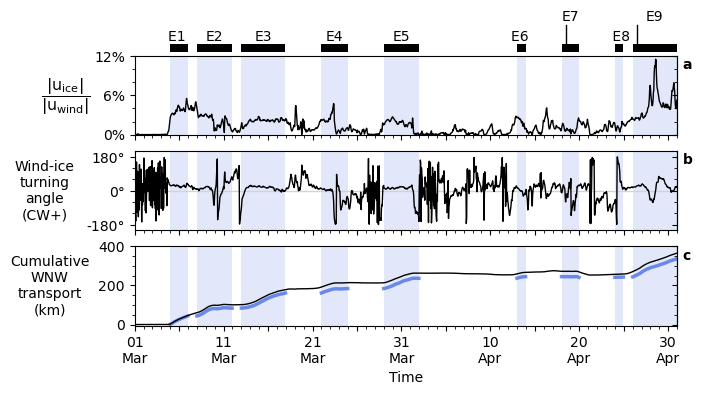

In [166]:

fig, axs = plt.subplots(3, 1, sharex=True, facecolor='white',
                       gridspec_kw = {'height_ratios':[1,1,1]}, figsize = (7,3.5))

plt.subplots_adjust(hspace=0.2)

XMIN = time[0] #- timedelta(hours=5)
XMAX = time[-1] + timedelta(hours=1)
print(f'xlims: {XMIN} ---- {XMAX}')

# all time
l1_color = 'k'
l1_w = 1
f1_color = 'none'
f1_alpha = 1

# break sequences, continuous
l2_color = 'r'
l2_w = 1
l2_style = 'solid'
f2_color = 'none'
f2_alpha = 0.2

# break sequences, discontinuous
# l3_color = 'darkorange'
l3_color = 'royalblue'
l3_w = 1.5
f3_color = 'none'
f3_alpha = 1

# background highlights
# f4_color = 'gold'
# f4_alpha = 0.4
f4_color = 'lightgray'
f4_alpha = 0.5

dist_unit = 'km'


#///////////////////
# buoy velocity ///
#/////////////////////////////////////////////////////////////////////////////////////

# #----------
# ax = axs[0]
# #----------
# # labels
# ax.set_ylabel('Buoy\nvelocity', rotation=0, labelpad=40, verticalalignment='center')
# ax.set_ylim(-1,1)
# ax.set_yticks([])
# sp=1


# # v1 colormap
# # mapColS = [plt.cm.gray(i) for i in np.linspace(0,1,50)[:15]] 
# # mapColS = (mapColS + mapColS[::-1]) * 183
# # COLOR = mapColS[:1464]

# # v3
# COLOR = 'k'
# ax.hlines(0, XMIN, XMAX, color='k', lw=0.5, zorder=-1)

# vec = ax.quiver(time[::sp], np.zeros_like(u)[::sp], u[::sp], v[::sp], 
#                color=COLOR, scale = 300, headwidth=0, pivot='tail')
# qk = ax.quiverkey(vec, 0.65, 0.13, 20, label=r'$20 \; \mathrm{cm} \; {\mathrm{s}}^{-1}$', 
#                   labelpos='E', labelsep = 0.05, coordinates='axes')

        
    
#/////////////////////////////////////////////////////////////////////////////////////


#/////////////////////////
# ice-wind speed norm ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[0]
#----------
# labels
# '$\mathrm{{u_{ice}}({u_{wind}})^{-1}}$\n(%)'
ax.set_ylabel(r'$\mathrm{\dfrac{|u_{ice}|}{|u_{wind}|}}$', rotation=0, labelpad=20,
              verticalalignment='center', fontsize = FS+1.5)
ax.set_ylim(-0.1,12)
ax.yaxis.set_major_locator(plt.MultipleLocator(6))
ax.yaxis.set_minor_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_formatter('{x:.0f}%')

ax2 = ax.secondary_yaxis("right")
ax2.yaxis.set_major_locator(plt.MultipleLocator(6))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(2))
ax2.tick_params(axis="y",which='both', direction="in")
ax2.set_yticklabels([])


sp=1

ax.plot(time, (np.sqrt(u**2+v**2).magnitude) / wind_speed, c='k', lw=1)
# ax.fill_between(time, 0, (np.sqrt(u**2+v**2).magnitude) / wind_speed, color='lightgray', lw=0, zorder=-1)

# ax.fill_between(time,1.6,2.9, color='royalblue', edgecolor='None',alpha=0.5, zorder=-1)

# ax.fill_between(time,0.05,1.04, color='lightgray',edgecolor='None', zorder=-2)
# ax.hlines(2.5, time[0], time[-1], colors='lightgray', linestyles='solid', linewidths=2, zorder=0)





for seq in break_sequences:     
    ax.fill_between([break_sequences[seq][0], break_sequences[seq][-1]], 
                    ax.get_ylim()[-1]*1.05,ax.get_ylim()[-1]*1.15,
                    facecolor='k', edgecolor='None',alpha=1, zorder=-1, clip_on=False)
    
    label = f'E{seq+1}'
    if seq == 6 or seq == 8:
        y = 1.45
        tt = break_sequences[seq][0]+timedelta(hours=12)
        ax.plot([tt, tt], [ax.get_ylim()[-1]*1.15, ax.get_ylim()[-1]*1.4], lw=1, c='k', clip_on=False)
    else:
        y = 1.2
        
    if seq == 5 or seq == 0:
        label = f'E{seq+1} '
    if seq == 7 or seq == 9:
        label = f' E{seq+1}'
    
        
    ax.text(break_sequences[seq][int(len(break_sequences[seq])/2)], ax.get_ylim()[-1]*y, label, 
            color='k', horizontalalignment='center', clip_on=False)
#/////////////////////////////////////////////////////////////////////////////////////

#/////////////////////////
# ice-wind deflection ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[1]
#----------
# labels
ax.set_ylabel('Wind-ice\nturning\nangle\n(CW+)', rotation=0, labelpad=30, verticalalignment='center')
ax.set_ylim(-210,210)
ax.yaxis.set_major_locator(plt.MultipleLocator(180))
ax.yaxis.set_minor_locator(plt.MultipleLocator(60))

ax.set_yticks([-180,0,180])
ax.yaxis.set_major_formatter('{x:.0f}°')

ax2 = ax.secondary_yaxis("right")
ax2.yaxis.set_major_locator(plt.MultipleLocator(180))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(60))
ax2.tick_params(axis="y",which='both', direction="in")
ax2.set_yticklabels([])


sp=1

ax.plot(time, angle, c='k', lw=1, zorder=1)

# ax.scatter(time, angle, c='k', s=0.5, zorder=1)

# ax.fill_between(time,3.5,25, color='royalblue', edgecolor='None', alpha=0.5, zorder=-1)

# ax.fill_between(time,-25.6,41.9, color='lightgray',edgecolor='None',  zorder=-2)

ax.hlines(0, time[0], time[-1], colors='lightgray', linestyles='solid', linewidths=1, zorder=0)

#/////////////////////////////////////////////////////////////////////////////////////



#///////////////////////////////////////////
# total toward-destination displacement ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[2]
#----------

# labels
ax.set_xticks([])
ax.set_ylabel('Cumulative\nWNW\ntransport\n(km)', rotation=0, labelpad=35, verticalalignment='center')
ax.set_ylim(-5,400)
ax.yaxis.set_major_locator(plt.MultipleLocator(200))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
    
ax2 = ax.secondary_yaxis("right")
ax2.yaxis.set_major_locator(plt.MultipleLocator(200))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax2.tick_params(axis="y",which='both', direction="in")
ax2.set_yticklabels([])

# for tick in ax.yaxis.get_major_ticks():
#     tick.tick1line.set_markersize(2)
# for tt in [4,8]:
#     ax.yaxis.get_major_ticks()[tt].tick1line.set_markersize(4)
    
    
# all time
#---------
# ax.fill_between(time, 0, np.cumsum(compSs.to(dist_unit)), color='lightgray',lw=0, zorder=0)
ax.plot(time, np.cumsum(compSs.to(dist_unit)), color='k',lw=1, zorder=1)

# opening events
#---------------
for seq in break_sequences:
    if seq == 0:
        ax.plot(break_sequences[seq], buoy_open_dict[seq]['ds'],zorder=0, c=l3_color, lw = 2.5, alpha=0.75, label='open')
    else:
        ax.plot(break_sequences[seq], buoy_open_dict[seq]['ds'], zorder=0,c=l3_color, lw = 2.5, alpha=0.75)

# compact events
#---------------
# for seq in compact_sequences:
#     if seq == 0:
#         ax.plot(compact_sequences[seq], buoy_close_dict[seq]['ds'], c='r', lw = l3_w, label='consolidated')
#     else:
#         ax.plot(compact_sequences[seq], buoy_close_dict[seq]['ds'], c='r', lw = l3_w)

# axs[AX].fill_between(opening_dates_withhours, 0, all_event_di, color=l3_color, alpha=0.25, edgecolor='None',)
        
# forcing events
#---------------        
# for seq in force_sequences:
#     if seq == 0:
#         ax.plot(force_sequences[seq], buoy_forc_dict[seq]['ds'], c=l2_color, lw = l2_w, label='E-S winds')
#     else:
#         ax.plot(force_sequences[seq], buoy_forc_dict[seq]['ds'], c=l2_color, lw = l2_w)
        
        
# legend
# ax.legend(ncol=1, facecolor='none', edgecolor='none', loc = 'upper left') #bbox_to_anchor = (1,1), 

#/////////////////////////////////////////////////////////////////////////////////////

# x ticks
#--------
dates_to_label = time[::5*24]
# date_labels = [date.strftime('%m/%d') for dd, date in enumerate(dates_to_label)]
date_labels = [f"{pd.to_datetime(date).strftime('%d')}\n{pd.to_datetime(date).strftime('%b')}" for dd, date in enumerate(dates_to_label)]
for dd, date in enumerate(date_labels):
    if dd%2 == 1 :
        date_labels[dd] = ''
        
for ax in fig.get_axes()[:-1]:
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.set_xticks([])
#     ax.set_xticks(dates_to_label)
#     ax.set_xticklabels(['' for date in dates_to_label])
    ax.set_xlim(XMIN, XMAX)
for ax in [fig.get_axes()[-1]]:
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.set_xticks(dates_to_label)
    ax.set_xticklabels(date_labels)
    ax.set_xlim(XMIN, XMAX)
    ax.set_xlabel('Time')

for ax in fig.get_axes():
    for seq in open_sequences:  
        ax.fill_between([open_sequences[seq][0], open_sequences[seq][-1]], ax.get_ylim()[0], ax.get_ylim()[-1],
                    facecolor='royalblue', edgecolor='None',alpha=0.15, zorder=-1, clip_on=False)

        
for ll, label in enumerate(['a', 'b', 'c']):
    # label panel
    axs[ll].text(1.01, 0.975, label, fontsize=FS, weight='bold', 
            horizontalalignment='left', verticalalignment='top', transform = axs[ll].transAxes, zorder=100)

# forcing events
#---------------        
# for seq in force_sequences:
#     ax.plot(force_sequences[seq], buoy_forc_dict[seq]['ds'], c='r', lw = 1)

    
    
    
    
# save figure
# ------------   
# savename = f"./figures/cum_dist_forc_{start_date.strftime('%m.%d')}_{end_date.strftime('%m.%d')}_v5.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)



In [167]:
print(f'open events\n----------')
print(f'events occurred during {len(opening_dates_withhours)} hours of {len(time)} total hours {time[0]}---{time[-1]}')
print(f'   - {100*len(opening_dates_withhours)/len(time):.1f}% total hours')


total_ds = np.cumsum(compMs.to(dist_unit).magnitude)[-1]
totop_ds = buoy_open_dict[list(buoy_open_dict.keys())[-1]]['ds'][-1]
totcl_ds = buoy_close_dict[list(buoy_close_dict.keys())[-1]]['ds'][-1]

print(f'\ntotal WNW displacement: {total_ds:.1f}')
print(f'   - during events only: {totop_ds:.1f} ({100*(totop_ds/total_ds):.1f} % of total)')
print(f'   - during compact periods: {totcl_ds:.1f} ({100*(totcl_ds/total_ds):.1f} % of total)')


total_di = np.cumsum(dist.to(dist_unit).magnitude)[-1]
totop_di = buoy_open_dict[list(buoy_open_dict.keys())[-1]]['di'][-1]
totcl_di = buoy_close_dict[list(buoy_close_dict.keys())[-1]]['di'][-1]

print(f'\ntotal distance: {total_di:.1f}')
print(f'   - during events only: {totop_di:.1f} ({100*(totop_di/total_di):.1f} % of total)')
print(f'   - during compact periods: {totcl_di:.1f} ({100*(totcl_di/total_di):.1f} % of total)')


print(f'\n\nwind events\n----------')
print(f'\nevents occurred during {len(forcing_dates_withhours)} hours of {len(time)} total hours {time[0]}---{time[-1]}')
print(f'   - {100*len(forcing_dates_withhours)/len(time):.1f}% total hours')

total_ds = np.cumsum(compMs.to(dist_unit).magnitude)[-1]
totop_ds = buoy_forc_dict[list(buoy_forc_dict.keys())[-1]]['ds'][-1]

print(f'\ntotal toward-destination displacement: {total_ds:.1f}')
print(f'   - during events only: {totop_ds:.1f}')
print(f'   - events account for {100*(totop_ds/total_ds):.1f} % of total')

open events
----------
events occurred during 648 hours of 1464 total hours 2021-03-01 00:00:00---2021-04-30 23:00:00
   - 44.3% total hours

total WNW displacement: 364.7
   - during events only: 336.2 (92.2 % of total)
   - during compact periods: 28.5 (7.8 % of total)

total distance: 497.3
   - during events only: 385.5 (77.5 % of total)
   - during compact periods: 111.7 (22.5 % of total)


wind events
----------

events occurred during 818 hours of 1464 total hours 2021-03-01 00:00:00---2021-04-30 23:00:00
   - 55.9% total hours

total toward-destination displacement: 364.7
   - during events only: 389.1
   - events account for 106.7 % of total


In [54]:
print(f'open events\n----------')
print(f'events occurred during {len(opening_dates_withhours)} hours of {len(time)} total hours {time[0]}---{time[-1]}')
print(f'   - {100*len(opening_dates_withhours)/len(time):.1f}% total hours')


total_ds = np.cumsum(compMs.to(dist_unit).magnitude)[-1]
totop_ds = buoy_open_dict[list(buoy_open_dict.keys())[-1]]['ds'][-1]
totcl_ds = buoy_close_dict[list(buoy_close_dict.keys())[-1]]['ds'][-1]

print(f'\ntotal WNW displacement: {total_ds:.1f}')
print(f'   - during events only: {totop_ds:.1f} ({100*(totop_ds/total_ds):.1f} % of total)')
print(f'   - during compact periods: {totcl_ds:.1f} ({100*(totcl_ds/total_ds):.1f} % of total)')


total_di = np.cumsum(dist.to(dist_unit).magnitude)[-1]
totop_di = buoy_open_dict[list(buoy_open_dict.keys())[-1]]['di'][-1]
totcl_di = buoy_close_dict[list(buoy_close_dict.keys())[-1]]['di'][-1]

print(f'\ntotal distance: {total_di:.1f}')
print(f'   - during events only: {totop_di:.1f} ({100*(totop_di/total_di):.1f} % of total)')
print(f'   - during compact periods: {totcl_di:.1f} ({100*(totcl_di/total_di):.1f} % of total)')


print(f'\n\nwind events\n----------')
print(f'\nevents occurred during {len(forcing_dates_withhours)} hours of {len(time)} total hours {time[0]}---{time[-1]}')
print(f'   - {100*len(forcing_dates_withhours)/len(time):.1f}% total hours')

total_ds = np.cumsum(compMs.to(dist_unit).magnitude)[-1]
totop_ds = buoy_forc_dict[list(buoy_forc_dict.keys())[-1]]['ds'][-1]

print(f'\ntotal toward-destination displacement: {total_ds:.1f}')
print(f'   - during events only: {totop_ds:.1f}')
print(f'   - events account for {100*(totop_ds/total_ds):.1f} % of total')

open events
----------
events occurred during 696 hours of 1464 total hours 2021-03-01 00:00:00---2021-04-30 23:00:00
   - 47.5% total hours

total WNW displacement: 364.7
   - during events only: 342.7 (94.0 % of total)
   - during compact periods: 22.0 (6.0 % of total)

total distance: 497.3
   - during events only: 393.2 (79.1 % of total)
   - during compact periods: 104.1 (20.9 % of total)


wind events
----------

events occurred during 818 hours of 1464 total hours 2021-03-01 00:00:00---2021-04-30 23:00:00
   - 55.9% total hours

total toward-destination displacement: 364.7
   - during events only: 389.1
   - events account for 106.7 % of total


### V2: based on forcing

xlims: 2021-03-01 00:00:00 ---- 2021-05-01 00:00:00


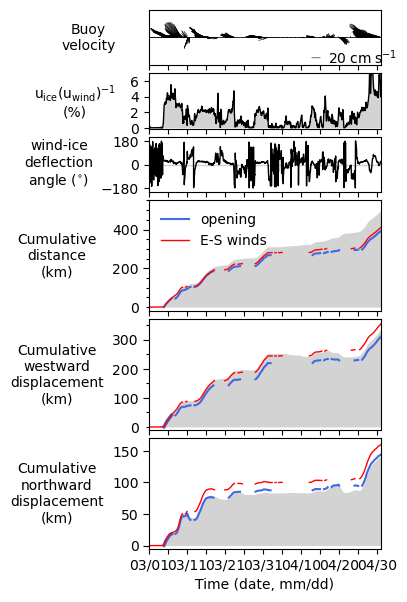

In [55]:

fig, axs = plt.subplots(6, 1, sharex=True, 
                       gridspec_kw = {'height_ratios':[1,1,1,2,2,2]}, figsize = (3,7))

plt.subplots_adjust(hspace=0.1)


XMIN = time[0] #- timedelta(hours=5)
XMAX = time[-1] + timedelta(hours=1)
print(f'xlims: {XMIN} ---- {XMAX}')

# all time
l1_color = 'k'
l1_w = 1
f1_color = 'none'
f1_alpha = 1

# break sequences, continuous
l2_color = 'r'
l2_w = 1
l2_style = 'solid'
f2_color = 'none'
f2_alpha = 0.2

# break sequences, discontinuous
# l3_color = 'darkorange'
l3_color = 'royalblue'
l3_w = 1.5
f3_color = 'none'
f3_alpha = 1

# background highlights
# f4_color = 'gold'
# f4_alpha = 0.4
f4_color = 'lightgray'
f4_alpha = 0.5

dist_unit = 'km'


#///////////////////
# buoy velocity ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[0]
#----------
# labels
ax.set_ylabel('Buoy\nvelocity', rotation=0, labelpad=40, verticalalignment='center')
ax.set_ylim(-1,1)
ax.set_yticks([])
sp=1


# v1 colormap
# mapColS = [plt.cm.gray(i) for i in np.linspace(0,1,50)[:15]] 
# mapColS = (mapColS + mapColS[::-1]) * 183
# COLOR = mapColS[:1464]

# v3
COLOR = 'k'
ax.hlines(0, XMIN, XMAX, color='k', lw=0.5, zorder=-1)

vec = ax.quiver(time[::sp], np.zeros_like(u)[::sp], u[::sp], v[::sp], 
               color=COLOR, scale = 400, headwidth=0, pivot='tail')
qk = ax.quiverkey(vec, 0.75, 0.13, 20, label=r'$20 \; \mathrm{cm} \; {\mathrm{s}}^{-1}$', 
                  labelpos='E', labelsep = 0.05, coordinates='axes')

#/////////////////////////////////////////////////////////////////////////////////////


#/////////////////////////
# ice-wind speed norm ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[1]
#----------
# labels
ax.set_ylabel('$\mathrm{{u_{ice}}({u_{wind}})^{-1}}$\n(%)', rotation=0, labelpad=40, verticalalignment='center')
ax.set_ylim(-0.1,7)
ax.set_yticks([0,2,4,6])
sp=1

ax.plot(time, (np.sqrt(u**2+v**2).magnitude) / wind_speed, c='k', lw=1)
ax.fill_between(time, 0, (np.sqrt(u**2+v**2).magnitude) / wind_speed, color='lightgray', lw=0, zorder=-1)

# ax.fill_between(time,1.6,2.9, color='royalblue', edgecolor='None',alpha=0.5, zorder=-1)

# ax.fill_between(time,0.05,1.04, color='lightgray',edgecolor='None', zorder=-2)
# ax.hlines(2.5, time[0], time[-1], colors='lightgray', linestyles='solid', linewidths=2, zorder=0)


#/////////////////////////////////////////////////////////////////////////////////////

#/////////////////////////
# ice-wind deflection ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
ax = axs[2]
#----------
# labels
ax.set_ylabel('wind-ice\ndeflection\nangle $(\mathrm{^{\circ}})$', rotation=0, labelpad=30, verticalalignment='center')
ax.set_ylim(-210,210)
ax.set_yticks([-180,0,180])
sp=1

ax.plot(time, angle, c='k', lw=1, zorder=1)

# ax.scatter(time, angle, c='k', s=0.5, zorder=1)

# ax.fill_between(time,3.5,25, color='royalblue', edgecolor='None', alpha=0.5, zorder=-1)

# ax.fill_between(time,-25.6,41.9, color='lightgray',edgecolor='None',  zorder=-2)

ax.hlines(0, time[0], time[-1], colors='lightgray', linestyles='solid', linewidths=1, zorder=0)


#/////////////////////////////////////////////////////////////////////////////////////



#////////////////////
# total distance ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
AX = 3
#----------

# labels
axs[AX].set_xticks([])
axs[AX].set_ylabel('Cumulative\ndistance\n(km)', rotation=0, labelpad=40, verticalalignment='center')
axs[AX].set_ylim(-20,540)
axs[AX].set_yticks([0,50,100,150, 200,250,300, 350, 400, 450, 500, 550])
axs[AX].set_yticklabels([0,'','','', 200, '','', '', 400, '', '', ''])
for tick in axs[AX].yaxis.get_major_ticks():
    tick.tick1line.set_markersize(2)
for tt in [4,8]:
    axs[AX].yaxis.get_major_ticks()[tt].tick1line.set_markersize(4)
    
    
# all time
#---------
axs[AX].fill_between(time, 0, np.cumsum(dist.to(dist_unit)), color='lightgray',lw=0, zorder=0)

# opening events
#---------------
for seq in break_sequences:
    if seq == 0:
        axs[AX].plot(break_sequences[seq], buoy_open_dict[seq]['di'], c=l3_color, lw = l3_w, label='opening')
    else:
        axs[AX].plot(break_sequences[seq], buoy_open_dict[seq]['di'], c=l3_color, lw = l3_w)

# axs[AX].fill_between(opening_dates_withhours, 0, all_event_di, color=l3_color, alpha=0.25, edgecolor='None',)
        
# forcing events
#---------------        
for seq in force_sequences:
    if seq == 0:
        axs[AX].plot(force_sequences[seq], buoy_forc_dict[seq]['di'], c=l2_color, lw = l2_w, label='E-S winds')
    else:
        axs[AX].plot(force_sequences[seq], buoy_forc_dict[seq]['di'], c=l2_color, lw = l2_w)
        

        
# legend
axs[AX].legend(ncol=1, facecolor='none', edgecolor='none', loc = 'upper left') #bbox_to_anchor = (1,1), 

#/////////////////////////////////////////////////////////////////////////////////////



#///////////////////////////
# westward displacement ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
AX = 4
#----------
# labels
axs[AX].set_xticks([])
axs[AX].set_ylabel('Cumulative\nwestward\ndisplacement\n(km)', rotation=0, labelpad=40, verticalalignment='center')
axs[AX].set_ylim(-10,370)
axs[AX].set_yticks([0,50,100,150, 200,250,300, 350])
axs[AX].set_yticklabels([0,'',100,'', 200, '',300, ''])

for tick in axs[AX].yaxis.get_major_ticks():
    tick.tick1line.set_markersize(2)
for tt in [2,4,6]:
    axs[AX].yaxis.get_major_ticks()[tt].tick1line.set_markersize(4)
    
    
# all time
#---------
axs[AX].fill_between(time, 0, -np.cumsum(dx.to(dist_unit)), color='lightgray',lw=0, zorder=0)

# opening events
#---------------
for seq in break_sequences:
    if seq == 0:
        axs[AX].plot(break_sequences[seq], -buoy_open_dict[seq]['dx'], c=l3_color, lw = l3_w+1)
    elif seq == 1:
        axs[AX].plot(break_sequences[seq], -buoy_open_dict[seq]['dx'], c=l3_color, lw = l3_w, label='opening')
    else:
        axs[AX].plot(break_sequences[seq], -buoy_open_dict[seq]['dx'], c=l3_color, lw = l3_w)

# forcing events
#---------------        
for seq in force_sequences:
    if seq == 0:
        axs[AX].plot(force_sequences[seq], -buoy_forc_dict[seq]['dx'], c=l2_color, lw = l2_w, label='E-S winds')
    else:
        axs[AX].plot(force_sequences[seq], -buoy_forc_dict[seq]['dx'], c=l2_color, lw = l2_w)

#/////////////////////////////////////////////////////////////////////////////////////        
        
        

#////////////////////////////
# northward displacement ///
#/////////////////////////////////////////////////////////////////////////////////////

#----------
AX = 5
#----------
# labels
axs[AX].set_ylabel('Cumulative\nnorthward\ndisplacement\n(km)', rotation=0, labelpad=40, verticalalignment='center')
axs[AX].set_ylim(-5,170)
axs[AX].set_yticks([0,50,100,150])

for tick in axs[AX].yaxis.get_major_ticks():
    tick.tick1line.set_markersize(4)
    
# all time
#---------
axs[AX].fill_between(time, 0, np.cumsum(dy.to(dist_unit)), color='lightgray',lw=0, zorder=0)

# opening events
#---------------
for seq in break_sequences:
    if seq == 0:
        axs[AX].plot(break_sequences[seq], buoy_open_dict[seq]['dy'], c=l3_color, lw = l3_w+1,)
    else:
        axs[AX].plot(break_sequences[seq], buoy_open_dict[seq]['dy'], c=l3_color, lw = l3_w)
# forcing events
#---------------        
for seq in force_sequences:
    axs[AX].plot(force_sequences[seq], buoy_forc_dict[seq]['dy'], c=l2_color, lw = l2_w)

    
#/////////////////////////////////////////////////////////////////////////////////////    
    





# x ticks
#--------
dates_to_label = time[::5*24]
date_labels = [date.strftime('%m/%d') for dd, date in enumerate(dates_to_label)]
for dd, date in enumerate(date_labels):
    if dd%2 == 1 :
        date_labels[dd] = ''
        
for ax in fig.get_axes()[:-1]:
    ax.set_xticks([])
#     ax.set_xticks(dates_to_label)
#     ax.set_xticklabels(['' for date in dates_to_label])
    ax.set_xlim(XMIN, XMAX)
for ax in [fig.get_axes()[-1]]:
    ax.set_xticks(dates_to_label)
    ax.set_xticklabels(date_labels)
    ax.set_xlim(XMIN, XMAX)
    ax.set_xlabel('Time (date, mm/dd)')
    
    
# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigF/cum_dist_forc_{start_date.strftime('%m.%d')}_{end_date.strftime('%m.%d')}_v2.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=True, bbox_inches="tight", pad_inches = 0.05, dpi=300)



### Stats on opening dates

In [56]:
print(f'events occurred during {len(opening_dates_withhours)} hours of {len(time)} total hours {time[0]}---{time[-1]}')
print(f'   - {100*len(opening_dates_withhours)/len(time):.1f}% total hours')


total_di = np.cumsum(dist.to(dist_unit).magnitude)[-1]
totop_di = buoy_open_dict[list(buoy_open_dict.keys())[-1]]['di'][-1]

total_dx = -np.cumsum(dx.to(dist_unit))[-1]
totop_dx = -buoy_open_dict[list(buoy_open_dict.keys())[-1]]['dx'][-1]

total_dy = np.cumsum(dy.to(dist_unit))[-1]
totop_dy = buoy_open_dict[list(buoy_open_dict.keys())[-1]]['dy'][-1]

print(f'\ntotal distance traveled: {total_di:.1f}')
print(f'   - during events only: {totop_di:.1f}')
print(f'   - events account for {100*(totop_di/total_di):.1f} % of total')

print(f'\ntotal zonal displacement: {total_dx:.1f}')
print(f'   - during events only: {totop_dx:.1f}')
print(f'   - events account for {100*(totop_dx/total_dx).magnitude:.1f} % of total')

print(f'\ntotal meridional displacement: {total_dy:.1f}')
print(f'   - during events only: {totop_dy:.1f}')
print(f'   - events account for {100*(totop_dy/total_dy).magnitude:.1f} % of total')


events occurred during 696 hours of 1464 total hours 2021-03-01 00:00:00---2021-04-30 23:00:00
   - 47.5% total hours

total distance traveled: 497.3
   - during events only: 393.2
   - events account for 79.1 % of total

total zonal displacement: 336.1 kilometer
   - during events only: 311.2
   - events account for 92.6 % of total

total meridional displacement: 141.5 kilometer
   - during events only: 144.3
   - events account for 102.0 % of total


In [57]:
print(f'events occurred during {len(forcing_dates_withhours)} hours of {len(time)} total hours {time[0]}---{time[-1]}')
print(f'   - {100*len(forcing_dates_withhours)/len(time):.1f}% total hours')


total_di = np.cumsum(dist.to(dist_unit).magnitude)[-1]
totop_di = buoy_forc_dict[list(buoy_forc_dict.keys())[-1]]['di'][-1]

total_dx = -np.cumsum(dx.to(dist_unit))[-1]
totop_dx = -buoy_forc_dict[list(buoy_forc_dict.keys())[-1]]['dx'][-1]

total_dy = np.cumsum(dy.to(dist_unit))[-1]
totop_dy = buoy_forc_dict[list(buoy_forc_dict.keys())[-1]]['dy'][-1]

print(f'\ntotal distance traveled: {total_di:.1f}')
print(f'   - during events only: {totop_di:.1f}')
print(f'   - events account for {100*(totop_di/total_di):.1f} % of total')

print(f'\ntotal zonal displacement: {total_dx:.1f}')
print(f'   - during events only: {totop_dx:.1f}')
print(f'   - events account for {100*(totop_dx/total_dx).magnitude:.1f} % of total')

print(f'\ntotal meridional displacement: {total_dy:.1f}')
print(f'   - during events only: {totop_dy:.1f}')
print(f'   - events account for {100*(totop_dy/total_dy).magnitude:.1f} % of total')

events occurred during 818 hours of 1464 total hours 2021-03-01 00:00:00---2021-04-30 23:00:00
   - 55.9% total hours

total distance traveled: 497.3
   - during events only: 410.8
   - events account for 82.6 % of total

total zonal displacement: 336.1 kilometer
   - during events only: 354.9
   - events account for 105.6 % of total

total meridional displacement: 141.5 kilometer
   - during events only: 160.1
   - events account for 113.1 % of total


# complex linear regression

In [58]:
import cmath
from scipy import stats

wind_complex = np.array([complex(local_u10[xx], local_v10[xx]) for xx in range(len(local_u10))])
buoy_complex = np.array([complex(buoy_23_u[xx], buoy_23_v[xx]) for xx in range(len(buoy_23_u))])

x = local_u10#wind_complex
y = buoy_23_u#buoy_complex

res = stats.linregress(x, y)
print(f"R-squared: {res.rvalue**2:.6f}")
print(res)

plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

x = local_v10#wind_complex
y = buoy_23_v#buoy_complex

res = stats.linregress(x, y)
print(f"R-squared: {res.rvalue**2:.6f}")
print(res)

plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

x = np.sqrt(local_u10**2+local_v10**2)
y = np.sqrt(buoy_23_u**2+buoy_23_v**2)

res = stats.linregress(x, y)
print(f"R-squared: {res.rvalue**2:.6f}")
print(res)

plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(4,4))

mean_wind = (np.mean(local_u10), np.mean(local_v10))
speed_mean_w = np.sqrt(mean_wind[0]**2 + mean_wind[1]**2)
mean_w_speed = np.mean(np.sqrt(local_u10**2+local_v10**2))
wind_dir_const = speed_mean_w/mean_w_speed
print(f'wind directional constancy: {wind_dir_const:.3f}')

mean_buoy = (np.mean(buoy_23_u), np.mean(buoy_23_v))
speed_mean_b = np.sqrt(mean_buoy[0]**2 + mean_buoy[1]**2)
mean_b_speed = np.mean(np.sqrt(buoy_23_u**2+buoy_23_v**2))
buoy_dir_const = speed_mean_b/mean_b_speed
print(f'buoy directional constancy: {buoy_dir_const:.3f}')

plt.quiver(0, 0, mean_wind[0], mean_wind[1], color='k', scale=20)

plt.quiver(0, 0, mean_buoy[0], mean_buoy[1], color='r', scale=20)

DimensionalityError: Cannot convert from 'centimeter / second' to 'dimensionless'

# check for directional constancy of winds / ice drift
https://link.springer.com/article/10.1007/s00382-022-06319-9

In [ ]:

# # import ERA5 data
# from LIB_access_ERA5 import shift_bylons
# dsERA = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2021.nc')
# dsERA.close()
# # shift by lons
# dsERA = shift_bylons(dsERA)

# # grab ice drift
# #---------------
# # date = datetime(year = 2020, month = 11, day = 1, hour = 12, minute = 0)


# counter = 0
# for date in time[::24]:
    
    
#     if counter == 0:
        
#         # grab ice data
#         PP_lon, PP_lat, PP_u, PP_v = grab_ice_Drift(date = date, lat_range=[67, 78], lon_range=[190, 240],
#                                           return_vars = ['lon', 'lat', 'u', 'v'])

#         counts = (np.isnan(PP_u)==False).astype(int) # save non-nan values
        
#         u_ice_loc = np.array([PP_u[aa,bb]])
#         v_ice_loc = np.array([PP_v[aa,bb]])
        
#         # turn nan values to zeros, won't be included in means
#         PP_u[np.isnan(PP_u)]=0
#         PP_v[np.isnan(PP_v)]=0
        
#         all_u = PP_u
#         all_v = PP_v
#         all_speed = np.sqrt(PP_u**2+PP_v**2)
        
#         # grab ERA5 data
#         dsERAspec = dsERA.sel(time=date).sel(longitude=slice(190,250)).sel(latitude=slice(80,65))
#         ERA_u = dsERAspec.u10.values
#         ERA_v = dsERAspec.v10.values
#         lon_ERA, lat_ERA = np.meshgrid(dsERAspec.longitude.values, dsERAspec.latitude.values)
        
#         all_u10 = ERA_u
#         all_v10 = ERA_v
#         all_speed10 = np.sqrt(ERA_u**2+ERA_v**2)
        
#     else:
        
#         # grab ice data
#         PP_u, PP_v = grab_ice_Drift(date = date, lat_range=[67, 78], lon_range=[190, 240],
#                                     return_vars = ['u', 'v'])

#         counts += (np.isnan(PP_u)==False).astype(int)
        
#         u_ice_loc = np.append(u_ice_loc, PP_u[aa,bb])
#         v_ice_loc = np.append(v_ice_loc, PP_v[aa,bb])
        
#         # turn nan values to zeros, won't be included in means
#         PP_u[np.isnan(PP_u)]=0
#         PP_v[np.isnan(PP_v)]=0
        
#         all_u += PP_u
#         all_v += PP_v
#         all_speed += np.sqrt(PP_u**2+PP_v**2)
        
#         # grab ERA5 data
#         dsERAspec = dsERA.sel(time=date).sel(longitude=slice(190,250)).sel(latitude=slice(80,65))
#         ERA_u = dsERAspec.u10.values
#         ERA_v = dsERAspec.v10.values
        
#         all_u10 += ERA_u
#         all_v10 += ERA_v
#         all_speed10 += np.sqrt(ERA_u**2+ERA_v**2)
        
        
#     counter+=1
    
# u_ice_mean = all_u/counts
# v_ice_mean = all_v/counts
# mean_speed_ice = all_speed/counts
# speed_mean_ice = np.sqrt(u_ice_mean**2+v_ice_mean**2)

# u10_mean = all_u10/counter
# v10_mean = all_v10/counter
# mean_speed10 = all_speed10/counter
# speed_mean10 = np.sqrt(u10_mean**2+v10_mean**2)

In [ ]:
# # create figure in NorthPolarStereo projection
# #---------------------------------------------
# map_projection = ccrs.NorthPolarStereo(central_longitude=205)
# lat_range = [69, 80]
# lon_range = [195, 232]
# fig, axs = plt.subplots(1,2, subplot_kw=dict(projection=map_projection),figsize=(8,3), facecolor='white')
# plt.subplots_adjust(wspace=0.05, hspace=0.1)


# for ax in [axs[0], axs[1]]:
    
#     # set map extent, add grid and geo features
#     #------------------------------------------
#     ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
#     ax.set_aspect('equal')
#     ax.spines['geo'].set_edgecolor('k')
#     add_coast(ax, scale='10m', color='gray', linewidth=0.5, alpha=1, zorder=4)
#     add_land(ax,  scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=3)
#     add_grid(ax, lats=np.arange(70,90,5), lons=np.arange(100,300,20), linewidth=1, color='gray', alpha=0.3, zorder=10)

    
# ax = axs[0]
# sp = 5
# ax.quiver(lon_ERA[::sp,::sp], lat_ERA[::sp,::sp], *fix_cartopy_vectors(u10_mean[::sp,::sp], v10_mean[::sp,::sp], lat_ERA[::sp,::sp]), 
#               color=[0.65,0.65,0.65], 
#               width=0.0025, headwidth=5, headlength=5, headaxislength=5,
#               scale=100,  zorder = 3, transform = ccrs.PlateCarree())

# dirconst = ax.pcolormesh(lon_ERA, lat_ERA, speed_mean10/mean_speed10, vmin=0, vmax=1,
#                          transform = ccrs.PlateCarree(), cmap=cmocean.cm.deep, zorder=-1)

# ax.contour(lon_ERA, lat_ERA, speed_mean10/mean_speed10,
#            levels=np.arange(0,1,0.1), colors='k', transform = ccrs.PlateCarree(), zorder=0)


# ax = axs[1]
# sp = 2
# ax.quiver(PP_lon[::sp,::sp], PP_lat[::sp,::sp], *fix_cartopy_vectors(u_ice_mean[::sp,::sp], v_ice_mean[::sp,::sp], PP_lat[::sp,::sp]), 
#               color=[0.65,0.65,0.65], width=0.0025, headwidth=5, headlength=5, headaxislength=5,
#               scale=200,  zorder = 3, transform = ccrs.PlateCarree())

# dirconst = ax.pcolormesh(PP_lon, PP_lat, speed_mean_ice/mean_speed_ice, vmin=0, vmax=1,
#                transform = ccrs.PlateCarree(), cmap=cmocean.cm.deep, zorder=-1)

# ax.contour(PP_lon, PP_lat, ma.masked_where(PP_lon<100, speed_mean_ice/mean_speed_ice),
#                        levels=np.arange(0,1,0.1), colors='k',transform = ccrs.PlateCarree(), zorder=0)

# plt.colorbar(dirconst)

# aa = 40
# bb = 45
# ax.scatter(PP_lon[aa,bb], PP_lat[aa,bb], c='r', s=50, transform = ccrs.PlateCarree(), zorder=1)

